<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import ridge_regression
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np
import copy

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (d, d) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (d * n, d)
        n, d = X.shape
        q = compute_q(p)

        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(d)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", n," ", d)
        print("y shape", y.shape)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", d*n)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        #if np.sum(S_mis * S_mis) == 0:
        if np.all(S_dict['S_mis'] == 0):
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        else:  # S_mis.shape == (n, d, d):
          S_dts_tiled = np.concatenate([S_dts] * n)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (d, d):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (d * n, d):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (n, d), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / n * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []

# dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}
def get_path(X, y, estimator, S_dict): #eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
    _, m = X.shape

    if S_dict['algo_superv_learn'] == 'adv':
      n_a_dts = S_dict['n_a_dts']
      a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
      a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']
      if np.all(S_dict['S_mis'] == 0):
        n_a_mis, a_d_mis_max, a_d_mis_min = 1, 0, 0
      else:
        n_a_mis = S_dict['n_a_mis']
        a_d_mis_max = S_dict['adv_rad_times_delta_mis_max']
        a_d_mis_min = a_d_mis_max * S_dict['eps_adv_rad_times_delta_mis']


      if a_d_dts_max < 0 or a_d_mis_max < 0 or n_a_dts < 1 or n_a_mis <1:
        print("WARNING: some bad values for the grid of cross validation, the number of grid point should be strictly potive, the radius strictly positive")
      alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts) if a_d_dts_max > 0 else np.zeros(1)
      alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis) if a_d_mis_max > 0 else np.zeros(1)
      #alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts)
      #alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis)
      print("dts deltas ", alphas_dts)
      print("mis deltas ", alphas_mis)
      #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
      hyper_p_ret_ = []
      coefs_ = []
      for a_mis_value in tqdm.tqdm(alphas_mis):
        for a_dts_value in tqdm.tqdm(alphas_dts):
            #tuple_key = (scale_dts_value, scale_mis_value)
            #coefs_ = []
            #for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
              #print("dict hyper in get path ", dict_hyper_p_values)
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a_dts_value, a_mis_value])
            #res[tuple_key] = np.stack((coefs_)).T
    elif S_dict['algo_superv_learn'] == 'ridge':
      n_a_rid = S_dict['n_a_rid']
      a_rid_max = S_dict['alpha_ridge_reg_max']
      a_rid_min = a_rid_max * S_dict['eps_alpha_ridge_reg']
      alphas_rid = np.logspace(np.log10(a_rid_min), np.log10(a_rid_max), n_a_rid) if a_rid_max > 0 else np.zeros(1)
      print("rid alphas ", alphas_rid)
      hyper_p_ret_ = []
      coefs_ = []
      for a_rid in tqdm.tqdm(alphas_rid):
            #dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
            #print("dict hyper in get path ", dict_hyper_p_values)
            coefs = estimator(X, y, a_rid)
            #print("alpha  ", a, "coef: ", coefs)
            coefs_.append(coefs if coefs is not None else np.zeros(m))
            hyper_p_ret_.append([a_rid, a_rid])  #([a_dts_value, a_mis_value])


    '''
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    '''
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

#dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'alpha_ridge_reg': 1,
#                             'eps_adv_rad_times_delta_dts': 1e-4, 'eps_adv_rad_times_delta_mis': 1e-4, 'eps_alpha_ridge_reg': 1e-4,
#                             'n_a_dts': 25, 'n_a_mis':4, 'n_a_rid': 25}}





'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):

    if S_dict['algo_superv_learn'] == 'adv':
      linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
      estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
    elif S_dict['algo_superv_learn'] == 'ridge':
      estimator = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False)#, random_state=0)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
      #estimator = lambda X, y, a: linear_model.Ridge(alpha=a).fit(X, y).coef_
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf


X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)

alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=True, random_state=0)
for a in alphas:
  coef, intercept = estim(X, y, a)
  print("coef : ", coef)
  print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  print("coef : ", coef)
  print("intercpt ", intercept)


'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
coef :  [ 2.00967407 -0.99005237 -0.0266142   0.01580495]
intercpt  0.0006861168825390592
coef :  [ 2.00967407 -0.99005237 -0.0266142   0.01580495]
intercpt  0.0006861168825390592
coef :  [ 2.00964794 -0.99004509 -0.02661507  0.01580849]
intercpt  0.0006852076672584524
coef :  [ 2.00964794 -0.99004509 -0.02661507  0.01580849]
intercpt  0.0006852076672584524
coef :  [ 2.00703937 -0.98931692 -0.02670184  0.01616208]
intercpt  0.0005940742598586547
coef :  [ 2.00703937 -0.98931692 -0.02670184  0.01616208]
intercpt  0.0005940742598586547
coef :  [ 1.98364014 -0.98281536 -0.02738799  0.01921275]
intercpt  -0.00010485470390981829
coef :  [ 1.98364014 -0.98281536 -0.02738799  0.01921275]
intercpt  -0.00010485470390981829
end block


In [2]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 100000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [3]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
'''
def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks
'''

def generate_masks(dictio_data):#nbr_of_sample, dim, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    dim = len(dictio_data['beta_gt'][0])
    nbr_of_sample = dictio_data['n_train'][0]
    p_missing = dictio_data['p_miss'][0]
    print("p_missing in generate mask ", p_missing)
    if dim == 2:
      if len(p_missing) < 3:
        print("WARNING: p_missing should be a list with a length of 3 if the dimension is 2")
      masks = np.zeros((nbr_of_sample, 2))
      v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
      masks[v == 0, :] = np.array([0, 0])  # both seen
      masks[v == 1, :] = np.array([0, 1])  # left seen
      masks[v == 2, :] = np.array([1, 0])  # right seen
    else:
      # in this branch, p_missing = [p1,.., pl],
      masks = np.array([np.random.binomial(1, 1-pr, (nbr_of_sample, dim)) for pr in p_missing])
      masks = np.cumsum(masks, axis=0)  # each round
      masks[masks>1] = 1
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + -1 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [8]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)  # size (info['mi_nbr], n, d)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:
      if info['cov_strategy'] == 'std_mi':   # std of the imputed dataset, then the mean
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        #s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = std_vectors[:, None, :] * np.eye(std_vectors.shape[-1])  # should be (m, d, d), with each diagonal the diagonals of std_vectors
        #S = s_within
        #S = np.diag(s_within)
        print("final S.shape in cov strategy std_mi ", S.shape)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure'] and 'cov_strategy_between' in info.keys():
      m, n, d = X_imputed.shape
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
        if info['post_imp'] == 'conc':
          S_mis = np.tile(S_mis, (m, 1, 1))
    else:  # not using a mi method, so uncertainty on missing part should be zero
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      print("shape X_imputed ", X_imputed.shape)
      X_train = np.concatenate(X_imputed)
      y_train = np.tile(y_train, X_imputed.shape[0])
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim)
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    # masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    # masks_train = generate_masks_binomial(n_train, p_miss)  # 1 missing, 0 observed
    #X_train, y_train, masks_train = clear_dataset(X_train, y_train, masks_train)
    # M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    # dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, []), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      print("NO PREVIOUS IMPUTATION HAS BEEN DONE")
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      print("A PREVIOUS IMPUTATION HAS BEEN DONE")
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) #* dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  #* dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    if 'post_imp' in dict_obs.keys():
      if dict_obs['post_imp'] == 'conc':
        print(S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing} | dict_obs['info_algo'] | {'algo_superv_learn': dict_imp['algo_superv_learn']}  # , 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    # dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}

    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi' and dict_imp['cov_strategy'] == 'std_mi':  # run a standard multiple imputation procedure
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      min_score = 0
      temporary_dictionary = copy.deepcopy(S_dict)
      for i in range(dict_imp['mi_nbr']):
        print("i  mi .-------------> ", i)
        #dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        #dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        #S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        #S = S_within[None, :, :] + S_between
        #S = np.concatenate(S, axis=0)
        #print(S)
        #alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        temporary_dictionary['S_dts'] = S_dict['S_dts'][i, :, :]
        print("temporary dict ", temporary_dictionary)
        hyper_p_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, temporary_dictionary, [])
        idx_best, min_score_partial = best_idx_predictor(X_test, coeff_results, y_test)
        print("weee ", idx_best)
        print(coeff_results.shape)
        print(hyper_p_used.shape)
        best_coeff_partial, _ = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        min_score += min_score_partial
        #best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
      best_coeff /= dict_imp['mi_nbr']
      min_score /=  dict_imp['mi_nbr']
      best_hyper_p = 0  # not important right now
      best_alpha_delta_dts = 1  # not important right now
      #best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha_delta_dts, best_alpha_delta_mis = best_hyper_p[0], best_hyper_p[1]
#      print("best alpha ----> ", best_alpha_dts)
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = S_dict['S_dts'] * best_alpha_delta_dts + S_dict['S_mis'] * best_alpha_delta_mis
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
#    print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])


    # obsere that one day you shoul add the return of alpha_delta_mis also
    return best_coeff, min_score, -np.log10(best_alpha_delta_dts)



In [5]:

def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])  # how many trials shall we do
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed  = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][0],
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][0],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0]
                                             )  # return {'X_train_masked':(X_train, mask_train) , 'X_test':.., 'y_train':, 'y_test'}
      #mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen
      full_masks = generate_masks(dictio)
    dictio_obser_fixed_copy = copy.deepcopy(dictio_obser_fixed)

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        if len(dictio['beta_gt'][0]) == 2:
          #mask_partial = dict_obser_partial['X_train_masked'][1]
          p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
          n_train = full_masks.shape[0]
          mask_partial = full_masks.copy()
          mask_partial[0:int(n_train * p_i), :] = 0
          tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
          dict_obser['X_train_masked'] = tuple_partial
        else:
          #print("size in run experiment", dictio_obser_fixed_copy['X_train_masked'][0].shape, "wee ", dictio_obser_fixed['y_train'].shape)
          ## we use the next line of code with dictio_obser_fixed_copy because we need to test the mask with the original dataset, otherwise we get size error (the dataset change if an observation get fully hidden)
          X_train_cleaned, y_train_cleaned, masks_train_cleaned = clear_dataset(dictio_obser_fixed_copy['X_train_masked'][0], dictio_obser_fixed_copy['y_train'], full_masks[i])
          #tuple_partial = (dictio_obser_fixed['X_train_masked'][0], full_masks[i])
          print("full masks in run experiment ", full_masks[i])
          dict_obser['X_train_masked'] = (X_train_cleaned, masks_train_cleaned)
          dict_obser['y_train'] = y_train_cleaned
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      print("info algo in run experiments ", dictio['info_algo'])
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}} | {'info_algo': dictio['info_algo']}  # add an entry for imputed dataset, and info for algorithm
      print("ciaoooooo dict obser in run experiments \n ", dict_obser)
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  fig_res, ax_res = plt.subplots(1, 3, figsize=(25, 5))#, num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key ", key, ": ", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(3):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  #ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  #ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[0].set_title(extra_info['title_infer_error'])
  ax_res[1].set_title(extra_info['title_test_error'])
  ax_res[2].set_ylabel("-log10(alpha)")
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio


def run_multiple_experiments(nbr_exp, rdm_seed, dictio, info_x_axis):
  #rdm_seed = 4654321
  np.random.seed(rdm_seed)
  res = run_experiments(dicc, list_methods_strategy)
  plot_res(info_x_axis, res, dicc)
  '''
  if nbr_exp > 1:
    for k in res:
      for h in res[k]:
        res[k][h] = [res[k][h]]
    for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])
  '''
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])

  print("final step, let's take the mean of the results")
  #print("res, after all the experimetns ", res)
  for k in res:
    print("key in res ", k)
    print(np.array(res[k]['l2_dist_best_coeff_gt']))
    print("mean l2_dist              ", np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
    print("mean_l2_dist diff method: ", np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
  #mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
  mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
  print("final dictionary, dictionary of the means:")
  for k, v in mean_res.items():
    print("k:   ", k)
    for s, t in v.items():
      print(s, ": ", t)
  return mean_res
  #print(np.mean(res, axis=0))




change nbr_experiments to match the size of n_train
data :  [{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655975, -0.00270317],
       [-0.00283878,  0.39424392,  0.0250872 ,  0.00902201,  0.0129305 ,
         0.07144244, -0.10804192, -0.05065312,  0.04437924,  0.01024259,
        -0.00692215, -0.04379986,  0.02386203,  0.00138693,  0.07332519,
         0.02693757,  0.04427111,  0.02844514],
       [-0.03798229,  0.0250872 ,  0.42458783,  0.01058758, -0.00142549,
        -0.0289068 ,  0.08626864,  0.08734275, -0.07443841, -0.00443016,
        -0.01875366, -0.01641354, -0.05692255, -0.01772908, -0.02574054,
         0.01459873,  0.01931102,  0.01026785],
       [-0.03607881,  0.00902201,  0.0105

100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  28.40049660963683
---------------------------------> best coeff  [-1.75344874e+00  1.66239644e+00  4.05723231e-08  1.38665757e+00
 -2.18964039e+00 -2.69356109e+00  4.47437941e+00  1.09858009e+00
  6.83534085e+00 -8.03986853e+00  9.11070551e-01 -2.00124343e+00
 -2.04752529e+00  4.42047030e+00  5.53970740e+00  6.31392587e+00
  7.16496320e+00  7.99755904e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  28.40049660963489
---------------------------------> best coeff  [-1.75344874e+00  1.66239644e+00  4.05723210e-08  1.38665757e+00
 -2.18964039e+00 -2.69356109e+00  4.47437941e+00  1.09858009e+00
  6.83534085e+00 -8.03986853e+00  9.11070551e-01 -2.00124343e+00
 -2.04752529e+00  4.42047030e+00  5.53970740e+00  6.31392587e+00
  7.16496320e+00  7.99755904e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 1019.43it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  28  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.38881552 0.38881552] , min score  28.649872505807032
---------------------------------> best coeff  [-1.87225678  2.36257652  0.33411267  1.53084973 -2.27525669 -2.90061518
  4.38707632  1.47379651  6.96643662 -8.21385231  1.08740333 -1.9181653
 -2.20779853  4.30633974  5.85006043  6.30545441  7.39915255  8.44790133]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1042.45it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  28  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.38881552 0.38881552] , min score  28.649872505807032
---------------------------------> best coeff  [-1.87225678  2.36257652  0.33411267  1.53084973 -2.27525669 -2.90061518
  4.38707632  1.47379651  6.96643662 -8.21385231  1.08740333 -1.9181653
 -2.20779853  4.30633974  5.85006043  6.30545441  7.39915255  8.44790133]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
NO PREVIOUS IMPUTAT

100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  28.400496609630796
---------------------------------> best coeff  [-1.75344874e+00  1.66239644e+00  4.05723127e-08  1.38665757e+00
 -2.18964039e+00 -2.69356109e+00  4.47437941e+00  1.09858009e+00
  6.83534085e+00 -8.03986853e+00  9.11070551e-01 -2.00124343e+00
 -2.04752529e+00  4.42047030e+00  5.53970740e+00  6.31392587e+00
  7.16496320e+00  7.99755904e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.7191

100%|██████████| 40/40 [00:00<00:00, 708.40it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  28  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.38881552 0.38881552] , min score  28.649872505807043
---------------------------------> best coeff  [-1.87225678  2.36257652  0.33411267  1.53084973 -2.27525669 -2.90061518
  4.38707632  1.47379651  6.96643662 -8.21385231  1.08740333 -1.9181653
 -2.20779853  4.30633974  5.85006043  6.30545441  7.39915255  8.44790133]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  34.61127101782781
---------------------------------> best coeff  [-1.22284531e+00  1.86703393e+00 -3.99782433e-03  1.45989899e+00
 -1.06761253e+00 -8.26041776e-01  3.56163732e+00  3.67275403e-02
  6.91796788e+00 -7.96600061e+00  1.60178532e+00 -1.79098204e+00
 -1.88374667e+00  5.06909458e+00  6.88577253e+00  6.91846608e+00
  6.83215396e+00  6.51696708e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  28.40049660963489
---------------------------------> best coeff  [-1.75344874e+00  1.66239644e+00  4.05723210e-08  1.38665757e+00
 -2.18964039e+00 -2.69356109e+00  4.47437941e+00  1.09858009e+00
  6.83534085e+00 -8.03986853e+00  9.11070551e-01 -2.00124343e+00
 -2.04752529e+00  4.42047030e+00  5.53970740e+00  6.31392587e+00
  7.16496320e+00  7.99755904e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 1127.01it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  35.75751959175495
---------------------------------> best coeff  [-1.34171492  2.46628019 -0.30936466  1.40493689 -1.16531833 -0.96586648
  3.66885042  0.757452    7.09225085 -7.42474058  2.26223635 -1.88522488
 -2.21158197  4.76088318  6.62666065  6.7050425   7.05698276  6.58782563]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1110.12it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  28  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.38881552 0.38881552] , min score  28.649872505807032
---------------------------------> best coeff  [-1.87225678  2.36257652  0.33411267  1.53084973 -2.27525669 -2.90061518
  4.38707632  1.47379651  6.96643662 -8.21385231  1.08740333 -1.9181653
 -2.20779853  4.30633974  5.85006043  6.30545441  7.39915255  8.44790133]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
NO PREVIOUS IMPUTAT

100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.0001    ] , min score  37.55799166863215
---------------------------------> best coeff  [-1.13847543e+00  2.24738614e+00  1.77899998e-01  1.40228634e+00
 -1.09156244e+00 -4.80504212e-01  3.44779429e+00 -4.48652652e-08
  7.24395465e+00 -7.85267551e+00  2.08430524e+00 -1.84616395e+00
 -2.03014078e+00  4.91158687e+00  6.82246945e+00  7.34164440e+00
  7.27805631e+00  6.46058136e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912

100%|██████████| 40/40 [00:00<00:00, 1117.32it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  36.89745405907252
---------------------------------> best coeff  [-1.32239520e+00  2.44365604e+00  2.35214518e-01  1.35888571e+00
 -1.16487709e+00 -6.73857881e-01  3.60053574e+00  2.24168432e-03
  6.96193339e+00 -7.01660995e+00  2.31800364e+00 -2.10091165e+00
 -2.03859118e+00  4.66166478e+00  6.36124680e+00  6.93037103e+00
  6.95317079e+00  6.23597606e+00]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.0580

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  40.06220479882462
---------------------------------> best coeff  [-0.95927815  3.05660279 -0.24397782  0.96493045 -2.11068206 -1.46664901
  2.49949675  1.10449135  6.38550225 -7.81970232  2.21757448 -1.90634841
 -1.55607758  5.74402771  6.39266817  5.472705    5.91695395  5.58972081]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------

100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  28.40049660963489
---------------------------------> best coeff  [-1.75344874e+00  1.66239644e+00  4.05723210e-08  1.38665757e+00
 -2.18964039e+00 -2.69356109e+00  4.47437941e+00  1.09858009e+00
  6.83534085e+00 -8.03986853e+00  9.11070551e-01 -2.00124343e+00
 -2.04752529e+00  4.42047030e+00  5.53970740e+00  6.31392587e+00
  7.16496320e+00  7.99755904e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 1149.91it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  41.32688612356869
---------------------------------> best coeff  [-1.49758797  3.63092246 -0.82578206  0.93037268 -2.22729875 -1.68683711
  2.75484968  1.76485616  6.22650425 -7.07629883  2.56587643 -2.12218225
 -1.98933327  5.2945114   6.08462305  5.30974338  6.26592723  5.96145765]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1049.15it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  28  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.38881552 0.38881552] , min score  28.649872505807032
---------------------------------> best coeff  [-1.87225678  2.36257652  0.33411267  1.53084973 -2.27525669 -2.90061518
  4.38707632  1.47379651  6.96643662 -8.21385231  1.08740333 -1.9181653
 -2.20779853  4.30633974  5.85006043  6.30545441  7.39915255  8.44790133]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
NO PREVIOUS IMPUTAT

100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.0001    ] , min score  44.914479770538954
---------------------------------> best coeff  [-4.13021820e-08  3.61823727e+00 -5.03999516e-10  1.77291748e+00
 -3.61968798e+00 -2.44114283e+00  2.36415066e+00  4.82398231e-01
  6.70006568e+00 -6.70023106e+00  2.38055519e+00 -3.25104426e+00
 -1.30333334e+00  5.39378534e+00  5.52260431e+00  5.68280165e+00
  5.80715058e+00  4.33921182e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.7191

100%|██████████| 40/40 [00:00<00:00, 1036.34it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  44.03121827009957
---------------------------------> best coeff  [-0.65215138  3.91758645 -0.15221168  1.60427296 -3.17086074 -2.32779708
  2.6089933   1.10999503  6.6120824  -6.07838255  2.66541405 -3.17537455
 -1.79474027  4.98513935  5.1050766   5.35708278  5.84322116  4.42752827]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -51.95075676188918
[ 7  6  5  2  2  9  2  7  5  7  2  6  1  7  6  4  6  6  5  3  7  7  2  4
  2  5  5  8 10  5  5  6  2  4  7  4  3  3  5  7  5  2  3  4  4  6  3  2
 11  8  8  4  6  3  3  4  6  2  5 12  7  0  4  7  5  5  8  5  7  7  8  6
  3  7  7  7  7  9  5  7]
S dataset 
 [[0.65576211 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.52975657 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.59893293 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.68743883 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  50.85237715018075
---------------------------------> best coeff  [-2.36268724  4.03062846  0.10327164  0.67162928 -1.17172302 -3.35373354
  1.22865009  1.5114278   3.17196274 -6.04104568  1.89216307 -3.375243
 -1.97401578  6.37871412  6.03905927  4.33378747  5.46640579  5.59680779]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  28.40049660963489
---------------------------------> best coeff  [-1.75344874e+00  1.66239644e+00  4.05723210e-08  1.38665757e+00
 -2.18964039e+00 -2.69356109e+00  4.47437941e+00  1.09858009e+00
  6.83534085e+00 -8.03986853e+00  9.11070551e-01 -2.00124343e+00
 -2.04752529e+00  4.42047030e+00  5.53970740e+00  6.31392587e+00
  7.16496320e+00  7.99755904e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 1177.57it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  49.10987545298824
---------------------------------> best coeff  [-1.89153046  4.24580039  0.71891769  1.74591731 -1.42393002 -3.55800365
  1.17047106  1.5234991   3.84685032 -5.49277987  1.86259596 -3.46260328
 -2.25650838  6.16643473  5.82712714  4.23874469  5.66055166  5.14306012]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1206.05it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  28  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.38881552 0.38881552] , min score  28.649872505807032
---------------------------------> best coeff  [-1.87225678  2.36257652  0.33411267  1.53084973 -2.27525669 -2.90061518
  4.38707632  1.47379651  6.96643662 -8.21385231  1.08740333 -1.9181653
 -2.20779853  4.30633974  5.85006043  6.30545441  7.39915255  8.44790133]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
NO PREVIOUS IMPUTAT

100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.0001    ] , min score  46.99120068321723
---------------------------------> best coeff  [-1.76420578  4.23890834 -0.42509609  3.68131414 -2.58798647 -2.69241466
  2.75197278  1.59353902  5.58539934 -4.59671213  1.28363123 -3.97797688
 -1.9133851   6.97271224  3.96559934  3.7345458   5.54235912  4.65044971]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
A 

100%|██████████| 40/40 [00:00<00:00, 759.00it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  31  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.94266846 0.94266846] , min score  48.37855821952469
---------------------------------> best coeff  [-2.02603427  4.67210713 -0.70196392  3.58144439 -2.84572922 -3.19816619
  2.92808491  1.88850094  5.37751299 -4.5330139   1.7115286  -4.24476492
 -2.15028151  6.6161168   3.96891794  3.56582934  5.88268601  5.13673472]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  61.100021817618156
---------------------------------> best coeff  [ 1.85255188e+00  4.69225333e-01  2.59737151e+00  2.13538073e+00
 -1.25118935e+00 -1.01018717e+00  1.76997902e+00 -6.36081173e-08
  8.56059443e+00 -7.07760852e+00 -3.40736022e-01 -2.49817270e+00
 -2.72524815e+00  7.85665586e+00  7.88368699e+00  7.90160879e+00
  2.97495277e+00  8.90229885e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  28.40049660963489
---------------------------------> best coeff  [-1.75344874e+00  1.66239644e+00  4.05723210e-08  1.38665757e+00
 -2.18964039e+00 -2.69356109e+00  4.47437941e+00  1.09858009e+00
  6.83534085e+00 -8.03986853e+00  9.11070551e-01 -2.00124343e+00
 -2.04752529e+00  4.42047030e+00  5.53970740e+00  6.31392587e+00
  7.16496320e+00  7.99755904e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 527.57it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  47.62363473704038
---------------------------------> best coeff  [ 1.24294808  2.10314644  2.2774659   1.3609099  -1.8550463  -1.29961767
  2.41434149  0.46687846  7.20106891 -6.97358861  0.23141016 -2.43048319
 -3.25948101  7.23459041  6.85884983  6.48890757  3.39250457  2.26565807]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 867.57it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  28  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.38881552 0.38881552] , min score  28.649872505807032
---------------------------------> best coeff  [-1.87225678  2.36257652  0.33411267  1.53084973 -2.27525669 -2.90061518
  4.38707632  1.47379651  6.96643662 -8.21385231  1.08740333 -1.9181653
 -2.20779853  4.30633974  5.85006043  6.30545441  7.39915255  8.44790133]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
NO PREVIOUS IMPUTAT

100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  53.372918970500514
---------------------------------> best coeff  [ 1.36737863  4.64833836  0.78533581  2.84166443 -2.02657255 -3.76026596
  1.36492679  2.15244212  7.54494524 -7.11665923  2.79171291 -3.25535127
 -3.62642713  6.1248548   3.69202523  6.27354269  2.41767111  3.26311992]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
A PREVIOUS

100%|██████████| 40/40 [00:00<00:00, 985.38it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  31  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.94266846 0.94266846] , min score  53.072675171165436
---------------------------------> best coeff  [ 1.06764594  4.27949595  0.67873974  2.58071936 -1.73254794 -3.41631453
  1.45980888  1.94616517  7.28194964 -6.60694474  2.6395131  -3.22099052
 -3.42200564  6.09187867  3.48710088  6.09522747  2.25670078  3.01238987]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.0665

100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  120.36495885435946
---------------------------------> best coeff  [-1.28273213e+00  3.12071372e+00 -6.35752002e-05 -1.15313267e-09
 -1.43260219e+00  5.33028910e+00  7.16405473e+00 -9.93114129e-07
  3.75460310e+00 -9.18052602e-01 -3.19452796e-09  4.90085145e-01
 -8.11684182e-01  7.24895763e+00  1.86874990e+00  4.14151102e+00
  3.81184001e+00  1.66924166e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  28.40049660963489
---------------------------------> best coeff  [-1.75344874e+00  1.66239644e+00  4.05723210e-08  1.38665757e+00
 -2.18964039e+00 -2.69356109e+00  4.47437941e+00  1.09858009e+00
  6.83534085e+00 -8.03986853e+00  9.11070551e-01 -2.00124343e+00
 -2.04752529e+00  4.42047030e+00  5.53970740e+00  6.31392587e+00
  7.16496320e+00  7.99755904e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 722.00it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [5.54102033 5.54102033] , min score  81.44884496714943
---------------------------------> best coeff  [-1.55886507  2.51715374 -0.30086971  0.19566272 -2.11610202  1.98195529
  5.19429969 -0.02158686  3.32247479 -2.96022355 -0.63084772  0.47423054
 -1.64981709  5.21316619  1.84084625  4.21159894  3.38608874  2.88191636]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 681.00it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  28  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.38881552 0.38881552] , min score  28.649872505807032
---------------------------------> best coeff  [-1.87225678  2.36257652  0.33411267  1.53084973 -2.27525669 -2.90061518
  4.38707632  1.47379651  6.96643662 -8.21385231  1.08740333 -1.9181653
 -2.20779853  4.30633974  5.85006043  6.30545441  7.39915255  8.44790133]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
NO PREVIOUS IMPUTAT

100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  52.21562728455323
---------------------------------> best coeff  [-1.85645217  3.31991323 -0.16196011  1.40809365 -2.44817811 -0.50781531
  4.16741039  1.40226463  4.85275067 -4.81215866  1.70398177 -0.45359467
 -2.84070078  6.83149752  5.23536703  4.03612798  4.81489771  3.66611342]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63040885 0.55044505 0.56954495 0.70485944 0.58372219 0.67678793
 0.74641128 0.67381723 0.76872751 0.5789844  0.64295011 0.71912205
 0.76355536 0.62161222 0.58480101 0.60586998 0.71365888 0.62458955]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 685.34it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  52.176513532256536
---------------------------------> best coeff  [-1.85927056  3.32275892 -0.16514561  1.41247366 -2.45257975 -0.51475015
  4.16930765  1.41014611  4.85719146 -4.81618765  1.70631518 -0.45411414
 -2.84597459  6.82843293  5.24038889  4.03651291  4.8223041   3.6700037 ]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-1.75344874e+00,  1.66239644e+00,  4.05723231e-08,  1.38665757e+00,
       -2.18964039e+00, -2.69356109e+00,  4.47437941e+00,  1.09858009e+00,
        6.83534085e+00, -8.03986853e+00,  9.11070551e-01, -2.00124343e+00,
       -2.04752529e+00,  4.42047030e+00,  5.53970740e+00,  6.31392587e+00,
        7.164963

100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  31.470015499155735
---------------------------------> best coeff  [-1.35965659  1.41811605  1.53036914  2.304028   -1.58345196 -1.75272205
  1.94690533  1.17420181  6.30857024 -8.72138588  0.17371436 -0.68177882
 -1.83793621  2.96738688  3.9331546   6.32609734  7.77755797  8.92696369]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  31.47001549915567
---------------------------------> best coeff  [-1.35965659  1.41811605  1.53036914  2.304028   -1.58345196 -1.75272205
  1.94690533  1.17420181  6.30857024 -8.72138588  0.17371436 -0.68177882
 -1.83793621  2.96738688  3.9331546   6.32609734  7.77755797  8.92696369]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 589.73it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  27  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.28942661 0.28942661] , min score  31.404449722297983
---------------------------------> best coeff  [-1.30594288  1.35847004  1.58800476  2.28254135 -1.60440743 -1.70775196
  1.93232105  1.12725457  6.25523407 -8.6232367   0.12394326 -0.77011984
 -1.80126711  2.84275773  3.84515536  6.2221729   7.63611676  8.71936479]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------

100%|██████████| 40/40 [00:00<00:00, 795.22it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  27  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.28942661 0.28942661] , min score  31.404449722297983
---------------------------------> best coeff  [-1.30594288  1.35847004  1.58800476  2.28254135 -1.60440743 -1.70775196
  1.93232105  1.12725457  6.25523407 -8.6232367   0.12394326 -0.77011984
 -1.80126711  2.84275773  3.84515536  6.2221729   7.63611676  8.71936479]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
NO PREVIOUS IMPUTA

100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  31.47001549915562
---------------------------------> best coeff  [-1.35965659  1.41811605  1.53036914  2.304028   -1.58345196 -1.75272205
  1.94690533  1.17420181  6.30857024 -8.72138588  0.17371436 -0.68177882
 -1.83793621  2.96738688  3.9331546   6.32609734  7.77755797  8.92696369]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 1187.91it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  27  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.28942661 0.28942661] , min score  31.40444972229798
---------------------------------> best coeff  [-1.30594288  1.35847004  1.58800476  2.28254135 -1.60440743 -1.70775196
  1.93232105  1.12725457  6.25523407 -8.6232367   0.12394326 -0.77011984
 -1.80126711  2.84275773  3.84515536  6.2221729   7.63611676  8.71936479]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  41.49727700238715
---------------------------------> best coeff  [ 1.73113316  2.0378129   3.34181294  2.32514846 -1.06651605 -2.0471744
  1.55293041  1.37354568  7.97099362 -9.26931838 -1.0560832   0.21323439
 -0.94902694  1.38743624  2.65483636  5.07726168  6.20360772  7.19041678]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  31.47001549915567
---------------------------------> best coeff  [-1.35965659  1.41811605  1.53036914  2.304028   -1.58345196 -1.75272205
  1.94690533  1.17420181  6.30857024 -8.72138588  0.17371436 -0.68177882
 -1.83793621  2.96738688  3.9331546   6.32609734  7.77755797  8.92696369]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 871.76it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  28  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.38881552 0.38881552] , min score  41.40498510734198
---------------------------------> best coeff  [ 1.67462369  1.92119654  3.33095899  2.33556546 -1.10774752 -1.98018026
  1.55623383  1.29365144  7.81789762 -9.04244909 -1.06107176  0.05342054
 -0.92876499  1.29843031  2.61117217  4.98464348  6.09319185  7.00760479]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 608.97it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  27  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.28942661 0.28942661] , min score  31.404449722297983
---------------------------------> best coeff  [-1.30594288  1.35847004  1.58800476  2.28254135 -1.60440743 -1.70775196
  1.93232105  1.12725457  6.25523407 -8.6232367   0.12394326 -0.77011984
 -1.80126711  2.84275773  3.84515536  6.2221729   7.63611676  8.71936479]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  41.94828227543311
---------------------------------> best coeff  [ 2.09599053  1.53544034  3.33078714  2.61573495 -1.21799068 -2.05030389
  1.26147945  0.94407327  8.20498142 -8.95241716 -0.9375788  -0.17851011
 -1.91929798  1.3917186   2.3142508   4.23350793  5.6498195   6.74379453]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 572.35it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  41.937445069767215
---------------------------------> best coeff  [ 2.09786874  1.53520751  3.33171354  2.61660378 -1.21944528 -2.05345821
  1.26304934  0.94393845  8.2087209  -8.95331737 -0.94003217 -0.17970496
 -1.91935488  1.39349374  2.31605693  4.23489928  5.65211736  6.74368719]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655975, -0.

100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  39.46497850217055
---------------------------------> best coeff  [ 2.74550485e-01  7.06145233e-09  2.26351897e+00  1.63785820e+00
 -5.35847603e-01 -1.39961781e+00  2.18204383e+00  4.50766201e-01
  8.88689611e+00 -9.03895945e+00 -1.65564729e+00 -7.98475820e-01
  4.43239163e-02  1.71146045e+00  4.96037519e+00  5.65278226e+00
  7.08103250e+00  6.97335559e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  31.47001549915567
---------------------------------> best coeff  [-1.35965659  1.41811605  1.53036914  2.304028   -1.58345196 -1.75272205
  1.94690533  1.17420181  6.30857024 -8.72138588  0.17371436 -0.68177882
 -1.83793621  2.96738688  3.9331546   6.32609734  7.77755797  8.92696369]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 683.55it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  39.49505861165244
---------------------------------> best coeff  [ 0.45488813  0.03952922  2.43736499  1.68164521 -0.95342267 -1.51068429
  2.22367469  0.32515322  8.37675815 -8.55281434 -1.8757982  -1.1845755
  0.25274358  1.54435686  4.70799664  5.45896156  6.63565852  6.41332482]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 952.99it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  27  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.28942661 0.28942661] , min score  31.404449722297983
---------------------------------> best coeff  [-1.30594288  1.35847004  1.58800476  2.28254135 -1.60440743 -1.70775196
  1.93232105  1.12725457  6.25523407 -8.6232367   0.12394326 -0.77011984
 -1.80126711  2.84275773  3.84515536  6.2221729   7.63611676  8.71936479]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  46.03946210111431
---------------------------------> best coeff  [ 3.0201827   0.10542621  3.58588032  1.66085028 -1.57998356 -0.91783031
  1.35634977  1.02776405  7.44948069 -9.34468734 -1.70250369 -0.90899072
 -0.54541714  1.04082718  3.63681993  4.86983725  6.20454901  7.3556563 ]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 798.49it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  29  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.52233451 0.52233451] , min score  45.95753374112006
---------------------------------> best coeff  [ 2.88616432  0.12155633  3.50995946  1.66128412 -1.59377022 -0.87839208
  1.3564801   0.95798704  7.21567018 -9.1160213  -1.66467588 -0.98250375
 -0.52506779  0.957545    3.56057702  4.77927769  6.04605297  7.12169816]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  21.100155528292184
[ 5  6  9  4  7  4  2 11  9  4  4  6  5  4  7  4  6  7  8  3  1  5  2  3
  8  8  5  6  7  5  6  9  4  9  7  7  6  4  6  6  3  5  5  4  7  3  8  5
  5  5  6  7  8  5  6  6  6  6  3  7  5  3  7  4  2  7  7  7  6  5  7  4
  7  3  4  6  6  8  3  7]
S dataset 
 [[0.60252718 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.61603803 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.68082161 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.68672594 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00837678 0.        ] , min score  73.61991491589811
---------------------------------> best coeff  [-2.11980669e+00 -3.13238810e+00  1.20454420e+00  5.83436471e+00
  1.39282933e+00  7.23436341e-01  2.88722638e+00  1.41493568e+00
  1.03436016e+01 -3.13110923e+00 -3.88335021e-05 -3.87978946e+00
 -8.42612620e-01  4.32102919e-08  2.13912386e+00  4.74960655e+00
  6.47807806e+00  8.41268405e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  31.47001549915567
---------------------------------> best coeff  [-1.35965659  1.41811605  1.53036914  2.304028   -1.58345196 -1.75272205
  1.94690533  1.17420181  6.30857024 -8.72138588  0.17371436 -0.68177882
 -1.83793621  2.96738688  3.9331546   6.32609734  7.77755797  8.92696369]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1208.79it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  28  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.38881552 0.38881552] , min score  73.77792019867131
---------------------------------> best coeff  [-2.13454763 -3.91490727  1.65941563  5.68760214  1.01370398  0.79139518
  2.93359275  1.43369488 10.60190833 -3.26016831 -0.52637119 -3.99605664
 -0.49049803  0.65497206  2.45705065  4.52645762  6.6563313   7.79602324]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 771.98it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  27  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.28942661 0.28942661] , min score  31.404449722297983
---------------------------------> best coeff  [-1.30594288  1.35847004  1.58800476  2.28254135 -1.60440743 -1.70775196
  1.93232105  1.12725457  6.25523407 -8.6232367   0.12394326 -0.77011984
 -1.80126711  2.84275773  3.84515536  6.2221729   7.63611676  8.71936479]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.0001    ] , min score  47.60539889545946
---------------------------------> best coeff  [-6.07135327e-01 -5.86648724e-09  2.24846057e+00  2.89672382e+00
 -9.92201845e-01  1.80655255e+00  2.70696474e+00 -4.90349515e-02
  7.01354492e+00 -1.07668911e+01 -1.11302843e+00 -2.77418454e-01
 -5.89771253e-01 -6.62184654e-07  5.40148517e+00  4.67733919e+00
  5.48672125e+00  6.28481413e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568

100%|██████████| 40/40 [00:00<00:00, 923.17it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  31  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.94266846 0.94266846] , min score  49.947508472421625
---------------------------------> best coeff  [ -1.3084567   -0.53598366   2.74295815   3.3047229   -1.65153446
   1.84659592   2.92243365  -0.48752197   7.32452907 -10.13823305
  -1.29248203  -1.00455302  -0.73018433  -0.5751595    5.65730619
   4.77462593   5.51374774   5.69124879]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  2.132765222668457
[ 6  7  9  5  7  5  7 11  9  6  4  7  8  4  9  5  8 10  9  6  6  7  5  5
 10  9  5 10 10  6  9 11  8 10 10  8  7  4  6  6  4  8  6  8  9  5  9  7
  7  6  8  7 11  8 10 11  7  8  6  7  8  5 10  6  2  9  9  8  8  9  8  7
 11  4  5  6  6 10  7 10]
S dataset 
 [[0.6158983  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.63199268 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.70349336 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.6229509  0.         0.
  0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  101.04376574350093
---------------------------------> best coeff  [ 3.91969853e-02  4.14961038e-07  2.99844324e+00  5.02205980e-01
 -3.43273890e-08  3.57656169e+00  1.53447533e-08 -5.02876428e-07
  2.61194144e+00 -4.58333553e+00  1.77558583e-07 -2.38753969e+00
 -3.35696029e+00 -2.92953922e+00  2.15169547e+00  2.52922762e+00
  2.12293919e+00  4.62210439e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  31.47001549915567
---------------------------------> best coeff  [-1.35965659  1.41811605  1.53036914  2.304028   -1.58345196 -1.75272205
  1.94690533  1.17420181  6.30857024 -8.72138588  0.17371436 -0.68177882
 -1.83793621  2.96738688  3.9331546   6.32609734  7.77755797  8.92696369]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 786.45it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  104.03422175616059
---------------------------------> best coeff  [-0.23625889  1.10489089  2.93784945  0.26136959  0.41525901  4.14000895
  0.15846689 -1.04841663  2.97877403 -5.18391519  0.62222353 -2.73256341
 -4.40632525 -3.74545313  2.61125638  2.99726186  1.90445717  4.66481112]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------

100%|██████████| 40/40 [00:00<00:00, 653.50it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  27  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.28942661 0.28942661] , min score  31.404449722297983
---------------------------------> best coeff  [-1.30594288  1.35847004  1.58800476  2.28254135 -1.60440743 -1.70775196
  1.93232105  1.12725457  6.25523407 -8.6232367   0.12394326 -0.77011984
 -1.80126711  2.84275773  3.84515536  6.2221729   7.63611676  8.71936479]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.0001    ] , min score  69.25081499737743
---------------------------------> best coeff  [ 7.25926746e-01  1.58359309e+00  3.13571304e+00  2.47734410e+00
 -3.00575443e+00  2.35885758e+00  1.47849007e+00 -1.38660165e+00
  7.37738078e+00 -9.94422711e+00 -2.87681870e+00 -7.26031410e-01
 -4.31467379e-01 -1.13969765e-09  1.29958495e+00  4.42475061e+00
  2.85131178e+00  6.17769696e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568

100%|██████████| 40/40 [00:00<00:00, 1147.82it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  68.52707606327557
---------------------------------> best coeff  [ 0.56433847  1.60369     3.24893148  2.49471101 -3.11435429  2.10257011
  1.54882307 -1.63982436  6.63336987 -8.82257206 -2.52721503 -1.19307743
 -0.86991961 -0.50224758  1.3855845   4.14876541  2.63348716  5.58611945]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -2.22583454797995
[ 6  7 12  6  7  7  8 13 10  7  6  9 10  4 10  8  8 11  9  6  8  9  6  9
 11  9  7 11 12  9 12 12 10 11 12  8  9  6  7  7  4  9 12  9  9  9 15 11
  8  8  9  9 12 11 10 12  7 11  8  8  8  9 13  9  4 10  9  8 12 11 10  8
 15  7  6  7  7 11  7 12]
S dataset 
 [[0.63046876 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.59466118 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.63511153 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.63172254 0.         0.
  0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  130.07433846163582
---------------------------------> best coeff  [ 2.30843090e-10  2.10957427e-09  2.34461824e+00  3.84295127e-10
 -3.53693400e+00  7.42418435e+00 -2.54475730e-01 -2.27079048e-09
  3.26196820e+00 -7.76011789e+00  2.59975161e-10 -2.32151563e+00
 -2.40280998e+00 -2.56083612e-01  8.95373235e-01  1.04273896e-09
  1.40923096e+00  2.18495070e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  31.47001549915567
---------------------------------> best coeff  [-1.35965659  1.41811605  1.53036914  2.304028   -1.58345196 -1.75272205
  1.94690533  1.17420181  6.30857024 -8.72138588  0.17371436 -0.68177882
 -1.83793621  2.96738688  3.9331546   6.32609734  7.77755797  8.92696369]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 504.45it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  38  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [7.44380301 7.44380301] , min score  108.43790761656842
---------------------------------> best coeff  [-0.4960935   0.37384481  2.14654651  0.84292834 -1.63243454  3.73334725
 -0.06506494  0.05679298  2.33948233 -4.06451976  1.43734483 -3.40674385
 -2.9800091  -1.42164743  0.99304432  1.41339491  1.8430173   2.17741572]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------

100%|██████████| 40/40 [00:00<00:00, 500.70it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  27  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.28942661 0.28942661] , min score  31.404449722297983
---------------------------------> best coeff  [-1.30594288  1.35847004  1.58800476  2.28254135 -1.60440743 -1.70775196
  1.93232105  1.12725457  6.25523407 -8.6232367   0.12394326 -0.77011984
 -1.80126711  2.84275773  3.84515536  6.2221729   7.63611676  8.71936479]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568124
 0.59889613 0.53132068 0.67630215 0.61348193 0.71158692 0.55405342]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  57  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.00177828] , min score  65.02819901877503
---------------------------------> best coeff  [-1.43007796e+00  1.36003029e+00  9.36267953e-01  4.50844336e-01
 -2.18604226e+00  1.56713844e+00  2.69454640e+00  1.09276013e+00
  1.74908223e+00 -8.55626510e+00 -9.51110068e-01  8.36286398e-01
 -2.33341472e+00 -5.80560910e-07  4.75859077e+00  3.12271670e+00
  6.86158997e+00  4.10289475e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62692732 0.58315667 0.64726219 0.65821021 0.58333232 0.64390105
 0.67768112 0.70102412 0.56880829 0.63465045 0.71026805 0.57568

100%|██████████| 40/40 [00:00<00:00, 635.90it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  29  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.52233451 0.52233451] , min score  68.13824361609352
---------------------------------> best coeff  [-1.82440301  1.78085711  1.23749489  0.80155299 -2.39120303  1.753574
  3.07432344  1.38341769  1.77068021 -8.7318197  -1.08128185  1.66193672
 -2.64266112 -0.45005903  5.21213151  3.332424    7.2649256   4.38464447]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-1.35965659,  1.41811605,  1.53036914,  2.304028  , -1.58345196,
       -1.75272205,  1.94690533,  1.17420181,  6.30857024, -8.72138588,
        0.17371436, -0.68177882, -1.83793621,  2.96738688,  3.9331546 ,
        6.32609734,  7.77755797,  8.92696369]), array([ 1.73113316,  2.0378129 ,  3.34181294, 

100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  31.887883685370536
---------------------------------> best coeff  [-4.13460479e-01  1.18548454e+00  2.29385552e-09  3.98276665e+00
 -1.40426870e-01 -2.53178445e+00  4.10536402e+00  3.02501710e+00
  6.94110412e+00 -8.22561065e+00  3.83070543e-09 -9.08897524e-01
 -4.56571924e+00  2.38169516e+00  3.46189170e+00  6.89126066e+00
  7.44396169e+00  7.27151994e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  31.88788368536347
---------------------------------> best coeff  [-4.13460479e-01  1.18548454e+00  2.29385543e-09  3.98276665e+00
 -1.40426870e-01 -2.53178445e+00  4.10536402e+00  3.02501710e+00
  6.94110412e+00 -8.22561065e+00  3.83070552e-09 -9.08897524e-01
 -4.56571924e+00  2.38169516e+00  3.46189170e+00  6.89126066e+00
  7.44396169e+00  7.27151994e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 811.88it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  32.57112730756154
---------------------------------> best coeff  [-0.76025734  1.1903588   0.15074176  4.02986287 -0.32591567 -2.64652803
  3.95863959  3.11801277  6.59627942 -7.87361143  0.28951054 -1.03607934
 -4.49684073  2.43617658  3.37759917  6.70643287  7.32589053  7.18854589]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 596.73it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  32.57112730756154
---------------------------------> best coeff  [-0.76025734  1.1903588   0.15074176  4.02986287 -0.32591567 -2.64652803
  3.95863959  3.11801277  6.59627942 -7.87361143  0.28951054 -1.03607934
 -4.49684073  2.43617658  3.37759917  6.70643287  7.32589053  7.18854589]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
NO PREVIOUS IMPUTAT

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  31.887883685412934
---------------------------------> best coeff  [-4.13460479e-01  1.18548454e+00  2.29385839e-09  3.98276665e+00
 -1.40426870e-01 -2.53178445e+00  4.10536402e+00  3.02501710e+00
  6.94110412e+00 -8.22561065e+00  3.83070965e-09 -9.08897524e-01
 -4.56571924e+00  2.38169516e+00  3.46189170e+00  6.89126066e+00
  7.44396169e+00  7.27151994e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.5407

100%|██████████| 40/40 [00:00<00:00, 616.85it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  32.57112730756153
---------------------------------> best coeff  [-0.76025734  1.1903588   0.15074176  4.02986287 -0.32591567 -2.64652803
  3.95863959  3.11801277  6.59627942 -7.87361143  0.28951054 -1.03607934
 -4.49684073  2.43617658  3.37759917  6.70643287  7.32589053  7.18854589]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  42.99251778957184
---------------------------------> best coeff  [-1.39273354e+00  2.71468042e-01  9.38963196e-02  5.25450619e+00
  6.38000419e-09 -1.67734429e+00  3.24416591e+00  2.89499848e+00
  4.54321462e+00 -7.04755873e+00  4.35563164e-10 -9.72186217e-01
 -3.26321064e+00  3.32029231e+00  2.69349353e+00  5.59325596e+00
  6.23964548e+00  5.18700186e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  31.88788368536347
---------------------------------> best coeff  [-4.13460479e-01  1.18548454e+00  2.29385543e-09  3.98276665e+00
 -1.40426870e-01 -2.53178445e+00  4.10536402e+00  3.02501710e+00
  6.94110412e+00 -8.22561065e+00  3.83070552e-09 -9.08897524e-01
 -4.56571924e+00  2.38169516e+00  3.46189170e+00  6.89126066e+00
  7.44396169e+00  7.27151994e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 1148.35it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  43.878532758588875
---------------------------------> best coeff  [-2.17316329  0.39940551  0.35622066  5.27811255  0.19015421 -2.1542907
  3.73431469  3.29417893  5.14259839 -6.58578105  0.53100845 -1.26005836
 -3.53684362  3.70381392  2.64736781  6.09639995  6.72578444  5.3890995 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 733.89it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  32.57112730756154
---------------------------------> best coeff  [-0.76025734  1.1903588   0.15074176  4.02986287 -0.32591567 -2.64652803
  3.95863959  3.11801277  6.59627942 -7.87361143  0.28951054 -1.03607934
 -4.49684073  2.43617658  3.37759917  6.70643287  7.32589053  7.18854589]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
NO PREVIOUS IMPUTAT

100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.0001    ] , min score  41.9567842288578
---------------------------------> best coeff  [-2.24510799e+00  1.99371953e-08  5.72696873e-01  4.40877274e+00
  1.90593323e-08 -2.29488179e+00  3.09881785e+00  2.81755317e+00
  5.29671134e+00 -6.14010086e+00  1.02071715e+00 -1.07314314e+00
 -3.31258598e+00  3.63364194e+00  2.51515034e+00  5.79083048e+00
  6.58744709e+00  5.72124286e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.540754

100%|██████████| 40/40 [00:00<00:00, 753.28it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  44.784867051881314
---------------------------------> best coeff  [-2.63147475 -0.23481764  0.79145949  4.54590791  0.10085539 -2.61371113
  3.2746961   3.09405378  5.51915341 -5.77115928  1.32254286 -1.56251049
 -3.45836191  3.81899063  2.55653461  5.99707161  6.79671909  5.55954865]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.0665

100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  36.2267883115206
---------------------------------> best coeff  [-1.84134502e-08  1.62377729e+00  2.33740338e+00  4.86693308e+00
 -8.56898406e-01 -2.53061284e+00  3.31475648e+00  3.24970604e+00
  6.44655542e+00 -8.05047971e+00 -3.62145899e-01 -1.80529911e-09
 -3.28789760e+00  3.03620989e+00  5.09842094e+00  4.86425373e+00
  4.96355500e+00  6.61263223e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
NO PREVIOUS IM

100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  31.88788368536347
---------------------------------> best coeff  [-4.13460479e-01  1.18548454e+00  2.29385543e-09  3.98276665e+00
 -1.40426870e-01 -2.53178445e+00  4.10536402e+00  3.02501710e+00
  6.94110412e+00 -8.22561065e+00  3.83070552e-09 -9.08897524e-01
 -4.56571924e+00  2.38169516e+00  3.46189170e+00  6.89126066e+00
  7.44396169e+00  7.27151994e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 504.47it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.16037187] , min score  36.64195996999764
---------------------------------> best coeff  [-5.20057129e-02  1.82939919e+00  2.43589694e+00  5.06848806e+00
 -1.12981616e+00 -2.67305721e+00  3.40462932e+00  3.48070920e+00
  6.60854655e+00 -8.29263234e+00 -5.55057552e-01 -7.15626812e-03
 -3.40524579e+00  3.12493505e+00  5.16880327e+00  4.85091551e+00
  5.03672493e+00  6.74719113e+00]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
A PREVIOU

100%|██████████| 40/40 [00:00<00:00, 632.47it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  32.57112730756154
---------------------------------> best coeff  [-0.76025734  1.1903588   0.15074176  4.02986287 -0.32591567 -2.64652803
  3.95863959  3.11801277  6.59627942 -7.87361143  0.28951054 -1.03607934
 -4.49684073  2.43617658  3.37759917  6.70643287  7.32589053  7.18854589]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
NO PREVIOUS IMPUTAT

100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  34.426306968743496
---------------------------------> best coeff  [ 0.5756834   1.11976036  1.54610017  4.11266445 -0.160851   -1.75216628
  3.24019336  2.62109924  6.06855803 -7.76379222 -0.7173216  -0.80778193
 -2.31870864  2.42854881  5.34881374  4.62952831  5.37948969  6.09962065]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
A PREVIOUS

100%|██████████| 40/40 [00:00<00:00, 908.03it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  34.41373636564173
---------------------------------> best coeff  [ 0.58062865  1.12213117  1.54648272  4.11426127 -0.16522307 -1.75334522
  3.24230732  2.62309179  6.07104306 -7.76930736 -0.72147774 -0.81049567
 -2.31992012  2.42738219  5.35136396  4.62922361  5.3820808   6.10121035]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655975, -0.0

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  17.259591475321308
[ 3  4  6  4  8  6  6  3  4  3  6  6  3  5  3  7  6  5  4  4  4  8  3  2
  5  6  7  3  5  2  5  3  5  4  4  5  5  5  3  7  4  6  6  4  5  8  6  6
  0  5  7  4  5  5 10  7  4  5  6  4  9  6  5  5  6  5  7  5  2  2 10  6
  4  4  4  4  4 10  4  6]
S dataset 
 [[0.67447709 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.60016885 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.73670828 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.59089663 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  30.972891355728247
---------------------------------> best coeff  [-1.83679957e-08  1.44646387e+00  2.13477611e+00  4.86581403e+00
 -1.15425326e+00 -2.67474095e+00  3.23266917e+00  1.01775131e-01
  6.85797407e+00 -6.79104558e+00  1.82613833e-01 -2.98314691e+00
 -2.67010759e+00  2.28756917e+00  5.32596028e+00  4.19187385e+00
  6.47846609e+00  6.46886553e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  31.88788368536347
---------------------------------> best coeff  [-4.13460479e-01  1.18548454e+00  2.29385543e-09  3.98276665e+00
 -1.40426870e-01 -2.53178445e+00  4.10536402e+00  3.02501710e+00
  6.94110412e+00 -8.22561065e+00  3.83070552e-09 -9.08897524e-01
 -4.56571924e+00  2.38169516e+00  3.46189170e+00  6.89126066e+00
  7.44396169e+00  7.27151994e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 573.20it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  31  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.94266846 0.94266846] , min score  31.93821839265732
---------------------------------> best coeff  [-0.4495223   1.94835796  2.51939682  5.60434517 -1.65540881 -3.25047752
  3.1682302   1.07689634  7.06197623 -6.99297553  0.58841808 -2.6450504
 -3.19177996  2.4794125   5.21024154  4.67034516  6.84419419  6.6885932 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 585.58it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  32.57112730756154
---------------------------------> best coeff  [-0.76025734  1.1903588   0.15074176  4.02986287 -0.32591567 -2.64652803
  3.95863959  3.11801277  6.59627942 -7.87361143  0.28951054 -1.03607934
 -4.49684073  2.43617658  3.37759917  6.70643287  7.32589053  7.18854589]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
NO PREVIOUS IMPUTAT

100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  80  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001     0.03162278] , min score  34.89969997462015
---------------------------------> best coeff  [-0.89858409  0.66771161  1.71108645  4.81128654  0.4958925  -2.1587227
  2.78804033  1.96002304  6.28798274 -8.49207929 -0.30929499 -1.7744314
 -3.08469746  1.01117661  3.72129274  4.14664723  7.20836626  6.45936878]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
A PR

100%|██████████| 40/40 [00:00<00:00, 795.55it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.21544347] , min score  34.94841351024046
---------------------------------> best coeff  [-0.96081783  0.77007417  1.78149519  4.90954774  0.57465172 -2.25658426
  2.95313921  2.02146554  6.35699033 -8.55173916 -0.48090791 -1.76085889
 -3.11278113  1.11993471  3.71175043  4.22956902  7.34148467  6.45118566]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  59.964217111829925
---------------------------------> best coeff  [-4.47157065e+00 -9.59603761e-02 -1.54913382e-07  4.99152505e+00
  3.98462038e-01 -2.82491267e+00  4.18570494e+00  2.31999535e+00
  4.83578485e+00 -3.88780697e+00 -1.43837279e+00  1.17996312e+00
 -4.93665156e+00  2.07451430e+00  5.46117752e+00  5.03263568e+00
  6.71607586e+00  7.30625332e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
NO PREVIOUS IMPUTATIO

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  31.88788368536347
---------------------------------> best coeff  [-4.13460479e-01  1.18548454e+00  2.29385543e-09  3.98276665e+00
 -1.40426870e-01 -2.53178445e+00  4.10536402e+00  3.02501710e+00
  6.94110412e+00 -8.22561065e+00  3.83070552e-09 -9.08897524e-01
 -4.56571924e+00  2.38169516e+00  3.46189170e+00  6.89126066e+00
  7.44396169e+00  7.27151994e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 1155.97it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.08886238] , min score  64.00368192856993
---------------------------------> best coeff  [-4.4187667  -0.13480989 -0.18489837  5.42791207  0.49485648 -2.64965055
  3.95706307  2.84763703  4.51184492 -3.84881255 -0.96969216  1.48396429
 -5.12070106  2.08585264  4.77873112  5.13933353  6.6142548   7.09255064]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 717.77it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  32.57112730756154
---------------------------------> best coeff  [-0.76025734  1.1903588   0.15074176  4.02986287 -0.32591567 -2.64652803
  3.95863959  3.11801277  6.59627942 -7.87361143  0.28951054 -1.03607934
 -4.49684073  2.43617658  3.37759917  6.70643287  7.32589053  7.18854589]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
NO PREVIOUS IMPUTAT

100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  35.208285323842205
---------------------------------> best coeff  [-1.90421287  1.06823786  1.42634774  3.60483395 -2.01263774 -2.0328433
  4.16082213  1.61784962  5.68012895 -7.26603118 -1.16060508 -1.07237894
 -4.07521044  2.42311234  6.87951491  3.64335594  7.27421331  6.26218123]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 635.33it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  35.197632622510135
---------------------------------> best coeff  [-1.90473432  1.0720118   1.42918803  3.6049164  -2.01454882 -2.0344185
  4.16355981  1.61619372  5.68385985 -7.26866608 -1.16504687 -1.07538314
 -4.07628174  2.42489781  6.88324956  3.64321395  7.27730027  6.26478743]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655975, -0.0

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -23.82221536262115
[ 6 13  8  9 11  7  9  8  7 10  7  9  9  8  7  9  7  7  6  8  9  9  8  7
 11  8 10 10  8  9 10  8  9  7  5 11 10  8  7 13  9  8  9  6 11 11  8  8
  6  6  9  9 11  7 13  9  8  8 12  7 11 12  7  8  9  8  8  8  6  6 13  8
  8  8  7  6  6 12  8 10]
S dataset 
 [[0.58495862 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.56903658 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.78932799 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.63117762 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  49.24110813857167
---------------------------------> best coeff  [-7.53050417e-01  2.16305789e+00  5.64567083e+00  3.40783509e+00
  5.74315213e-01 -1.55075866e-09  4.61295947e+00  6.69532226e-01
  8.07792381e+00 -7.00184238e+00  4.35995216e-08 -8.06026681e-01
 -1.69113694e+00  1.65027217e+00  6.16281993e+00  2.96334701e+00
  5.25931441e+00  4.85846978e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  31.88788368536347
---------------------------------> best coeff  [-4.13460479e-01  1.18548454e+00  2.29385543e-09  3.98276665e+00
 -1.40426870e-01 -2.53178445e+00  4.10536402e+00  3.02501710e+00
  6.94110412e+00 -8.22561065e+00  3.83070552e-09 -9.08897524e-01
 -4.56571924e+00  2.38169516e+00  3.46189170e+00  6.89126066e+00
  7.44396169e+00  7.27151994e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 1125.03it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.01511775] , min score  57.42520461365942
---------------------------------> best coeff  [-3.46498295  4.71472329  5.14020196  5.81395352  1.41958952 -1.59727179
  5.8510054   1.93245511  7.86505035 -8.4463726  -1.92073523  0.69233452
 -2.67487906  2.3023455   3.6904851   5.34742105  7.08125547  5.2241887 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 494.04it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  32.57112730756154
---------------------------------> best coeff  [-0.76025734  1.1903588   0.15074176  4.02986287 -0.32591567 -2.64652803
  3.95863959  3.11801277  6.59627942 -7.87361143  0.28951054 -1.03607934
 -4.49684073  2.43617658  3.37759917  6.70643287  7.32589053  7.18854589]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
NO PREVIOUS IMPUTAT

100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00837678 0.00177828] , min score  44.70820049553992
---------------------------------> best coeff  [ 0.47797116  0.82448628  2.43706794  2.57146405 -1.3153515  -0.23472948
  1.7811493   1.80812355  4.56102738 -6.90099911 -1.65631745 -2.298215
 -2.93397385 -0.0456673   6.10227404  4.38665752  5.65427595  5.74212319]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62360282 0.59971502 0.68264495 0.58723897 0.63908929 0.73610796
 0.68370601 0.64865902 0.71313026 0.62253514 0.66774357 0.54075434
 0.74403777 0.56702026 0.65804753 0.64946637 0.68055494 0.64971887]
A PR

100%|██████████| 40/40 [00:00<00:00, 954.00it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  31  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.94266846 0.94266846] , min score  45.45204281144378
---------------------------------> best coeff  [ 0.5587434   0.99089202  2.55447262  2.57733542 -1.39823142 -0.35087151
  1.85269705  1.8354669   4.48789785 -6.87200602 -1.72856843 -2.37694403
 -2.90587061 -0.21794937  5.98126102  4.30363841  5.61974444  5.57775337]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-4.13460479e-01,  1.18548454e+00,  2.29385552e-09,  3.98276665e+00,
       -1.40426870e-01, -2.53178445e+00,  4.10536402e+00,  3.02501710e+00,
        6.94110412e+00, -8.22561065e+00,  3.83070543e-09, -9.08897524e-01,
       -4.56571924e+00,  2.38169516e+00,  3.46189170e+00,  6.89126066e+00,
        

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  30.69605520310906
---------------------------------> best coeff  [-1.27728453e-08  9.72831224e-01  4.58471736e-01  2.73520497e+00
 -1.87834257e-09 -2.58092128e+00  3.96056729e+00 -3.51552979e-10
  6.26686916e+00 -8.13724179e+00 -6.67112438e-01 -4.46810465e+00
 -1.96959141e+00  3.13672605e+00  5.38878527e+00  4.85913169e+00
  8.08870718e+00  9.94337470e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
NO PREVIOUS IM

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  30.696055203108127
---------------------------------> best coeff  [-1.27728393e-08  9.72831224e-01  4.58471736e-01  2.73520497e+00
 -1.87834169e-09 -2.58092128e+00  3.96056729e+00 -3.51552812e-10
  6.26686916e+00 -8.13724179e+00 -6.67112438e-01 -4.46810465e+00
 -1.96959141e+00  3.13672605e+00  5.38878527e+00  4.85913169e+00
  8.08870718e+00  9.94337470e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 621.94it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  27.99030488221912
---------------------------------> best coeff  [ 0.23595479  1.33485155  0.97287978  3.12654787 -0.3712548  -2.41530822
  3.73763324  0.18303727  6.35289758 -7.73312144 -0.52080468 -3.92586561
 -2.31697583  2.86411448  4.58002225  4.9923102   7.29332013  8.99613051]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 606.94it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  27.99030488221912
---------------------------------> best coeff  [ 0.23595479  1.33485155  0.97287978  3.12654787 -0.3712548  -2.41530822
  3.73763324  0.18303727  6.35289758 -7.73312144 -0.52080468 -3.92586561
 -2.31697583  2.86411448  4.58002225  4.9923102   7.29332013  8.99613051]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
NO PREVIOUS IMPUTATI

100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  30.696055203108106
---------------------------------> best coeff  [-1.27728390e-08  9.72831224e-01  4.58471736e-01  2.73520497e+00
 -1.87834164e-09 -2.58092128e+00  3.96056729e+00 -3.51552803e-10
  6.26686916e+00 -8.13724179e+00 -6.67112438e-01 -4.46810465e+00
 -1.96959141e+00  3.13672605e+00  5.38878527e+00  4.85913169e+00
  8.08870718e+00  9.94337470e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776

100%|██████████| 40/40 [00:00<00:00, 695.71it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  27.990304882219107
---------------------------------> best coeff  [ 0.23595479  1.33485155  0.97287978  3.12654787 -0.3712548  -2.41530822
  3.73763324  0.18303727  6.35289758 -7.73312144 -0.52080468 -3.92586561
 -2.31697583  2.86411448  4.58002225  4.9923102   7.29332013  8.99613051]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.0665

100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  40.987043408611015
---------------------------------> best coeff  [-6.92926342e-01 -1.41108563e-11  1.96074668e-01  3.08539248e+00
 -1.11845888e-08 -3.43265704e+00  2.99457516e+00  6.33872261e-01
  6.52080490e+00 -6.69922721e+00 -5.07443084e-02 -6.42902100e+00
 -1.57138717e+00  9.92960029e-01  4.44119834e+00  4.09542606e+00
  7.71485488e+00  9.66951057e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  30.696055203108127
---------------------------------> best coeff  [-1.27728393e-08  9.72831224e-01  4.58471736e-01  2.73520497e+00
 -1.87834169e-09 -2.58092128e+00  3.96056729e+00 -3.51552812e-10
  6.26686916e+00 -8.13724179e+00 -6.67112438e-01 -4.46810465e+00
 -1.96959141e+00  3.13672605e+00  5.38878527e+00  4.85913169e+00
  8.08870718e+00  9.94337470e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 520.69it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  35.09673596045949
---------------------------------> best coeff  [-1.14947227  0.94777355  0.95515555  3.82166894 -1.01747582 -3.55840074
  3.07602557  1.35140834  6.48600728 -6.10853057 -0.3952716  -5.35442313
 -2.06328813  1.80108636  4.17352335  4.81796306  6.82025284  8.59665696]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 558.30it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  27.99030488221912
---------------------------------> best coeff  [ 0.23595479  1.33485155  0.97287978  3.12654787 -0.3712548  -2.41530822
  3.73763324  0.18303727  6.35289758 -7.73312144 -0.52080468 -3.92586561
 -2.31697583  2.86411448  4.58002225  4.9923102   7.29332013  8.99613051]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
NO PREVIOUS IMPUTATI

100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  100  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.03162278] , min score  32.8423913682019
---------------------------------> best coeff  [-0.36685021  1.1872001   1.19950623  3.58323846 -0.05589024 -3.27094654
  2.73336291  1.71011325  6.15407691 -6.7454662  -0.02470796 -4.68516479
 -1.94683042  2.51959046  4.51532958  5.55210635  6.74393162  9.41357597]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
A P

100%|██████████| 40/40 [00:00<00:00, 1193.04it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  32.90732761115605
---------------------------------> best coeff  [-0.89047396  1.92595771  1.434027    4.27830186 -0.69403357 -3.54574948
  2.90246513  2.12080987  6.27449922 -6.30549309 -0.36208378 -4.35834874
 -2.29161264  2.96485797  4.44642193  5.67807246  6.41845344  8.76026419]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  51.270021367432825
---------------------------------> best coeff  [-5.37480700e-01  2.41631852e-01  1.34532638e-08  1.88170084e+00
  3.04972712e-09 -3.18237765e+00  2.42208583e+00  4.64623842e-09
  6.35777374e+00 -8.10355443e+00 -1.25445490e+00 -5.94204256e+00
 -4.95067021e-01  2.65187964e-10  1.70945333e+00  3.17337635e+00
  7.93265859e+00  1.08399856e+01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  30.696055203108127
---------------------------------> best coeff  [-1.27728393e-08  9.72831224e-01  4.58471736e-01  2.73520497e+00
 -1.87834169e-09 -2.58092128e+00  3.96056729e+00 -3.51552812e-10
  6.26686916e+00 -8.13724179e+00 -6.67112438e-01 -4.46810465e+00
 -1.96959141e+00  3.13672605e+00  5.38878527e+00  4.85913169e+00
  8.08870718e+00  9.94337470e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 894.19it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [5.54102033 5.54102033] , min score  39.65717712416554
---------------------------------> best coeff  [-1.52954467  1.22951713  0.57536987  2.44238783 -0.51612631 -3.22585681
  3.1429026   0.10882363  5.90467837 -6.84311079 -2.06710226 -4.52372983
 -1.05484165  0.63676874  2.76515546  3.84633003  6.88250452  8.87830868]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 817.43it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  27.99030488221912
---------------------------------> best coeff  [ 0.23595479  1.33485155  0.97287978  3.12654787 -0.3712548  -2.41530822
  3.73763324  0.18303727  6.35289758 -7.73312144 -0.52080468 -3.92586561
 -2.31697583  2.86411448  4.58002225  4.9923102   7.29332013  8.99613051]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
NO PREVIOUS IMPUTATI

100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  80  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001     0.03162278] , min score  45.192697577051696
---------------------------------> best coeff  [-1.71481356  1.11053741  0.30142887  3.51308379 -0.95349889 -4.10840276
  1.68170816  0.78259229  7.64115263 -7.83845074 -2.95691447 -5.05305348
 -1.41893366  1.07784696  2.82259455  4.078564    8.04658129 10.93794522]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
A 

100%|██████████| 40/40 [00:00<00:00, 997.24it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  41.65098569387747
---------------------------------> best coeff  [-0.97248075  0.82595806  0.48429796  3.16935182 -1.48322193 -3.22272277
  1.37301503  0.66289734  6.65232592 -6.90059145 -2.37252965 -4.61310771
 -1.62537801  0.73840713  2.68875182  4.05746871  6.62836913  9.51280377]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  5.921606750491813
[ 4  5  6  5  7  4  5  6  6  6  5  5  5  2  5 10  3  7  3  5  6  6  2  7
  7  7  6  4  4  6  7  2  6  4  6  9  6  7  2  8  4  4  6  9  5  7  4  3
  6  5  4  6  3  3  8  9  9  3  4 10  7  5  2  5  7  6 10  5  7  4  5  6
  6  5  3  5  4  8  5  5]
S dataset 
 [[0.56185745 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.58891078 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.599407   0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.73424215 0.         0.
  0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  128.17670590732408
---------------------------------> best coeff  [ 3.47070828e+00 -3.15258744e-01  1.28680561e-10  1.10510974e+00
 -6.83491593e+00 -7.26821782e-01  1.93069486e+00  4.00022169e-11
 -7.59358721e-11 -1.20473264e+00 -6.09111616e-12 -6.40051919e+00
 -1.25266396e+00  1.17714292e-09  1.71264695e+00  3.81635555e+00
  5.17493642e-01  8.38852920e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  30.696055203108127
---------------------------------> best coeff  [-1.27728393e-08  9.72831224e-01  4.58471736e-01  2.73520497e+00
 -1.87834169e-09 -2.58092128e+00  3.96056729e+00 -3.51552812e-10
  6.26686916e+00 -8.13724179e+00 -6.67112438e-01 -4.46810465e+00
 -1.96959141e+00  3.13672605e+00  5.38878527e+00  4.85913169e+00
  8.08870718e+00  9.94337470e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 578.65it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  85.7172076258006
---------------------------------> best coeff  [ 1.82980097  0.07678945  0.67735703  1.58390361 -4.87363522 -1.66351425
  2.57512561 -0.25618556  1.29408441 -2.40961607 -0.50496154 -4.66853581
 -1.97190451  0.86271432  2.28913542  3.30168805  1.72596352  6.41098305]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -

100%|██████████| 40/40 [00:00<00:00, 582.53it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  27.99030488221912
---------------------------------> best coeff  [ 0.23595479  1.33485155  0.97287978  3.12654787 -0.3712548  -2.41530822
  3.73763324  0.18303727  6.35289758 -7.73312144 -0.52080468 -3.92586561
 -2.31697583  2.86411448  4.58002225  4.9923102   7.29332013  8.99613051]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
NO PREVIOUS IMPUTATI

100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.0001    ] , min score  39.42349355223045
---------------------------------> best coeff  [-1.27447472e+00 -3.71251739e-08 -1.59991469e-01 -9.32933432e-08
 -6.91727965e-01 -4.07730679e+00  2.72138648e+00  2.08930948e-01
  6.59042713e+00 -9.71489332e+00 -1.31865876e+00 -3.59679793e+00
 -2.04190893e+00  1.20051215e+00  3.71991745e+00  3.65110420e+00
  6.72337829e+00  8.91417284e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.637765

100%|██████████| 40/40 [00:00<00:00, 605.48it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  39.666620776407996
---------------------------------> best coeff  [-1.66220079 -0.47652311 -0.85825381 -0.02722628 -1.26857709 -3.68278793
  3.07710498  0.43470697  6.06651884 -8.67808993 -1.83456353 -3.82343075
 -2.09462322  1.24706609  3.9015603   4.1822269   6.30842072  8.2399187 ]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.0665

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  32.316410632576115
[ 5  5  7  6  8  7  7  9  9  7  6  7  6  4  6 11  3  9  5  6  7  7  4  7
  9  9  7  5  7  7 10  4  8  7  8 10  9  9  2  8  7  6  8 11  6  8  6  4
  8  6  4  7  6  6  8  9 10  5  5 10  8  6  4  8  7  7 11  7  8  5  6  7
  7  7  4  7  7  9  8  7]
S dataset 
 [[0.57248526 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.60223286 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.62764568 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.73775581 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  100.3138488220226
---------------------------------> best coeff  [-1.90081011e+00 -3.12870112e+00  5.32625555e-07  3.63601967e-07
 -4.88113663e+00 -6.40440332e-08  3.94960990e+00 -1.74574276e+00
  6.92340205e+00 -1.01315776e+00 -1.16060184e+00 -8.09742443e+00
 -2.61706110e-09 -2.49628395e+00  3.96880587e+00  3.06646699e+00
  8.00922237e+00  4.63569966e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
NO PREVIOUS IM

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  30.696055203108127
---------------------------------> best coeff  [-1.27728393e-08  9.72831224e-01  4.58471736e-01  2.73520497e+00
 -1.87834169e-09 -2.58092128e+00  3.96056729e+00 -3.51552812e-10
  6.26686916e+00 -8.13724179e+00 -6.67112438e-01 -4.46810465e+00
 -1.96959141e+00  3.13672605e+00  5.38878527e+00  4.85913169e+00
  8.08870718e+00  9.94337470e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 568.08it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  87.83209332639281
---------------------------------> best coeff  [-1.16610571 -2.97487759  1.14856069  0.15757562 -4.91888701 -0.74890357
  4.01773395 -1.42400042  6.6338581  -1.84232174 -1.61914544 -7.03909548
  0.29716622 -1.74125805  3.77635991  3.13488796  7.40774739  4.99404535]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 578.04it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  27.99030488221912
---------------------------------> best coeff  [ 0.23595479  1.33485155  0.97287978  3.12654787 -0.3712548  -2.41530822
  3.73763324  0.18303727  6.35289758 -7.73312144 -0.52080468 -3.92586561
 -2.31697583  2.86411448  4.58002225  4.9923102   7.29332013  8.99613051]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
NO PREVIOUS IMPUTATI

100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  102  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.03162278] , min score  116.87573766357254
---------------------------------> best coeff  [ 3.89094582e+00 -4.75663661e-01  5.60525026e-09  8.37725451e-01
 -6.74570544e+00 -7.77905219e-10  1.54988463e-08  2.14240608e-08
  3.31739134e+00 -4.08595625e+00  1.16417248e+00 -5.93846582e+00
 -1.81791508e+00 -1.81163131e+00  1.23303428e+00  5.63514116e-01
  2.31823164e+00  7.71577638e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.6377

100%|██████████| 40/40 [00:00<00:00, 609.75it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  99.22170442022285
---------------------------------> best coeff  [ 3.33009826 -1.04960971 -0.11514564  1.66070354 -4.92308156  0.33885037
  0.43889552  1.17071494  4.30178753 -3.41332404  1.54293662 -4.65044676
 -2.22212595 -1.88790745  2.01836737  1.78533831  2.87241255  5.7654304 ]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655975, -0.002703

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -1.3587759411845939
[ 8  7  8  8 12 10  9 11 10  8  8 11 10  6  7 11  9 10  9  9 10  7  5 12
 10 10  8  7  9  9 12  5  8 10  8 13 13 10  7  9  8  8  9 12  8 10  7  5
 11  8  8  9  9  8  9 11 12  8  9 10 11  8  5  9  8  9 13  8 12  6  9  9
 10  8  9  9 10  9  8 10]
S dataset 
 [[0.50416217 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.50496232 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.65298544 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.75424586 0.         0.
  0.         0.         0.        

100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  100.17618314803443
---------------------------------> best coeff  [ 1.69477937e-05  4.49921106e+00  3.41267156e-01  7.17804474e-09
  7.69539700e-08 -6.03047243e+00  1.63814998e-01 -1.59162900e+00
  2.81309013e+00 -4.55677987e+00 -6.99712606e-08 -6.51576460e+00
 -7.33694321e-01 -3.41762365e+00  2.12864257e+00  3.55238458e-11
  7.95630596e+00  9.50416917e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  30.696055203108127
---------------------------------> best coeff  [-1.27728393e-08  9.72831224e-01  4.58471736e-01  2.73520497e+00
 -1.87834169e-09 -2.58092128e+00  3.96056729e+00 -3.51552812e-10
  6.26686916e+00 -8.13724179e+00 -6.67112438e-01 -4.46810465e+00
 -1.96959141e+00  3.13672605e+00  5.38878527e+00  4.85913169e+00
  8.08870718e+00  9.94337470e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 716.50it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  78.02260696636726
---------------------------------> best coeff  [ 2.58841455  4.56799544  1.99816336  2.18425669  1.19791953 -3.32837519
  1.22861641 -2.42856769  4.42862373 -2.36063556  0.06705766 -4.85492227
 -1.89643889 -1.84095165  1.65027707  2.61143225  6.68323161  6.63403144]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 576.34it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  27.99030488221912
---------------------------------> best coeff  [ 0.23595479  1.33485155  0.97287978  3.12654787 -0.3712548  -2.41530822
  3.73763324  0.18303727  6.35289758 -7.73312144 -0.52080468 -3.92586561
 -2.31697583  2.86411448  4.58002225  4.9923102   7.29332013  8.99613051]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.63776597
 0.69065155 0.56679726 0.59621353 0.64388221 0.72477616 0.5988068 ]
NO PREVIOUS IMPUTATI

100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  101  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.03162278] , min score  123.21722469794524
---------------------------------> best coeff  [ 3.80937095e+00  8.92733451e-01 -1.35130271e-08  7.20315371e-08
 -4.43201120e+00 -8.52841024e-01 -9.76395775e-07 -1.33782715e+00
  8.34285147e-08 -7.18933702e-01  1.36406595e-08 -6.09914669e+00
 -3.56220783e+00 -2.49683554e+00  3.18802120e+00  1.58424111e+00
  2.93016960e+00  5.99376821e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55289882 0.64593485 0.61122571 0.73082537 0.51277844 0.6464741
 0.72101178 0.65340935 0.73561597 0.67295955 0.63778583 0.6377

100%|██████████| 40/40 [00:00<00:00, 574.12it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  101.87933086872128
---------------------------------> best coeff  [ 2.84783597  1.93827753 -0.43182774  1.27145097 -3.33516469 -1.70905704
 -0.37757801 -1.62743875  1.60953194 -1.62452961  0.32350671 -4.54930583
 -3.44696212 -2.28262447  2.8367256   1.91511135  3.51264022  4.60244917]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-1.27728453e-08,  9.72831224e-01,  4.58471736e-01,  2.73520497e+00,
       -1.87834257e-09, -2.58092128e+00,  3.96056729e+00, -3.51552979e-10,
        6.26686916e+00, -8.13724179e+00, -6.67112438e-01, -4.46810465e+00,
       -1.96959141e+00,  3.13672605e+00,  5.38878527e+00,  4.85913169e+00,
        8.08870718e+0

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  32.14313769353682
---------------------------------> best coeff  [-0.52904523  3.04657686  2.03868275  2.09785005 -2.2409404  -2.16478126
  2.94728677  0.73364996  6.33099817 -9.34574101 -1.1846446  -0.51052241
 -1.02705172  2.15828707  5.75642685  4.76081839  6.40673627  6.97055815]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  32.14313769353683
---------------------------------> best coeff  [-0.52904523  3.04657686  2.03868275  2.09785005 -2.2409404  -2.16478126
  2.94728677  0.73364996  6.33099817 -9.34574101 -1.1846446  -0.51052241
 -1.02705172  2.15828707  5.75642685  4.76081839  6.40673627  6.97055815]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1077.75it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.132130411242834
---------------------------------> best coeff  [-0.53005372  3.0465076   2.03785855  2.09937521 -2.24113093 -2.16518706
  2.94733857  0.73506494  6.33248185 -9.34613101 -1.18528543 -0.51194435
 -1.02763627  2.15991621  5.75580815  4.76195207  6.40629798  6.97184405]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1130.15it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.132130411242834
---------------------------------> best coeff  [-0.53005372  3.0465076   2.03785855  2.09937521 -2.24113093 -2.16518706
  2.94733857  0.73506494  6.33248185 -9.34613101 -1.18528543 -0.51194435
 -1.02763627  2.15991621  5.75580815  4.76195207  6.40629798  6.97184405]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
NO PREVIOUS IMPUTATION HAS B

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  32.143137693536744
---------------------------------> best coeff  [-0.52904523  3.04657686  2.03868275  2.09785005 -2.2409404  -2.16478126
  2.94728677  0.73364996  6.33099817 -9.34574101 -1.1846446  -0.51052241
 -1.02705172  2.15828707  5.75642685  4.76081839  6.40673627  6.97055815]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 1135.78it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.13213041124283
---------------------------------> best coeff  [-0.53005372  3.0465076   2.03785855  2.09937521 -2.24113093 -2.16518706
  2.94733857  0.73506494  6.33248185 -9.34613101 -1.18528543 -0.51194435
 -1.02763627  2.15991621  5.75580815  4.76195207  6.40629798  6.97184405]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655975, -0.0

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  34.39063842452603
---------------------------------> best coeff  [ -0.60381927   3.36449176   1.93350841   2.35018306  -2.6376745
  -1.70123939   2.53018071   2.05506534   5.60194964 -10.43077615
  -2.45172407  -0.54774985  -0.35771244   3.44102172   5.72749729
   5.60754879   6.0463181    7.74194981]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  32.14313769353683
---------------------------------> best coeff  [-0.52904523  3.04657686  2.03868275  2.09785005 -2.2409404  -2.16478126
  2.94728677  0.73364996  6.33099817 -9.34574101 -1.1846446  -0.51052241
 -1.02705172  2.15828707  5.75642685  4.76081839  6.40673627  6.97055815]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 491.97it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  33.855416323290996
---------------------------------> best coeff  [-0.65971099  3.13294639  2.05501807  2.3507932  -2.53598438 -1.67432446
  2.35492998  1.79987612  5.39302996 -9.81602629 -2.01557866 -0.76443812
 -0.41964457  3.24933844  5.44578297  5.29022943  5.98095864  7.30790458]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 629.10it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.132130411242834
---------------------------------> best coeff  [-0.53005372  3.0465076   2.03785855  2.09937521 -2.24113093 -2.16518706
  2.94733857  0.73506494  6.33248185 -9.34613101 -1.18528543 -0.51194435
 -1.02763627  2.15991621  5.75580815  4.76195207  6.40629798  6.97184405]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
NO PREVIOUS IMPUTATION HAS B

100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  34.198676859918
---------------------------------> best coeff  [-0.63883499  3.86104873  2.22674372  2.0266477  -2.47275486 -1.7933755
  2.18980071  1.41356672  5.32460227 -9.58078911 -1.37718196 -1.17849244
 -0.61101956  3.40624383  5.10981812  4.74300454  6.3792772   6.87894475]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
A PREVIOUS IMPU

100%|██████████| 40/40 [00:00<00:00, 978.65it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  34.19256728731501
---------------------------------> best coeff  [-0.64140631  3.86220141  2.22566918  2.02831325 -2.47247493 -1.79419849
  2.19049737  1.41562245  5.32548117 -9.58147329 -1.37876904 -1.17910603
 -0.61068297  3.40783945  5.10871966  4.74443176  6.37941062  6.87918217]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655975, -0.0

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -79.86557440087951
[5 5 5 8 3 2 1 4 4 4 6 3 5 4 4 6 7 4 2 2 7 2 4 1 3 4 5 2 6 3 3 2 3 3 5 3 6
 3 6 3 2 5 3 7 2 7 5 6 3 3 4 3 3 2 5 6 3 0 2 2 3 2 1 1 3 5 8 2 3 2 3 4 2 5
 3 2 5 2 5 2]
S dataset 
 [[0.53761628 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.57817242 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.70188654 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.64309654 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        

100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  32.097452883588595
---------------------------------> best coeff  [ -1.6479476    2.24988898   1.0545426    2.10457887  -1.8545282
  -1.35488325   2.39270142   1.80124551   6.00215203 -10.54722847
  -1.45581532  -0.45005121  -1.14608982   2.24349037   5.39507064
   6.36457015   7.16465611   6.96019233]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  32.14313769353683
---------------------------------> best coeff  [-0.52904523  3.04657686  2.03868275  2.09785005 -2.2409404  -2.16478126
  2.94728677  0.73364996  6.33099817 -9.34574101 -1.1846446  -0.51052241
 -1.02705172  2.15828707  5.75642685  4.76081839  6.40673627  6.97055815]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1104.99it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  31  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.94266846 0.94266846] , min score  31.617867003301544
---------------------------------> best coeff  [ -1.63159468   2.22828819   1.16505642   2.38091837  -1.73997258
  -1.371454     2.14915964   1.58345981   5.90262035 -10.02973112
  -1.29177186  -0.50240545  -1.14118904   2.50210757   4.94910868
   6.1226693    6.96110673   6.55046376]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------

100%|██████████| 40/40 [00:00<00:00, 1138.12it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.132130411242834
---------------------------------> best coeff  [-0.53005372  3.0465076   2.03785855  2.09937521 -2.24113093 -2.16518706
  2.94733857  0.73506494  6.33248185 -9.34613101 -1.18528543 -0.51194435
 -1.02763627  2.15991621  5.75580815  4.76195207  6.40629798  6.97184405]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
NO PREVIOUS IMPUTATION HAS B

100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.181553991873216
---------------------------------> best coeff  [ -2.69823314   3.09344146   0.92081479   0.66515022  -0.91832776
  -1.27689792   3.20670434   1.07493905   6.3834016  -10.13506551
  -0.71868963  -1.21786481  -1.60836602   3.46355208   5.32862383
   5.44723375   7.10538645   6.28937404]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58

100%|██████████| 40/40 [00:00<00:00, 781.84it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  31  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.94266846 0.94266846] , min score  31.93308522506116
---------------------------------> best coeff  [-2.54778153  2.92901353  1.05757355  0.91179729 -0.85958613 -1.24168899
  2.91385265  0.90650433  6.19347591 -9.72740489 -0.59148745 -1.22229999
 -1.64198862  3.44413501  5.0190293   5.24942419  6.96045545  5.96359822]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -87.47171626002162
[ 8  6  8  9  8  4  5  6  4  5  8  3  8  6  6  8  9  6  5  4  7  3  7  3
  7  5  6  4  7  4  4  3  5  5  9  6  6  4  8  7  3  5  6  9  4  8  6 10
  4  6  4  6  7  2  7  7  5  1  5  3  8  3  5  3  4  5  9  2  5  5  9  7
  2  6  4  5  5  5  7  2]
S dataset 
 [[0.54263711 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.60026527 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.72408979 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.62955113 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  42.23642262818159
---------------------------------> best coeff  [ 4.05648369e-10  3.23265065e-01  4.33870279e-01  2.13228600e+00
 -7.69711228e-01  1.75626023e-08  1.11882360e+00  1.69672921e+00
  3.56421534e+00 -9.64965696e+00 -8.44929272e-01 -4.83731079e-11
 -1.37765293e+00  2.98310123e+00  3.49843562e+00  6.93274694e+00
  6.51331540e+00  6.55750274e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
NO PREVIOUS IM

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  32.14313769353683
---------------------------------> best coeff  [-0.52904523  3.04657686  2.03868275  2.09785005 -2.2409404  -2.16478126
  2.94728677  0.73364996  6.33099817 -9.34574101 -1.1846446  -0.51052241
 -1.02705172  2.15828707  5.75642685  4.76081839  6.40673627  6.97055815]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 668.06it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  38.71968451533875
---------------------------------> best coeff  [-0.98422013  0.86058313  0.6818156   2.78574223 -0.8910939  -0.43863631
  1.67462163  1.28361803  4.30308262 -8.27884685 -0.25188114 -0.31211388
 -1.67694866  3.24738665  2.51810569  6.41117292  5.97001096  5.6668316 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 975.56it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.132130411242834
---------------------------------> best coeff  [-0.53005372  3.0465076   2.03785855  2.09937521 -2.24113093 -2.16518706
  2.94733857  0.73506494  6.33248185 -9.34613101 -1.18528543 -0.51194435
 -1.02763627  2.15991621  5.75580815  4.76195207  6.40629798  6.97184405]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
NO PREVIOUS IMPUTATION HAS B

100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.0001    ] , min score  46.91453283077715
---------------------------------> best coeff  [ 2.06355967e-01  1.15122626e-09  1.80090206e+00  1.15456523e+00
 -2.97154201e-01  3.19842273e-02  1.67808804e+00  1.64642306e+00
  2.83568719e+00 -1.01306483e+01 -7.52484755e-01  1.65360705e-09
 -2.56309245e-01  4.01423201e+00  5.63601335e+00  6.64311848e+00
  6.09484804e+00  5.92318663e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.663371

100%|██████████| 40/40 [00:00<00:00, 648.49it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  44.93469789764545
---------------------------------> best coeff  [ 0.22646428  0.22767132  2.11789925  1.52400094 -0.39655148 -0.07529067
  1.65289431  1.21093053  3.00860448 -8.96731093 -0.35471077 -0.38873225
 -0.7072029   3.90922328  4.95482488  5.93457388  5.73291878  5.05424986]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -38.62582111313657
[10  8  9 10  9  7  6  8  7  8 10  5  8 10  8  9 12  7  6  5 12  5  8  7
  9  9  7  6 11  6  6  4  7  7 12  7  7  4 11  9  5  5  7  9  6  9  8 10
  6  8  9  7  7  3  9  7  9  3  8  7 11  5  8  5  5  6  9  5 10  6  9  8
  4  9  6  7  8  6  9  7]
S dataset 
 [[0.52554503 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.56879445 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.72377715 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.63070494 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  59.365933924650776
---------------------------------> best coeff  [ 1.58450088e-01  3.58630646e+00 -2.59646649e-10  2.34475081e+00
 -1.25455111e+00 -1.88560065e+00 -1.44941095e+00  1.70239062e+00
  2.91920798e+00 -9.49887970e+00 -7.01308355e-12 -1.54392168e-07
 -1.31650554e+00  2.21162671e+00  3.23318205e+00  6.06691622e+00
  2.95177005e+00  5.24348139e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  32.14313769353683
---------------------------------> best coeff  [-0.52904523  3.04657686  2.03868275  2.09785005 -2.2409404  -2.16478126
  2.94728677  0.73364996  6.33099817 -9.34574101 -1.1846446  -0.51052241
 -1.02705172  2.15828707  5.75642685  4.76081839  6.40673627  6.97055815]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1111.25it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  60.65792995187752
---------------------------------> best coeff  [ 1.99980593  3.52215178 -0.27057702  2.83736521 -1.27209117 -3.05924332
 -2.41863757  1.40585509  3.81527785 -9.33592326 -1.01810491 -0.86865777
 -1.82656478  2.22441005  3.72236251  6.31307996  3.68312254  5.31038425]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1154.99it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.132130411242834
---------------------------------> best coeff  [-0.53005372  3.0465076   2.03785855  2.09937521 -2.24113093 -2.16518706
  2.94733857  0.73506494  6.33248185 -9.34613101 -1.18528543 -0.51194435
 -1.02763627  2.15991621  5.75580815  4.76195207  6.40629798  6.97184405]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
NO PREVIOUS IMPUTATION HAS B

100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.00177828] , min score  47.729799417689215
---------------------------------> best coeff  [ 5.44377826e-01  4.29133053e+00  3.20094077e-02 -1.81862791e-08
  2.00289861e-01 -2.56805965e-01 -8.01487050e-09  2.49844064e+00
  3.78308691e+00 -1.07535868e+01 -2.93016005e-01 -1.00940887e+00
 -3.21059473e+00  3.53032403e+00  3.37718327e+00  6.53999782e+00
  4.80338218e+00  7.62208887e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337

100%|██████████| 40/40 [00:00<00:00, 698.88it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  45.41923505583828
---------------------------------> best coeff  [ 0.9339854   3.60374329  0.93050553  0.42606594  0.43479383 -0.97410051
 -0.29055256  1.78826298  3.64904251 -9.43478211 -0.17904077 -1.67499541
 -2.83331434  3.01028797  3.29541208  5.90643108  4.71569924  6.76991151]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -48.887383048899764
[13 11 10 10 10 10  8  8  9 10 11  8 11 12 10 12 13  9  7  7 12  8  9  8
 10 10  7  8 11  9  7  7  9  9 12  8  9  6 13 10  6  6  9  9 10 10 10 10
  7 10  9  7 10  4  9  8  9  5  9  7 12  6  9  6  7  9 10  5 11  8 10 12
  5  9  9 10  9  7 10  9]
S dataset 
 [[0.50144227 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.59011089 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.74801288 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.60079797 0.         0.
  0.         0.         0.        

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  97.37080158481662
---------------------------------> best coeff  [ 9.96671230e-01  2.49543505e+00  6.68489605e-09  1.44293158e+00
 -2.04315313e-09 -5.57791482e-10 -4.28704594e-10  4.15780278e-09
  5.63448115e-10 -1.01931539e+01  2.26002502e-10  5.55401970e-10
 -3.10113240e+00  2.28768309e-10  4.83371477e+00  5.53263489e+00
  6.65380766e-10  5.72789363e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
NO PREVIOUS IM

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  32.14313769353683
---------------------------------> best coeff  [-0.52904523  3.04657686  2.03868275  2.09785005 -2.2409404  -2.16478126
  2.94728677  0.73364996  6.33099817 -9.34574101 -1.1846446  -0.51052241
 -1.02705172  2.15828707  5.75642685  4.76081839  6.40673627  6.97055815]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 665.13it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  78.30129629622601
---------------------------------> best coeff  [ 2.06406295  1.97072953  1.51197823  2.21020919 -0.1578742  -1.72571991
 -0.67400644 -0.2938393   1.94786258 -6.91913786  1.03303081 -0.63923952
 -1.81045747  1.30635982  3.72882729  4.99766562  1.00173046  1.90560356]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  

100%|██████████| 40/40 [00:00<00:00, 536.39it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.132130411242834
---------------------------------> best coeff  [-0.53005372  3.0465076   2.03785855  2.09937521 -2.24113093 -2.16518706
  2.94733857  0.73506494  6.33248185 -9.34613101 -1.18528543 -0.51194435
 -1.02763627  2.15991621  5.75580815  4.76195207  6.40629798  6.97184405]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337194
 0.53864795 0.58535136 0.65807108 0.65578323 0.67973134 0.58805984]
NO PREVIOUS IMPUTATION HAS B

100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  60  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.00177828] , min score  49.010250071974205
---------------------------------> best coeff  [ 2.63318854e+00  1.85290107e+00 -7.63187788e-01  2.01598426e+00
 -5.38643293e-01 -2.29000897e-05  2.86310190e+00  1.70297591e+00
  5.74005366e+00 -9.65204479e+00  2.21919549e-01 -4.82171830e-01
 -5.08254069e+00  2.81578297e+00  2.66463039e+00  6.82013123e+00
  4.74720754e+00  2.90309795e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56248184 0.58940891 0.73139269 0.61759473 0.67580019 0.6719538
 0.69163601 0.66952144 0.63752344 0.66171923 0.65520538 0.66337

100%|██████████| 40/40 [00:00<00:00, 813.41it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  46.004621909394764
---------------------------------> best coeff  [ 2.41551106  2.19885426 -0.93541517  2.30372021 -1.05567242 -0.58395301
  2.92828076  1.17177535  5.57840602 -8.25837961  0.42145209 -1.56166615
 -4.48078717  2.87682342  2.32711779  6.49010964  4.42547208  2.91154986]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-0.52904523,  3.04657686,  2.03868275,  2.09785005, -2.2409404 ,
       -2.16478126,  2.94728677,  0.73364996,  6.33099817, -9.34574101,
       -1.1846446 , -0.51052241, -1.02705172,  2.15828707,  5.75642685,
        4.76081839,  6.40673627,  6.97055815]), array([ -0.60381927,   3.36449176,   1.9335

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  32.34528280745349
---------------------------------> best coeff  [-1.34862262  0.66081352 -0.11503509  2.0808813  -1.28738076 -0.29142203
  4.38995854  0.56476391  7.26616377 -7.72821896 -0.92762399 -1.80561987
 -2.60895471  5.32736575  5.37347047  4.43576833  6.682519    6.62392406]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  32.3452828074535
---------------------------------> best coeff  [-1.34862262  0.66081352 -0.11503509  2.0808813  -1.28738076 -0.29142203
  4.38995854  0.56476391  7.26616377 -7.72821896 -0.92762399 -1.80561987
 -2.60895471  5.32736575  5.37347047  4.43576833  6.682519    6.62392406]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1167.66it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.33916195352776
---------------------------------> best coeff  [-1.34929562  0.66163915 -0.11497016  2.08030693 -1.28747693 -0.29236132
  4.39101759  0.56562001  7.26735622 -7.72892466 -0.92770469 -1.80583287
 -2.61001283  5.32651106  5.37453416  4.43755861  6.68365373  6.62436876]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 637.05it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.33916195352776
---------------------------------> best coeff  [-1.34929562  0.66163915 -0.11497016  2.08030693 -1.28747693 -0.29236132
  4.39101759  0.56562001  7.26735622 -7.72892466 -0.92770469 -1.80583287
 -2.61001283  5.32651106  5.37453416  4.43755861  6.68365373  6.62436876]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
NO PREVIOUS IMPUTATION HAS B

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  32.34528280745351
---------------------------------> best coeff  [-1.34862262  0.66081352 -0.11503509  2.0808813  -1.28738076 -0.29142203
  4.38995854  0.56476391  7.26616377 -7.72821896 -0.92762399 -1.80561987
 -2.60895471  5.32736575  5.37347047  4.43576833  6.682519    6.62392406]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 1143.00it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.3391619535278
---------------------------------> best coeff  [-1.34929562  0.66163915 -0.11497016  2.08030693 -1.28747693 -0.29236132
  4.39101759  0.56562001  7.26735622 -7.72892466 -0.92770469 -1.80583287
 -2.61001283  5.32651106  5.37453416  4.43755861  6.68365373  6.62436876]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655975, -0.00

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  36.36213277656292
---------------------------------> best coeff  [ 0.08707226 -0.3124319  -0.21399167  3.32402631 -1.44375391 -0.29614025
  3.7498804   1.02377004  7.60644433 -6.58842686 -0.88799229 -2.07462464
 -2.18708134  5.8895948   5.67552641  4.4519643   5.90543688  6.99607957]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  32.3452828074535
---------------------------------> best coeff  [-1.34862262  0.66081352 -0.11503509  2.0808813  -1.28738076 -0.29142203
  4.38995854  0.56476391  7.26616377 -7.72821896 -0.92762399 -1.80561987
 -2.60895471  5.32736575  5.37347047  4.43576833  6.682519    6.62392406]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 621.02it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  36.35668339268245
---------------------------------> best coeff  [ 0.08978049 -0.31276325 -0.21351596  3.32466449 -1.44598575 -0.29674643
  3.75039126  1.0257332   7.60836033 -6.58934279 -0.88972147 -2.07605436
 -2.18852597  5.88939489  5.67614505  4.45344099  5.90710654  6.99626372]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 606.98it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.33916195352776
---------------------------------> best coeff  [-1.34929562  0.66163915 -0.11497016  2.08030693 -1.28747693 -0.29236132
  4.39101759  0.56562001  7.26735622 -7.72892466 -0.92770469 -1.80583287
 -2.61001283  5.32651106  5.37453416  4.43755861  6.68365373  6.62436876]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
NO PREVIOUS IMPUTATION HAS B

100%|██████████| 5/5 [00:16<00:00,  3.20s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.0001    ] , min score  44.73174480179233
---------------------------------> best coeff  [-2.48782879e-01 -6.29953450e-01 -2.97174357e-01  3.14049289e+00
 -5.39042924e-01  2.84694635e-06  3.60364258e+00  9.76994130e-01
  7.18578845e+00 -5.83881154e+00 -5.01156615e-01 -1.48139547e+00
 -1.77252492e+00  7.02524145e+00  5.77801246e+00  3.27688238e+00
  5.55786515e+00  6.93293113e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685

100%|██████████| 40/40 [00:00<00:00, 651.78it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  45.01261751108913
---------------------------------> best coeff  [-0.27124765 -0.89348038 -0.36036397  3.11564507 -0.95851173  0.18713642
  3.63476372  1.19738263  7.37148149 -5.94662212 -0.68323219 -1.70094023
 -1.90710661  7.26832495  5.83175896  3.40139989  5.9175328   6.7862129 ]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655975, -0.0

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  37.000434400929706
---------------------------------> best coeff  [-1.14041348e-09 -2.14070157e-07  4.74670723e-10  3.99321745e+00
 -2.44738421e+00 -3.17380618e-09  3.96441920e+00  2.29824405e+00
  7.70366498e+00 -8.48469591e+00  7.29954614e-09 -7.03635723e-01
 -2.82586635e+00  6.76828081e+00  3.89707901e+00  5.04938763e+00
  6.06529100e+00  7.21981065e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  32.3452828074535
---------------------------------> best coeff  [-1.34862262  0.66081352 -0.11503509  2.0808813  -1.28738076 -0.29142203
  4.38995854  0.56476391  7.26616377 -7.72821896 -0.92762399 -1.80561987
 -2.60895471  5.32736575  5.37347047  4.43576833  6.682519    6.62392406]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1137.32it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  38.46094439986162
---------------------------------> best coeff  [ 0.42133378 -0.71595698  0.02677345  3.78335263 -2.9996288   0.23007907
  4.09585683  2.47735741  7.86613324 -8.04706491  0.09726886 -1.62815094
 -3.41294185  6.25326393  4.3116978   4.98978874  6.61166672  6.60147037]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 978.10it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.33916195352776
---------------------------------> best coeff  [-1.34929562  0.66163915 -0.11497016  2.08030693 -1.28747693 -0.29236132
  4.39101759  0.56562001  7.26735622 -7.72892466 -0.92770469 -1.80583287
 -2.61001283  5.32651106  5.37453416  4.43755861  6.68365373  6.62436876]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
NO PREVIOUS IMPUTATION HAS B

100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.00177828] , min score  44.80164539521341
---------------------------------> best coeff  [ 3.34689694e-01 -2.54608155e-01  6.28018272e-01  4.67886573e+00
 -1.62932419e+00  2.87311837e-01  3.91350720e+00  3.07672135e+00
  7.32043450e+00 -8.74033178e+00  5.05907688e-10 -4.49700462e-01
 -3.62624540e+00  7.66137513e+00  2.76049549e+00  4.78496924e+00
  5.27646147e+00  6.88888879e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685

100%|██████████| 40/40 [00:00<00:00, 793.88it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  44.6900128689812
---------------------------------> best coeff  [ 0.52137972 -0.84791004  0.7912931   4.0539709  -1.98228613  0.99456693
  3.78882932  2.67530534  7.09218295 -7.87800814 -0.14924072 -1.63392223
 -3.70487583  6.88990868  3.16333837  4.64411205  5.24927023  6.35144424]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.066559

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -54.25861941329493
[ 7  3  5  7  5  5  8  3  5  6  8  4  6  4  7  5  6 10  5  9  4  5  6  3
  7  8  4  6  5  2  6  4  3  7  5  6  4  3  3  4  6  6  1  5  5  5  3  5
  5  5  5  6  7  7  6  5  3  8  3  5  6  6  4  6  2  7  6  4  6  6  5  9
  9  8  6  5  7  5  7  5]
S dataset 
 [[0.64667722 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.61726094 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.56686443 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.58650007 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  67.32467842094624
---------------------------------> best coeff  [-2.48599251e+00 -2.66373079e+00  5.06823151e-10 -5.46213315e-10
 -2.34311267e+00  2.77662030e+00  3.98914866e+00  1.28242233e+00
  5.73292253e+00 -8.23202682e+00 -2.60176574e-01 -5.06991237e-01
 -8.65002878e-01  7.14733542e+00  4.25916045e+00  3.52891063e+00
  4.76112668e+00  6.48383201e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  32.3452828074535
---------------------------------> best coeff  [-1.34862262  0.66081352 -0.11503509  2.0808813  -1.28738076 -0.29142203
  4.38995854  0.56476391  7.26616377 -7.72821896 -0.92762399 -1.80561987
 -2.60895471  5.32736575  5.37347047  4.43576833  6.682519    6.62392406]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 599.47it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  62.924288883439885
---------------------------------> best coeff  [-1.82594592 -2.66506441  0.02279282  0.20937919 -2.73408837  2.63873177
  3.86616897  0.96181323  5.48629654 -7.66837823 -0.35744484 -1.46437501
 -1.19976055  6.03054985  4.25787691  3.42791989  4.64333389  6.08084889]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------

100%|██████████| 40/40 [00:00<00:00, 599.57it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.33916195352776
---------------------------------> best coeff  [-1.34929562  0.66163915 -0.11497016  2.08030693 -1.28747693 -0.29236132
  4.39101759  0.56562001  7.26735622 -7.72892466 -0.92770469 -1.80583287
 -2.61001283  5.32651106  5.37453416  4.43755861  6.68365373  6.62436876]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
NO PREVIOUS IMPUTATION HAS B

100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  60.31904788468141
---------------------------------> best coeff  [-1.6281431  -1.13088992 -1.06978118  2.66793029 -0.26726268  2.04392761
  2.41844259  2.39781619  5.0487162  -8.59775646 -0.10713079 -1.99150079
 -1.66417522  8.39442615  3.72288494  2.97464369  4.19527373  6.97143928]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 608.43it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  28  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.38881552 0.38881552] , min score  60.25056914823649
---------------------------------> best coeff  [-1.61025397 -1.05210965 -1.17795593  2.50396713 -0.24528993  2.02551486
  2.38434838  2.24880611  4.93248226 -8.43369677 -0.11133961 -2.07851359
 -1.66736438  8.15086183  3.72510581  2.92528201  4.07155037  6.86074004]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -26.367984434143878
[ 8  4  5  9  8  6 11  5  6  9 12  7  8  8  9  9  7 11  6 14  7  7  6  3
  9 10  6  9  7  4  9  6  6 10  8  9  6  5  5  6  7  8  2  6  7  5  4  6
  7  7  6  7  8  8  9  7  5  9  4 12  6  8  5  8  3 10  8  4  7  8  7  9
  9  9  8  6  8  6 10  8]
S dataset 
 [[0.66961584 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.63843729 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.5719788  0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.61164862 0.         0.
  0.         0.         0.        

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  98.2611152505787
---------------------------------> best coeff  [-2.60352771e+00 -8.22903353e-11 -9.70408774e-01  2.33336012e+00
  4.10109899e-10  1.77135717e+00  4.59967127e+00  3.22812587e+00
  6.43360950e+00 -7.85072004e+00  7.86280661e-11 -3.95587444e-01
 -3.61386534e+00  1.33064242e+01  4.10014197e+00  3.59489754e+00
  8.83129957e-01  5.91017990e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
NO PREVIOUS IM

100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  32.3452828074535
---------------------------------> best coeff  [-1.34862262  0.66081352 -0.11503509  2.0808813  -1.28738076 -0.29142203
  4.38995854  0.56476391  7.26616377 -7.72821896 -0.92762399 -1.80561987
 -2.60895471  5.32736575  5.37347047  4.43576833  6.682519    6.62392406]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 566.14it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  79.1450187946017
---------------------------------> best coeff  [-1.26232498 -0.33582823 -1.76636654  1.49944053 -0.68493236  2.43887329
  3.855914    1.12436662  5.23353741 -5.77144817 -0.09142237 -2.20986796
 -2.09673808  8.77278037  4.49608361  2.41696962  1.40592876  5.8815835 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 588.17it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.33916195352776
---------------------------------> best coeff  [-1.34929562  0.66163915 -0.11497016  2.08030693 -1.28747693 -0.29236132
  4.39101759  0.56562001  7.26735622 -7.72892466 -0.92770469 -1.80583287
 -2.61001283  5.32651106  5.37453416  4.43755861  6.68365373  6.62436876]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
NO PREVIOUS IMPUTATION HAS B

100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  94  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00623551 0.03162278] , min score  48.99200232970681
---------------------------------> best coeff  [ 3.56573745e-08 -5.34307602e-02 -1.19888042e+00  2.88339470e+00
 -3.30215877e+00  1.22947859e+00  2.84183830e+00  1.40339008e+00
  5.00903781e+00 -8.76275300e+00  1.01943848e-01 -2.16396232e+00
 -4.22646201e+00  6.23530654e+00  4.35593517e+00  2.14144330e+00
  5.04752206e+00  6.09250390e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685

100%|██████████| 40/40 [00:00<00:00, 743.87it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.21544347] , min score  50.42273715788045
---------------------------------> best coeff  [ 0.14476884 -0.42908828 -0.99742402  3.16178904 -4.26479212  1.46823988
  3.28736705  1.34766731  5.15740729 -9.09332897  0.38239938 -2.22358782
 -4.70360475  6.27158072  4.7764336   2.240481    5.76780886  5.86915875]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  68.53539439834445
---------------------------------> best coeff  [-3.10216669e-09  5.13202719e-09 -1.89187709e-02  2.85561819e+00
  1.63708610e-08  1.44194276e-09  1.74702892e+00  5.13980849e+00
  7.94451378e+00 -7.27891466e+00  6.71475176e-01 -1.63685894e+00
 -4.25885676e+00  9.84618518e+00  2.27448862e+00  3.93045726e+00
  3.23119490e+00  9.19458808e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  32.3452828074535
---------------------------------> best coeff  [-1.34862262  0.66081352 -0.11503509  2.0808813  -1.28738076 -0.29142203
  4.38995854  0.56476391  7.26616377 -7.72821896 -0.92762399 -1.80561987
 -2.60895471  5.32736575  5.37347047  4.43576833  6.682519    6.62392406]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1116.01it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  63.002874170664676
---------------------------------> best coeff  [-0.31612184  0.98806958 -1.90958402  2.45874772 -0.74132438  0.88266868
  1.77177921  3.26086627  6.35141367 -5.85821335  0.65151275 -3.89290519
 -3.7052381   7.58657026  4.03910993  4.5641992   2.34795619  8.42174043]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1159.80it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.33916195352776
---------------------------------> best coeff  [-1.34929562  0.66163915 -0.11497016  2.08030693 -1.28747693 -0.29236132
  4.39101759  0.56562001  7.26735622 -7.72892466 -0.92770469 -1.80583287
 -2.61001283  5.32651106  5.37453416  4.43755861  6.68365373  6.62436876]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685571
 0.67107829 0.50342777 0.65143658 0.51219047 0.66181531 0.65213604]
NO PREVIOUS IMPUTATION HAS B

100%|██████████| 5/5 [00:15<00:00,  3.20s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  97  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.03162278] , min score  90.40799424105118
---------------------------------> best coeff  [-6.45378748e-09  2.58074461e+00 -2.62130245e+00  1.93829562e+00
 -1.09687309e+00  3.03266283e+00  1.33326802e+00  5.07452689e-01
  4.51468124e+00 -7.62857044e+00  9.42901021e-02 -5.56532652e+00
 -1.59755736e+00  5.64643540e+00  4.21881391e+00  1.55973781e+00
  1.12220547e-07  6.67721473e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60745425 0.62034225 0.61375641 0.62545841 0.57009737 0.72944483
 0.74826789 0.68763686 0.69429955 0.66149968 0.72001301 0.75685

100%|██████████| 40/40 [00:00<00:00, 742.83it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [5.54102033 5.54102033] , min score  82.42784640750173
---------------------------------> best coeff  [ 0.06562088  1.75074618 -2.44806996  1.97380629 -1.1530992   2.74206302
  1.30189588  0.84308506  3.86979178 -6.61805661  0.57073009 -4.77213067
 -2.32372154  4.33076413  3.4707339   1.04032715  0.95603186  5.59103419]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-1.34862262,  0.66081352, -0.11503509,  2.0808813 , -1.28738076,
       -0.29142203,  4.38995854,  0.56476391,  7.26616377, -7.72821896,
       -0.92762399, -1.80561987, -2.60895471,  5.32736575,  5.37347047,
        4.43576833,  6.682519  ,  6.62392406]), array([ 0.08707226, -0.3124319 , -0.21399167

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  31.538891977761097
---------------------------------> best coeff  [-2.41179573e+00  2.00411802e+00 -1.85205475e-01  1.57796667e+00
 -6.97014012e-01 -2.04193132e+00  5.27051944e+00  3.65815505e-09
  6.28559255e+00 -9.05322037e+00 -4.04556099e-01 -1.30463371e+00
 -2.90177488e+00  6.96516930e+00  6.47371237e+00  5.91593385e+00
  6.75435174e+00  8.22801814e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  31.53889197776517
---------------------------------> best coeff  [-2.41179573e+00  2.00411802e+00 -1.85205475e-01  1.57796667e+00
 -6.97014012e-01 -2.04193132e+00  5.27051944e+00  3.65815459e-09
  6.28559255e+00 -9.05322037e+00 -4.04556099e-01 -1.30463371e+00
 -2.90177488e+00  6.96516930e+00  6.47371237e+00  5.91593385e+00
  6.75435174e+00  8.22801814e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 1031.35it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  29.609586165124334
---------------------------------> best coeff  [-1.99962469  2.19945393 -0.65806088  1.97142698 -1.34814231 -2.09334864
  5.14423332  0.42903628  6.24447834 -8.96177136 -0.99603479 -1.80320995
 -3.22364145  6.41819815  6.26122802  5.90655475  6.42184847  8.06236597]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------

100%|██████████| 40/40 [00:00<00:00, 666.43it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  29.609586165124334
---------------------------------> best coeff  [-1.99962469  2.19945393 -0.65806088  1.97142698 -1.34814231 -2.09334864
  5.14423332  0.42903628  6.24447834 -8.96177136 -0.99603479 -1.80320995
 -3.22364145  6.41819815  6.26122802  5.90655475  6.42184847  8.06236597]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
NO PREVIOUS IMPUTA

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  31.538891977751938
---------------------------------> best coeff  [-2.41179573e+00  2.00411802e+00 -1.85205475e-01  1.57796667e+00
 -6.97014012e-01 -2.04193132e+00  5.27051944e+00  3.65815601e-09
  6.28559255e+00 -9.05322037e+00 -4.04556099e-01 -1.30463371e+00
 -2.90177488e+00  6.96516930e+00  6.47371237e+00  5.91593385e+00
  6.75435174e+00  8.22801814e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.6368

100%|██████████| 40/40 [00:00<00:00, 1170.27it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  29.609586165124348
---------------------------------> best coeff  [-1.99962469  2.19945393 -0.65806088  1.97142698 -1.34814231 -2.09334864
  5.14423332  0.42903628  6.24447834 -8.96177136 -0.99603479 -1.80320995
 -3.22364145  6.41819815  6.26122802  5.90655475  6.42184847  8.06236597]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.0665

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  37.69645394378239
---------------------------------> best coeff  [-2.61898438e+00  2.37820207e+00  2.97699001e-10  2.81016927e+00
 -1.91460374e+00 -1.09658417e+00  3.73810161e+00  1.59352320e+00
  6.12500260e+00 -8.15590415e+00 -1.27344641e-07 -3.63740769e+00
 -4.03085091e+00  7.82225953e+00  4.59215242e+00  5.09580754e+00
  5.01435512e+00  7.50127048e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  31.53889197776517
---------------------------------> best coeff  [-2.41179573e+00  2.00411802e+00 -1.85205475e-01  1.57796667e+00
 -6.97014012e-01 -2.04193132e+00  5.27051944e+00  3.65815459e-09
  6.28559255e+00 -9.05322037e+00 -4.04556099e-01 -1.30463371e+00
 -2.90177488e+00  6.96516930e+00  6.47371237e+00  5.91593385e+00
  6.75435174e+00  8.22801814e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 1112.16it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  37.86220275659463
---------------------------------> best coeff  [-3.1269927   2.82642561 -0.29103008  3.11344092 -2.51832741 -1.61372842
  3.82702154  2.15196912  6.22578632 -8.53781166 -0.77354366 -3.74371842
 -3.95480273  7.58606965  5.37713581  5.0311118   5.44456813  7.79492221]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 802.97it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  29.609586165124334
---------------------------------> best coeff  [-1.99962469  2.19945393 -0.65806088  1.97142698 -1.34814231 -2.09334864
  5.14423332  0.42903628  6.24447834 -8.96177136 -0.99603479 -1.80320995
 -3.22364145  6.41819815  6.26122802  5.90655475  6.42184847  8.06236597]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.0001    ] , min score  37.18801597810789
---------------------------------> best coeff  [-2.67519000e+00  2.23842665e+00  5.41595315e-09  3.17589796e+00
 -2.53827474e+00 -1.12195779e+00  3.38724048e+00  1.88381100e+00
  5.94956799e+00 -8.26613928e+00 -3.31574729e-01 -4.07719410e+00
 -3.85581516e+00  7.54785504e+00  4.91268603e+00  5.08172279e+00
  5.50308445e+00  7.88152685e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689

100%|██████████| 40/40 [00:00<00:00, 907.87it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  38.46625357230331
---------------------------------> best coeff  [-3.07200318  2.72320396  0.25527172  3.46568018 -2.74823643 -1.26506529
  3.66750951  2.12341365  6.30822343 -8.39866854 -0.71876554 -4.14983374
 -3.88131336  7.53282608  5.17969875  5.14508193  5.45933306  7.81738021]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  37.99328503684097
---------------------------------> best coeff  [-2.81692634e+00  3.18642388e+00  1.48628882e-10  2.19273686e+00
 -2.85058229e+00 -3.00392918e+00  5.15831966e+00  1.23313476e-01
  6.55984942e+00 -7.73218852e+00  2.75077182e-01 -4.16125190e+00
 -3.71653653e+00  8.24403842e+00  5.16177325e+00  5.03310231e+00
  5.09519399e+00  6.91006541e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  31.53889197776517
---------------------------------> best coeff  [-2.41179573e+00  2.00411802e+00 -1.85205475e-01  1.57796667e+00
 -6.97014012e-01 -2.04193132e+00  5.27051944e+00  3.65815459e-09
  6.28559255e+00 -9.05322037e+00 -4.04556099e-01 -1.30463371e+00
 -2.90177488e+00  6.96516930e+00  6.47371237e+00  5.91593385e+00
  6.75435174e+00  8.22801814e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 581.48it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  40.21295520026365
---------------------------------> best coeff  [-3.07859654  3.15695795 -0.17309365  2.67587216 -3.25983965 -2.75436213
  4.8775816   0.64089652  6.81250697 -7.34929612  0.62109154 -4.76308369
 -3.91742179  8.02722993  5.15733945  5.27302309  5.02085265  6.36075024]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 568.95it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  29.609586165124334
---------------------------------> best coeff  [-1.99962469  2.19945393 -0.65806088  1.97142698 -1.34814231 -2.09334864
  5.14423332  0.42903628  6.24447834 -8.96177136 -0.99603479 -1.80320995
 -3.22364145  6.41819815  6.26122802  5.90655475  6.42184847  8.06236597]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.0001    ] , min score  37.56041779076175
---------------------------------> best coeff  [-2.84609792e+00  2.19169148e+00 -3.73512589e-09  3.46769917e+00
 -2.85084381e+00 -2.87646229e+00  5.36503421e+00  1.40955420e-08
  6.43538492e+00 -8.08451633e+00  1.84570207e-04 -3.15423624e+00
 -3.28456551e+00  8.44816190e+00  4.99706265e+00  5.78423077e+00
  4.76712547e+00  6.60568857e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689

100%|██████████| 40/40 [00:00<00:00, 969.73it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  39.001209457270356
---------------------------------> best coeff  [-3.22737282  2.35597785 -0.02814018  3.76889703 -3.16037623 -2.86095195
  5.11873868  0.10491972  6.44412642 -7.93449318  0.41224702 -3.4838651
 -3.61525141  8.38845014  4.9848197   5.84602635  4.91937035  6.36339701]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  27.712958170258425
[ 8  5  6  4  8  8  6  5  7  7  4  6  7  4  4  7  5  6  6  5  3  4  6  4
  5  9  4  6  5  1  6  7  3  8  7 12  2  6  3  7  5  9  9  5  6  7 10  2
  8  5  5  5  6  6  7  2  2  9  5  6  7  6  9  6  6  6  5  5  7  5  7  8
  6  6  7  7  5  7  7 10]
S dataset 
 [[0.59644266 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.57343911 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.69752012 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.65555614 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  80.91092434462894
---------------------------------> best coeff  [-3.40814904e+00 -2.94489902e-10  1.40612114e-01  6.79235748e-01
 -3.12223421e-08 -1.30653836e-08  5.07742115e+00 -1.81610097e-07
  5.63632683e+00 -2.32666378e+00 -3.56690598e-01 -5.78286547e+00
 -3.40671530e+00  7.18351206e+00  4.31664390e+00  6.15232769e+00
  6.03659769e-01  4.40760680e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  31.53889197776517
---------------------------------> best coeff  [-2.41179573e+00  2.00411802e+00 -1.85205475e-01  1.57796667e+00
 -6.97014012e-01 -2.04193132e+00  5.27051944e+00  3.65815459e-09
  6.28559255e+00 -9.05322037e+00 -4.04556099e-01 -1.30463371e+00
 -2.90177488e+00  6.96516930e+00  6.47371237e+00  5.91593385e+00
  6.75435174e+00  8.22801814e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 666.14it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [5.54102033 5.54102033] , min score  72.05879845108525
---------------------------------> best coeff  [-3.78809758 -0.52274641  1.34525912  2.28195568 -1.47426781 -0.9074098
  5.46704549 -1.88352335  5.23434851 -3.62009795 -1.40971205 -5.38829173
 -1.80892722  6.48884584  4.50369428  4.247163    1.11974506  4.10725672]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 578.75it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  29.609586165124334
---------------------------------> best coeff  [-1.99962469  2.19945393 -0.65806088  1.97142698 -1.34814231 -2.09334864
  5.14423332  0.42903628  6.24447834 -8.96177136 -0.99603479 -1.80320995
 -3.22364145  6.41819815  6.26122802  5.90655475  6.42184847  8.06236597]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.00177828] , min score  59.77023481280358
---------------------------------> best coeff  [-4.31902391e+00  8.37254742e-08 -7.65046939e-10  6.04185326e-10
 -9.04298896e-01 -2.63544553e+00  4.98862795e+00 -2.60231653e+00
  2.95720231e+00 -8.23860730e+00 -2.65785065e-07 -2.98744042e+00
 -5.15481632e-01  6.75141388e+00  4.22695823e+00  2.63961561e+00
  4.74514715e+00  4.16981675e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689

100%|██████████| 40/40 [00:00<00:00, 1174.07it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [5.54102033 5.54102033] , min score  52.87152182866363
---------------------------------> best coeff  [-4.21699524  0.98696827  0.15912481  0.25902128 -1.9203674  -2.71031008
  5.24262327 -2.9891185   3.9987781  -7.47982836 -0.49467443 -3.6146195
 -1.54050568  6.04525977  4.23112641  3.10044514  4.56789572  3.82868899]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.066559

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  39.552157530444816
[ 8  8  8  7  8 11  9  5  9  7  4 10  9  6  7  8  7  7  7  8  6  8  7  5
  5 10  7  8  6  7  9  7  6 11  7 12  4  6  6  8  7 10  9  6  8  9 11  3
 10  5  8  8  8  8  9  6  6 10  5  6 10 10 11  6  7  9  7  5  9  6  7  9
  9  6  9  7  8 10  8 10]
S dataset 
 [[0.57823409 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.54627544 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.69252199 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.62366257 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  93.89723981047054
---------------------------------> best coeff  [-6.78128695e+00  4.64931041e-10 -4.18079506e+00  5.14378039e-01
  2.74219806e-07 -2.58062969e+00  5.27107199e+00 -5.15726118e-09
  1.47952603e+00 -8.45549542e+00 -6.67110542e-01 -2.53044683e+00
  3.11032250e-09  7.10434013e+00  3.86189496e+00  1.39070436e-09
  3.93094872e+00  7.05019874e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  31.53889197776517
---------------------------------> best coeff  [-2.41179573e+00  2.00411802e+00 -1.85205475e-01  1.57796667e+00
 -6.97014012e-01 -2.04193132e+00  5.27051944e+00  3.65815459e-09
  6.28559255e+00 -9.05322037e+00 -4.04556099e-01 -1.30463371e+00
 -2.90177488e+00  6.96516930e+00  6.47371237e+00  5.91593385e+00
  6.75435174e+00  8.22801814e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 1205.90it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [5.54102033 5.54102033] , min score  79.79055019560417
---------------------------------> best coeff  [-4.21169224 -0.05294408 -1.31909107  2.43401546 -0.13391918 -1.41924551
  5.23715407 -1.22891994  2.30996473 -4.58122267 -0.46373267 -3.73959918
 -0.41282003  4.54761498  3.85481239  1.17526228  1.83724439  4.36760187]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 785.57it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  29.609586165124334
---------------------------------> best coeff  [-1.99962469  2.19945393 -0.65806088  1.97142698 -1.34814231 -2.09334864
  5.14423332  0.42903628  6.24447834 -8.96177136 -0.99603479 -1.80320995
 -3.22364145  6.41819815  6.26122802  5.90655475  6.42184847  8.06236597]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.0001    ] , min score  74.5246625082043
---------------------------------> best coeff  [-6.76130346e+00  8.45451359e-09  1.78721937e-08  4.03820390e-09
  2.22618834e-08 -3.99006996e-01  5.42012955e+00 -5.04192581e-01
  5.67541116e+00 -2.02779965e+00 -3.95478255e-01 -6.18920748e+00
 -2.76509149e+00  2.76097594e+00  2.02205121e+00  6.10073517e+00
  6.01426229e+00  7.67239666e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.636897

100%|██████████| 40/40 [00:00<00:00, 791.14it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [5.54102033 5.54102033] , min score  66.54412601564202
---------------------------------> best coeff  [-5.7208985   0.35407869  1.16634363  1.1020227   0.58123617 -1.17558465
  4.97609638 -1.41066164  5.11629231 -2.31607972 -0.80325293 -4.91668741
 -2.36549216  3.23584316  2.49193102  5.14391698  4.47410314  5.70731654]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  114.62844846076875
---------------------------------> best coeff  [-2.86443931e+00  1.37842306e-08 -8.81302029e-05 -2.32739744e-10
  1.06934612e+00 -4.83531149e-01  5.53634754e+00 -6.39845351e-01
  1.64443721e+00  6.74424779e-09 -2.51399209e-10 -8.03482984e+00
 -1.27051188e-11  8.72763060e-09  4.41500482e+00  1.90622683e+00
  2.43242426e+00  1.79308754e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  31.53889197776517
---------------------------------> best coeff  [-2.41179573e+00  2.00411802e+00 -1.85205475e-01  1.57796667e+00
 -6.97014012e-01 -2.04193132e+00  5.27051944e+00  3.65815459e-09
  6.28559255e+00 -9.05322037e+00 -4.04556099e-01 -1.30463371e+00
 -2.90177488e+00  6.96516930e+00  6.47371237e+00  5.91593385e+00
  6.75435174e+00  8.22801814e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 583.79it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  38  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [7.44380301 7.44380301] , min score  92.24495961330608
---------------------------------> best coeff  [-3.3305921   1.23029803 -0.93087048  0.43308839  2.28473987 -1.58032949
  4.60113757 -0.30535873  2.57659264 -1.01888703 -0.12616139 -5.60575127
 -0.56813411  1.56450732  3.85857751  2.54622989  2.79982442  2.20977731]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 557.48it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  29.609586165124334
---------------------------------> best coeff  [-1.99962469  2.19945393 -0.65806088  1.97142698 -1.34814231 -2.09334864
  5.14423332  0.42903628  6.24447834 -8.96177136 -0.99603479 -1.80320995
 -3.22364145  6.41819815  6.26122802  5.90655475  6.42184847  8.06236597]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689747
 0.64840633 0.6089134  0.74789374 0.65255432 0.59155283 0.62191647]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.0001    ] , min score  91.53636787731868
---------------------------------> best coeff  [-6.02993658e+00  5.50471353e-01  5.83983536e-09 -1.98841560e-07
  3.78562583e-08 -1.58533347e-08  5.65043515e+00  4.04284138e-08
  4.55276315e+00 -9.66499613e-01 -7.44920000e-02 -5.90295484e+00
 -1.51787952e+00  7.39017718e-01  1.93954038e+00  2.84376437e+00
  4.07510432e+00  3.95200926e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59968311 0.60211609 0.67465768 0.62136598 0.64414962 0.71726842
 0.7289029  0.62718633 0.69251298 0.69916488 0.68043036 0.63689

100%|██████████| 40/40 [00:00<00:00, 915.06it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  38  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [7.44380301 7.44380301] , min score  80.85810282974361
---------------------------------> best coeff  [-5.49706184  1.18393594  0.13936437 -1.32177224  0.88157333 -1.49136538
  4.92056358  0.66533172  4.83010189 -2.28370853 -0.81512561 -5.02056129
 -1.92798158  1.69749937  2.399248    3.08059504  3.86105346  4.43452899]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-2.41179573e+00,  2.00411802e+00, -1.85205475e-01,  1.57796667e+00,
       -6.97014012e-01, -2.04193132e+00,  5.27051944e+00,  3.65815505e-09,
        6.28559255e+00, -9.05322037e+00, -4.04556099e-01, -1.30463371e+00,
       -2.90177488e+00,  6.96516930e+00,  6.47371237e+00,  5.91593385e+00,
        

100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  34.844386378823536
---------------------------------> best coeff  [ 5.31497817e-02  1.28283902e+00  3.87509710e-11  9.01147301e-01
  6.91655031e-01 -1.51929892e+00  2.34521582e+00  4.73800885e-01
  6.33333407e+00 -8.33075490e+00  9.71896050e-01 -1.11454934e+00
 -3.66052204e+00  3.91299644e+00  5.70772032e+00  4.86640834e+00
  4.71592121e+00  8.34732340e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  34.844386378825384
---------------------------------> best coeff  [ 5.31497817e-02  1.28283902e+00  3.87511821e-11  9.01147301e-01
  6.91655031e-01 -1.51929892e+00  2.34521582e+00  4.73800885e-01
  6.33333407e+00 -8.33075490e+00  9.71896050e-01 -1.11454934e+00
 -3.66052204e+00  3.91299644e+00  5.70772032e+00  4.86640834e+00
  4.71592121e+00  8.34732340e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
A PREVIOUS

100%|██████████| 40/40 [00:00<00:00, 585.78it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  36.899644569855745
---------------------------------> best coeff  [ 1.23722829  2.19583391  1.14165923  1.81776623  1.47145108 -1.59027525
  2.43103385  0.61180118  6.65056311 -7.1224377   2.06687005 -1.82276418
 -3.71261626  4.01642503  5.67408728  4.42429519  5.08156146  8.23187955]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------

100%|██████████| 40/40 [00:00<00:00, 630.47it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  36.899644569855745
---------------------------------> best coeff  [ 1.23722829  2.19583391  1.14165923  1.81776623  1.47145108 -1.59027525
  2.43103385  0.61180118  6.65056311 -7.1224377   2.06687005 -1.82276418
 -3.71261626  4.01642503  5.67408728  4.42429519  5.08156146  8.23187955]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
NO PREVIOUS IMPUTA

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  34.8443863788247
---------------------------------> best coeff  [ 5.31497817e-02  1.28283902e+00  3.87511071e-11  9.01147301e-01
  6.91655031e-01 -1.51929892e+00  2.34521582e+00  4.73800885e-01
  6.33333407e+00 -8.33075490e+00  9.71896050e-01 -1.11454934e+00
 -3.66052204e+00  3.91299644e+00  5.70772032e+00  4.86640834e+00
  4.71592121e+00  8.34732340e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.614471

100%|██████████| 40/40 [00:00<00:00, 823.40it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  36.899644569855745
---------------------------------> best coeff  [ 1.23722829  2.19583391  1.14165923  1.81776623  1.47145108 -1.59027525
  2.43103385  0.61180118  6.65056311 -7.1224377   2.06687005 -1.82276418
 -3.71261626  4.01642503  5.67408728  4.42429519  5.08156146  8.23187955]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.0665

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  42.03777363114761
---------------------------------> best coeff  [ 9.64909585e-02  1.73115544e+00 -5.14755053e-10  6.89127548e-01
  1.56773980e+00 -6.45509603e-01  7.84033002e-01  1.33491446e+00
  5.86494119e+00 -8.63959007e+00  1.46012139e+00 -8.87891016e-01
 -3.53091186e+00  3.48307840e+00  5.02225926e+00  5.07083960e+00
  4.22763272e+00  8.03680562e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  34.844386378825384
---------------------------------> best coeff  [ 5.31497817e-02  1.28283902e+00  3.87511821e-11  9.01147301e-01
  6.91655031e-01 -1.51929892e+00  2.34521582e+00  4.73800885e-01
  6.33333407e+00 -8.33075490e+00  9.71896050e-01 -1.11454934e+00
 -3.66052204e+00  3.91299644e+00  5.70772032e+00  4.86640834e+00
  4.71592121e+00  8.34732340e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
A PREVIOUS

100%|██████████| 40/40 [00:00<00:00, 647.82it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [5.54102033 5.54102033] , min score  43.78358334398689
---------------------------------> best coeff  [ 1.44264617  2.55604932  0.25095659  1.40907993  2.22488194 -0.74354969
  1.37770794  1.37739285  6.46333245 -7.23735663  2.64143263 -2.26378378
 -3.48052886  3.51958733  5.01558762  5.23005172  4.54524172  7.40759723]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 499.38it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  36.899644569855745
---------------------------------> best coeff  [ 1.23722829  2.19583391  1.14165923  1.81776623  1.47145108 -1.59027525
  2.43103385  0.61180118  6.65056311 -7.1224377   2.06687005 -1.82276418
 -3.71261626  4.01642503  5.67408728  4.42429519  5.08156146  8.23187955]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:15<00:00,  3.07s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.0001    ] , min score  46.975047410769264
---------------------------------> best coeff  [ 3.15173794e-02  1.57818223e+00 -8.73247144e-09  2.08701726e-07
  1.54486818e+00 -1.15574989e-08  1.29377873e-01  1.29494560e+00
  5.34691887e+00 -8.58581685e+00  1.15353876e+00 -8.55033699e-01
 -4.53836753e+00  2.75339844e+00  4.69562469e+00  4.95970550e+00
  4.36019696e+00  8.08960996e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.6144

100%|██████████| 40/40 [00:00<00:00, 856.94it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [5.54102033 5.54102033] , min score  47.61742430590507
---------------------------------> best coeff  [ 1.46991385  2.73535513  0.33278479  1.16542081  2.36000944 -0.05609398
  0.85331848  1.31460494  6.18984382 -7.07772123  2.75695791 -2.13640956
 -3.91393274  3.13068341  4.63434436  4.98296287  4.63126265  7.30143088]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  42.87195548170959
---------------------------------> best coeff  [-2.12226415e-10  1.41369461e+00  1.54778883e-10  1.74027639e+00
  1.44933723e+00  7.11681254e-08  1.17932810e+00  7.00219796e-01
  6.37118490e+00 -7.07101867e+00  2.18571820e+00 -1.90396963e+00
 -3.46042808e+00  3.92635127e+00  5.63068044e+00  5.98019481e+00
  4.41924557e+00  7.50149608e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  34.844386378825384
---------------------------------> best coeff  [ 5.31497817e-02  1.28283902e+00  3.87511821e-11  9.01147301e-01
  6.91655031e-01 -1.51929892e+00  2.34521582e+00  4.73800885e-01
  6.33333407e+00 -8.33075490e+00  9.71896050e-01 -1.11454934e+00
 -3.66052204e+00  3.91299644e+00  5.70772032e+00  4.86640834e+00
  4.71592121e+00  8.34732340e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
A PREVIOUS

100%|██████████| 40/40 [00:00<00:00, 608.22it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  38  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [7.44380301 7.44380301] , min score  48.860929737826275
---------------------------------> best coeff  [ 0.65601343  2.21954432  0.22479153  2.01598616  1.88083474  0.90876076
  1.13065009  1.3744581   5.97014282 -6.34713488  2.71568356 -2.32237207
 -3.25838173  3.39625123  4.42335834  5.31339079  4.04607174  6.48462876]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------

100%|██████████| 40/40 [00:00<00:00, 557.42it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  36.899644569855745
---------------------------------> best coeff  [ 1.23722829  2.19583391  1.14165923  1.81776623  1.47145108 -1.59027525
  2.43103385  0.61180118  6.65056311 -7.1224377   2.06687005 -1.82276418
 -3.71261626  4.01642503  5.67408728  4.42429519  5.08156146  8.23187955]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.0001    ] , min score  43.55486306210589
---------------------------------> best coeff  [ 9.94536057e-09  2.63421746e+00  7.32985209e-09  1.35562645e+00
  5.15345498e-01  7.74432789e-09  1.32345724e+00  1.88818127e-01
  5.53649174e+00 -7.59614179e+00  2.12035380e+00 -1.07130484e+00
 -3.66813130e+00  3.65502681e+00  4.81158699e+00  5.75910745e+00
  3.68919649e+00  8.00972197e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447

100%|██████████| 40/40 [00:00<00:00, 1176.52it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [5.54102033 5.54102033] , min score  47.99048690465076
---------------------------------> best coeff  [ 0.89559209  2.84305998  0.51267036  1.88013052  1.50369307  0.5806109
  1.37334349  0.7485622   5.96124155 -6.57246573  3.15652768 -2.16204952
 -3.70166784  3.67866234  4.43492541  5.26799745  3.92950188  7.40225736]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.066559

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  8.055448090126866
[ 6  3  5  4  3  3  5  4  9  5  6  4  5  6  5  3  8  4  6  7  2  6  5  3
 10  5  6  3  5  6  6  5  5  6  5  8  4  5  6  5  7  5  7  4  7  5  6  4
  5  3  5  4  2  5  4  8  1  5  4  8  6  7  7  8  7  4  5  7  4  3  6  2
 10  3  8  6  9  5  7  7]
S dataset 
 [[0.65557929 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.5724678  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.63439961 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.63170792 0.         0.
  0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  47.75452501375734
---------------------------------> best coeff  [-3.96942027e-09  3.06868962e+00 -8.39656517e-02  1.40386850e+00
  2.07260188e-09 -2.47450940e-01  1.94444441e+00  4.44463542e+00
  6.71545980e+00 -1.12155009e+01  1.48947265e+00 -8.72277393e-01
 -2.08466856e+00  4.83666565e+00  5.71471069e+00  4.31134584e+00
  3.61503410e+00  8.76425500e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  34.844386378825384
---------------------------------> best coeff  [ 5.31497817e-02  1.28283902e+00  3.87511821e-11  9.01147301e-01
  6.91655031e-01 -1.51929892e+00  2.34521582e+00  4.73800885e-01
  6.33333407e+00 -8.33075490e+00  9.71896050e-01 -1.11454934e+00
 -3.66052204e+00  3.91299644e+00  5.70772032e+00  4.86640834e+00
  4.71592121e+00  8.34732340e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
A PREVIOUS

100%|██████████| 40/40 [00:00<00:00, 676.05it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  44.53389474386892
---------------------------------> best coeff  [-4.86120963e-03  3.46972855e+00 -4.87934358e-01  1.77463714e+00
 -7.28261899e-01 -8.47607221e-01  2.22380882e+00  4.01067961e+00
  6.44656804e+00 -9.79208953e+00  1.25998459e+00 -1.28636607e+00
 -9.17576149e-01  4.80528908e+00  4.82145168e+00  4.57522521e+00
  3.80648389e+00  8.24546522e+00]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
A PREVIOU

100%|██████████| 40/40 [00:00<00:00, 624.33it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  36.899644569855745
---------------------------------> best coeff  [ 1.23722829  2.19583391  1.14165923  1.81776623  1.47145108 -1.59027525
  2.43103385  0.61180118  6.65056311 -7.1224377   2.06687005 -1.82276418
 -3.71261626  4.01642503  5.67408728  4.42429519  5.08156146  8.23187955]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.0001    ] , min score  48.40175839216133
---------------------------------> best coeff  [ 1.38293199e-09  4.42394222e+00 -4.23200237e-01  9.31382836e-01
 -3.09915193e-01 -2.11704544e+00  6.90094392e-01  2.69881685e+00
  6.12478050e+00 -8.84168688e+00  1.56155964e+00 -2.14056767e+00
 -3.30837878e-01  5.46238788e+00  3.83631161e+00  6.26975976e+00
  4.73346752e+00  9.10562224e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447

100%|██████████| 40/40 [00:00<00:00, 858.96it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  48.47504355867538
---------------------------------> best coeff  [ 0.26304592  4.50938584 -0.75048527  1.06777574 -0.55613366 -2.2146195
  0.9595997   2.79732047  5.84683808 -7.95162104  1.73554998 -2.52105047
 -0.38737346  4.90585167  3.46127879  6.10327649  4.65403537  8.41683398]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.066559

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  14.2045963487816
[ 7  8  8  6  4  5  6  9  9  8  8  5  5  9  7  5  8  6  8  8  5  8  7  5
 11  6  8  5  6  7 11  6  7  8  8 11  6  9  9  9 10  8  8  5  8  8  8  6
  5  6  7  4  6  6  6 10  3  6  5 11  8  9  8  8  7  6  7  7  6  7  9  4
 10  5 10  9 11  5 10  9]
S dataset 
 [[0.61050577 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.57918895 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.67318608 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.60633447 0.         0.
  0.         0.         0.         0.

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  80.41226489785876
---------------------------------> best coeff  [ 1.14557820e+00  2.56798399e+00  1.02615989e+00  6.16933026e-01
 -1.23680158e-09  8.74463027e-01  7.03616777e-01  2.58212559e+00
  6.04578027e+00 -7.26515044e+00  1.97253878e+00 -8.90454574e-06
 -1.71038204e-09  3.05820896e+00 -5.52463043e-10  3.51736890e+00
  1.65795986e+00  9.49632974e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  34.844386378825384
---------------------------------> best coeff  [ 5.31497817e-02  1.28283902e+00  3.87511821e-11  9.01147301e-01
  6.91655031e-01 -1.51929892e+00  2.34521582e+00  4.73800885e-01
  6.33333407e+00 -8.33075490e+00  9.71896050e-01 -1.11454934e+00
 -3.66052204e+00  3.91299644e+00  5.70772032e+00  4.86640834e+00
  4.71592121e+00  8.34732340e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
A PREVIOUS

100%|██████████| 40/40 [00:00<00:00, 1152.89it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  70.58695395047019
---------------------------------> best coeff  [ 1.72852127  3.19976606  1.07054359  1.1470447   0.53147857  1.07385101
  1.29186876  2.14612111  5.97777025 -6.18084836  2.47858599 -1.81473494
 -0.76972921  2.55960463 -0.03772715  3.36586884  2.20797981  7.2206033 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 971.15it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  36.899644569855745
---------------------------------> best coeff  [ 1.23722829  2.19583391  1.14165923  1.81776623  1.47145108 -1.59027525
  2.43103385  0.61180118  6.65056311 -7.1224377   2.06687005 -1.82276418
 -3.71261626  4.01642503  5.67408728  4.42429519  5.08156146  8.23187955]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00837678 0.0001    ] , min score  51.97861634615254
---------------------------------> best coeff  [-6.45703144e-01  2.46509155e+00 -1.74961666e+00  2.08290657e+00
 -1.20639392e-07  1.49793961e+00  2.13965755e+00  1.17826923e+00
  5.43947354e+00 -9.24934205e+00  1.68969083e+00 -1.99850431e+00
 -2.09800161e+00  4.28943567e+00  1.47483827e+00  5.55911964e+00
  3.05709984e+00  5.59098593e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447

100%|██████████| 40/40 [00:00<00:00, 1145.86it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  27  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.28942661 0.28942661] , min score  51.987388479466645
---------------------------------> best coeff  [-0.97870549  2.65495491 -1.83368209  2.18271543 -0.03977117  1.7596168
  2.34440696  1.32878812  5.46978996 -9.3463918   1.84352337 -2.09746996
 -2.42538844  4.33781105  1.7194262   5.72547246  3.22383976  5.53039486]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  56.66483622384991
[ 7 10  9  8  5  9  6 11 12 10 11  8  8  9  8  6 10  9  8 12  9 11  9  7
 14  8 12  8  7  8 11  7 10  9 10 13  8 15 12 11 13  9 10  8  8  8 13  7
  9  6  7  6  9  8 10 12  5  7  5 12 10  9 10  8  8  7 10 11  9  8 10  5
 12  7 12 12 12  8 11 13]
S dataset 
 [[0.55589364 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.58441188 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.62939385 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.60460388 0.         0.
  0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  81.8342139988581
---------------------------------> best coeff  [-8.03574090e-09  2.53138018e+00  5.18195148e-08  2.09800236e+00
  9.48654405e-10  2.77470206e-01 -1.00279911e+00 -2.68021010e-10
  6.77589616e+00 -8.59938992e+00  1.80449981e-09  5.85674435e-08
  3.58535593e-08  4.99194857e+00  7.63109786e-02  3.38195666e+00
  7.85520357e-01  9.10216140e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
NO PREVIOUS IM

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  34.844386378825384
---------------------------------> best coeff  [ 5.31497817e-02  1.28283902e+00  3.87511821e-11  9.01147301e-01
  6.91655031e-01 -1.51929892e+00  2.34521582e+00  4.73800885e-01
  6.33333407e+00 -8.33075490e+00  9.71896050e-01 -1.11454934e+00
 -3.66052204e+00  3.91299644e+00  5.70772032e+00  4.86640834e+00
  4.71592121e+00  8.34732340e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
A PREVIOUS

100%|██████████| 40/40 [00:00<00:00, 624.09it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  88.25388336640582
---------------------------------> best coeff  [-0.91347779  1.82653703 -1.06451493  3.36394516  2.69411764  2.54391588
 -0.44521341 -1.01513024  6.40387956 -7.19256734  0.31205197  1.28760889
  0.22967977  2.67329235  0.58845857  5.04423778  2.4501898   7.46952996]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 628.73it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  36.899644569855745
---------------------------------> best coeff  [ 1.23722829  2.19583391  1.14165923  1.81776623  1.47145108 -1.59027525
  2.43103385  0.61180118  6.65056311 -7.1224377   2.06687005 -1.82276418
 -3.71261626  4.01642503  5.67408728  4.42429519  5.08156146  8.23187955]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447188
 0.64196134 0.53925462 0.63319335 0.62160023 0.69438935 0.57895882]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  96  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.03162278] , min score  70.78686703374603
---------------------------------> best coeff  [-8.52461694e-02  6.69791078e-01 -1.61156613e+00  4.43854242e+00
 -3.50793587e+00 -3.24037496e+00 -5.02405653e-01 -7.21757010e-02
  8.04994464e+00 -8.21075831e+00  1.12435795e-08 -7.57933914e-09
 -2.13348099e-09  6.20262737e+00  2.05890345e+00  2.39688389e+00
  2.55910500e+00  6.24916423e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.6407423  0.60312314 0.66923499 0.62172915 0.65472767 0.66772862
 0.74363883 0.69438968 0.80102122 0.57526252 0.77680863 0.61447

100%|██████████| 40/40 [00:00<00:00, 902.54it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  69.74496553300163
---------------------------------> best coeff  [-0.67709414  1.24679682 -2.3197348   4.69450779 -3.61076257 -3.41982554
 -0.74428553 -0.47166621  7.75270402 -7.50760762 -0.11540504 -0.44730593
 -0.24858895  6.07092665  2.69646608  3.08446768  2.81297689  5.49210663]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 5.31497817e-02,  1.28283902e+00,  3.87509710e-11,  9.01147301e-01,
        6.91655031e-01, -1.51929892e+00,  2.34521582e+00,  4.73800885e-01,
        6.33333407e+00, -8.33075490e+00,  9.71896050e-01, -1.11454934e+00,
       -3.66052204e+00,  3.91299644e+00,  5.70772032e+00,  4.86640834e+00,
        

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  31.56645328262
---------------------------------> best coeff  [-0.5370624   2.64792984  0.89498966  3.03618273 -2.94252206 -0.0502477
  4.80009253 -0.08172165  5.85187823 -8.34043203 -0.87677642 -1.52297334
 -2.43536178  4.27007745  3.09552297  6.31603505  6.42080667  6.38901351]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  31.56645328262016
---------------------------------> best coeff  [-0.5370624   2.64792984  0.89498966  3.03618273 -2.94252206 -0.0502477
  4.80009253 -0.08172165  5.85187823 -8.34043203 -0.87677642 -1.52297334
 -2.43536178  4.27007745  3.09552297  6.31603505  6.42080667  6.38901351]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 528.18it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  31.562104527162322
---------------------------------> best coeff  [-0.53746871  2.64832542  0.8959385   3.03640322 -2.9442969  -0.05110273
  4.80065728 -0.08196285  5.85284367 -8.34073608 -0.87834226 -1.52336447
 -2.43624161  4.27227882  3.09714757  6.31608857  6.42139515  6.38966048]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 504.72it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  31.562104527162322
---------------------------------> best coeff  [-0.53746871  2.64832542  0.8959385   3.03640322 -2.9442969  -0.05110273
  4.80065728 -0.08196285  5.85284367 -8.34073608 -0.87834226 -1.52336447
 -2.43624161  4.27227882  3.09714757  6.31608857  6.42139515  6.38966048]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
NO PREVIOUS IMPUTATION HAS 

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  31.566453282620035
---------------------------------> best coeff  [-0.5370624   2.64792984  0.89498966  3.03618273 -2.94252206 -0.0502477
  4.80009253 -0.08172165  5.85187823 -8.34043203 -0.87677642 -1.52297334
 -2.43536178  4.27007745  3.09552297  6.31603505  6.42080667  6.38901351]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
A PREVIOUS 

100%|██████████| 40/40 [00:00<00:00, 559.16it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  31.56210452716233
---------------------------------> best coeff  [-0.53746871  2.64832542  0.8959385   3.03640322 -2.9442969  -0.05110273
  4.80065728 -0.08196285  5.85284367 -8.34073608 -0.87834226 -1.52336447
 -2.43624161  4.27227882  3.09714757  6.31608857  6.42139515  6.38966048]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655975, -0.0

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  36.380960275828876
---------------------------------> best coeff  [-1.93929478e-01  3.26867374e+00  2.23798446e+00  3.19264271e+00
 -2.97049913e+00 -4.33650221e-11  4.72348730e+00 -4.62710689e-01
  6.33785754e+00 -7.29804478e+00 -1.34720717e-01 -1.03371954e+00
 -1.09066797e+00  4.43609024e+00  3.14196128e+00  5.52460213e+00
  6.49936252e+00  5.37188188e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  31.56645328262016
---------------------------------> best coeff  [-0.5370624   2.64792984  0.89498966  3.03618273 -2.94252206 -0.0502477
  4.80009253 -0.08172165  5.85187823 -8.34043203 -0.87677642 -1.52297334
 -2.43536178  4.27007745  3.09552297  6.31603505  6.42080667  6.38901351]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 635.83it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  36.735954631073696
---------------------------------> best coeff  [-0.36427891  3.44185886  2.56924008  3.21695739 -3.02532025 -0.03984466
  5.08274862 -0.70460793  6.46559703 -7.14070661 -0.2290043  -1.05041629
 -1.13467751  4.94098417  3.36825363  5.79189936  6.60200604  5.49243657]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 615.36it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  31.562104527162322
---------------------------------> best coeff  [-0.53746871  2.64832542  0.8959385   3.03640322 -2.9442969  -0.05110273
  4.80065728 -0.08196285  5.85284367 -8.34073608 -0.87834226 -1.52336447
 -2.43624161  4.27227882  3.09714757  6.31608857  6.42139515  6.38966048]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
NO PREVIOUS IMPUTATION HAS 

100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.0001    ] , min score  41.963081052253386
---------------------------------> best coeff  [-2.13910236e-01  3.32317998e+00  2.12353353e+00  3.75707713e+00
 -3.12329356e+00  1.14374586e-01  4.81902743e+00 -8.08305158e-01
  5.95014424e+00 -6.56160067e+00  6.14747892e-07 -1.12114390e+00
 -6.18541204e-01  3.37265392e+00  2.16834990e+00  4.89869724e+00
  6.25525297e+00  4.76872334e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.5330

100%|██████████| 40/40 [00:00<00:00, 826.66it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  44.13870216333117
---------------------------------> best coeff  [-0.81338211  3.53669364  3.16181438  3.95041967 -3.24429293  0.39708976
  5.41584887 -1.33701332  6.20600578 -6.11896233  0.27614852 -1.13518482
 -0.78223294  4.35348813  2.3897615   5.52410096  6.46465631  5.04374012]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655975, -0.0

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  39.10898153411691
---------------------------------> best coeff  [ 5.31607535e-11  2.44822492e+00  5.74309679e-02  2.71826655e+00
 -1.69843683e+00  3.59288524e-07  3.99990622e+00 -4.12769175e-01
  5.62858254e+00 -6.34528899e+00 -1.20794615e-10 -2.73309523e+00
 -2.84539513e+00  2.67216038e+00  1.74286569e+00  5.99477730e+00
  5.28259123e+00  4.86791744e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  31.56645328262016
---------------------------------> best coeff  [-0.5370624   2.64792984  0.89498966  3.03618273 -2.94252206 -0.0502477
  4.80009253 -0.08172165  5.85187823 -8.34043203 -0.87677642 -1.52297334
 -2.43536178  4.27007745  3.09552297  6.31603505  6.42080667  6.38901351]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 606.51it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  31  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.94266846 0.94266846] , min score  42.670692270758394
---------------------------------> best coeff  [-0.23183132  2.35330121  1.81670623  3.09911603 -2.31996477  1.21118852
  4.74838902 -1.86480823  6.09593266 -6.04786419 -0.1190376  -3.61348056
 -3.35644845  4.78552754  2.69089883  6.682708    6.0579263   5.87529948]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------

100%|██████████| 40/40 [00:00<00:00, 609.15it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  31.562104527162322
---------------------------------> best coeff  [-0.53746871  2.64832542  0.8959385   3.03640322 -2.9442969  -0.05110273
  4.80065728 -0.08196285  5.85284367 -8.34073608 -0.87834226 -1.52336447
 -2.43624161  4.27227882  3.09714757  6.31608857  6.42139515  6.38966048]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
NO PREVIOUS IMPUTATION HAS 

100%|██████████| 5/5 [00:15<00:00,  3.09s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  102  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.03162278] , min score  46.38990568852003
---------------------------------> best coeff  [-1.77382939e-09  2.07663353e+00  1.34244072e+00  2.10466947e+00
 -2.03749541e+00  6.31322279e-01  3.25479212e+00 -1.06361178e+00
  5.11807340e+00 -5.19810877e+00  1.85760682e-01 -3.60969574e+00
 -3.09333500e+00  3.07489202e+00  1.56431797e+00  5.74786276e+00
  4.70141083e+00  4.60901914e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.5330

100%|██████████| 40/40 [00:00<00:00, 826.93it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  51.841480498369904
---------------------------------> best coeff  [-0.10818271  2.62170961  2.8600323   2.78919475 -2.43289002  1.8416032
  3.81178799 -2.2071295   5.07868745 -5.34415916  1.20416868 -3.73348158
 -3.08159038  3.77958952  1.99134585  5.69101849  4.96713269  5.20922715]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  43.40267985653955
---------------------------------> best coeff  [-1.76086456e-02  4.13058092e+00  1.52648377e+00  2.79787019e+00
 -2.04384466e+00 -9.78782369e-10  5.13369575e+00 -1.89612730e+00
  6.05016588e+00 -5.75586051e+00 -1.12378290e-10 -1.15771309e+00
 -2.61090890e+00  4.75477866e+00  2.29439145e+00  7.77527985e+00
  4.82718537e+00  7.15199047e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  31.56645328262016
---------------------------------> best coeff  [-0.5370624   2.64792984  0.89498966  3.03618273 -2.94252206 -0.0502477
  4.80009253 -0.08172165  5.85187823 -8.34043203 -0.87677642 -1.52297334
 -2.43536178  4.27007745  3.09552297  6.31603505  6.42080667  6.38901351]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 553.87it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  42.91054226406564
---------------------------------> best coeff  [-0.30217251  4.1324444   2.11265949  3.02023666 -2.23006606 -0.04858706
  5.18086415 -2.19979515  5.97845302 -5.44201694 -0.03820856 -2.06579286
 -2.92114368  4.7315767   2.5721626   7.16872165  4.70836366  6.49039436]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 514.43it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  31.562104527162322
---------------------------------> best coeff  [-0.53746871  2.64832542  0.8959385   3.03640322 -2.9442969  -0.05110273
  4.80065728 -0.08196285  5.85284367 -8.34073608 -0.87834226 -1.52336447
 -2.43624161  4.27227882  3.09714757  6.31608857  6.42139515  6.38966048]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
NO PREVIOUS IMPUTATION HAS 

100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.0001    ] , min score  48.338734159695754
---------------------------------> best coeff  [ 1.35844881e-10  2.83725593e+00  1.21712599e+00  2.51559065e+00
 -1.94809973e+00  2.21673996e-08  3.82224138e+00 -3.18643066e+00
  6.27184283e+00 -4.84493963e+00  2.76843789e-11 -3.37143705e+00
 -4.23723837e+00  3.99199097e+00  2.25643973e+00  5.87819687e+00
  4.06493704e+00  7.28526738e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.5330

100%|██████████| 40/40 [00:00<00:00, 769.22it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  52.744522846324195
---------------------------------> best coeff  [ 0.16834862  2.70270406  1.62335331  2.86235032 -1.98556542  0.5786588
  3.4891357  -3.38011207  6.16184069 -4.31399611  0.15662643 -3.40808411
 -4.34768567  3.90479129  2.18097745  5.4259542   3.91285922  6.11504498]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  43.07336072732422
[ 7  7 10  6 10  9  8  2  8  3  8  7  8  8  7  5  6  7  8 10  7  7  6  8
  7  8 10  3  6  7  8  5 11 10 10 11 10  8  4  8  7  4  5  5  9  9  5  6
 11  5  7  6  6 10  7 10  9  6  6  9  6  5  8  4  9  9  5  7  8  6  9  7
 11  8  8  7  4  4 10  8]
S dataset 
 [[0.52115918 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.55973135 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.64396277 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.67154372 0.         0.
  0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  77.22537152180041
---------------------------------> best coeff  [ 7.42270462e-01  3.99458950e+00  1.76698067e+00  4.41807451e+00
  7.99782337e-10  2.06149104e+00  3.69438225e+00 -4.46578174e-02
  4.10415806e+00 -4.50066043e+00  1.05402276e-09 -3.94881919e+00
 -2.01923194e+00  1.73142417e+00  2.49906160e+00 -1.58810359e-09
  3.94844986e+00  1.41850941e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  31.56645328262016
---------------------------------> best coeff  [-0.5370624   2.64792984  0.89498966  3.03618273 -2.94252206 -0.0502477
  4.80009253 -0.08172165  5.85187823 -8.34043203 -0.87677642 -1.52297334
 -2.43536178  4.27007745  3.09552297  6.31603505  6.42080667  6.38901351]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 686.35it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [5.54102033 5.54102033] , min score  97.21574998258782
---------------------------------> best coeff  [ 1.93588842  4.0583082   3.10979572  4.51516031  1.1518726   3.03200434
  3.38182598 -1.6393659   3.04208984 -3.49574039  1.41235669 -3.75328124
 -2.01311396  1.84987778  2.97772819 -0.53582097  2.61097071  1.27760215]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 604.94it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  31.562104527162322
---------------------------------> best coeff  [-0.53746871  2.64832542  0.8959385   3.03640322 -2.9442969  -0.05110273
  4.80065728 -0.08196285  5.85284367 -8.34073608 -0.87834226 -1.52336447
 -2.43624161  4.27227882  3.09714757  6.31608857  6.42139515  6.38966048]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
NO PREVIOUS IMPUTATION HAS 

100%|██████████| 5/5 [00:15<00:00,  3.08s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  101  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.03162278] , min score  49.89529875862212
---------------------------------> best coeff  [ 1.13933101e+00  6.31966449e+00  5.55573390e-10  2.62276073e+00
 -1.56193048e+00  3.17808781e-10  4.53738411e+00 -4.13362181e-01
  5.91918857e+00 -6.92033924e+00 -1.35189132e-09 -6.65665929e-12
 -3.35943756e+00  2.23301707e-09  2.76273474e+00  5.57123854e+00
  4.05217767e+00  7.30627022e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.5330

100%|██████████| 40/40 [00:00<00:00, 793.79it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  50.958204487113676
---------------------------------> best coeff  [ 2.2093076   5.01390404  1.84366883  3.75910965 -2.4613918   0.88754513
  4.63603008 -1.87283768  6.48909555 -6.00398888 -0.37337313 -1.29664403
 -3.54118171  0.96010092  3.13001572  5.50074068  4.18178973  6.87818049]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.0665

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  78.7625967389752
---------------------------------> best coeff  [ 7.28495511e+00  7.34391533e+00  3.39508978e-01  2.95933695e+00
  1.53637506e-08 -3.44185044e+00  6.12503958e+00 -9.79912806e-05
  5.03865076e+00 -6.80009466e+00  8.43317959e-02 -1.18516012e-08
 -1.51281473e+00  3.99578142e-09  1.68888149e+00  3.34451790e+00
  2.73162147e+00  7.49094628e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
NO PREVIOUS IM

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  31.56645328262016
---------------------------------> best coeff  [-0.5370624   2.64792984  0.89498966  3.03618273 -2.94252206 -0.0502477
  4.80009253 -0.08172165  5.85187823 -8.34043203 -0.87677642 -1.52297334
 -2.43536178  4.27007745  3.09552297  6.31603505  6.42080667  6.38901351]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 556.06it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  73.99122884537604
---------------------------------> best coeff  [ 5.39898165  4.81921248  3.24249192  4.2189945   1.20644296 -2.14710611
  3.68658586 -1.66957497  2.9165693  -4.109629    0.58763151 -3.23276617
 -2.07809761  2.7569925   2.43265457  2.78736631  2.14809516  4.84142191]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 40/40 [00:00<00:00, 546.60it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  31.562104527162322
---------------------------------> best coeff  [-0.53746871  2.64832542  0.8959385   3.03640322 -2.9442969  -0.05110273
  4.80065728 -0.08196285  5.85284367 -8.34073608 -0.87834226 -1.52336447
 -2.43624161  4.27227882  3.09714757  6.31608857  6.42139515  6.38966048]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
NO PREVIOUS IMPUTATION HAS 

100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  52.2148650710682
---------------------------------> best coeff  [ 3.52132306  6.26076921  0.54101472  3.35090277 -0.89444127 -2.42862733
  5.79524457 -2.45249948  6.3502763  -7.91159378 -0.68822051 -1.0560406
 -1.25604599  2.12044648  2.35083096  3.50215899  3.79343003  7.3285087 ]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.60676921 0.57864605 0.66718574 0.63723978 0.5715599  0.70270349
 0.66348883 0.67897818 0.75607848 0.65987967 0.68937806 0.53301561
 0.69200744 0.53101008 0.64768841 0.5528556  0.7327414  0.50269223]
A PREVIOUS IM

100%|██████████| 40/40 [00:00<00:00, 839.67it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  29  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.52233451 0.52233451] , min score  51.70837250165889
---------------------------------> best coeff  [ 3.15994116  5.79503543  0.59619451  3.46790932 -0.71620451 -2.15940646
  5.48418652 -2.48029052  6.1682341  -7.66277035 -0.82245226 -1.07548913
 -1.08185554  2.10568003  2.09823326  3.34868818  3.75933989  6.85611396]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-0.5370624 ,  2.64792984,  0.89498966,  3.03618273, -2.94252206,
       -0.0502477 ,  4.80009253, -0.08172165,  5.85187823, -8.34043203,
       -0.87677642, -1.52297334, -2.43536178,  4.27007745,  3.09552297,
        6.31603505,  6.42080667,  6.38901351]), array([-1.93929478e-01,  3.26867374e+00,  2.

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  27.681365639870084
---------------------------------> best coeff  [  0.55130034   0.80172276   1.79866249   3.06515851  -1.52095489
  -1.699173     3.36378312   1.67924121   7.4001208  -10.17038184
  -0.38023775  -0.58207029  -3.45303413   3.80394582   4.49739283
   6.62042222   6.30718147   8.02003272]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  27.681365639870318
---------------------------------> best coeff  [  0.55130034   0.80172276   1.79866249   3.06515851  -1.52095489
  -1.699173     3.36378312   1.67924121   7.4001208  -10.17038184
  -0.38023775  -0.58207029  -3.45303413   3.80394582   4.49739283
   6.62042222   6.30718147   8.02003272]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------

100%|██████████| 40/40 [00:00<00:00, 557.75it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  27.133221945039324
---------------------------------> best coeff  [ 0.70431039  1.09396309  2.01651666  3.18273127 -1.41125323 -2.13609153
  3.353673    1.72781735  7.3978819  -9.57703462 -0.59315577 -0.59356525
 -3.54156954  3.60079775  4.68828026  6.2570955   6.49410713  7.5591909 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------

100%|██████████| 40/40 [00:00<00:00, 561.55it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  27.133221945039324
---------------------------------> best coeff  [ 0.70431039  1.09396309  2.01651666  3.18273127 -1.41125323 -2.13609153
  3.353673    1.72781735  7.3978819  -9.57703462 -0.59315577 -0.59356525
 -3.54156954  3.60079775  4.68828026  6.2570955   6.49410713  7.5591909 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
NO PREVIOUS IMPUTA

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  27.681365639869373
---------------------------------> best coeff  [  0.55130034   0.80172276   1.79866249   3.06515851  -1.52095489
  -1.699173     3.36378312   1.67924121   7.4001208  -10.17038184
  -0.38023775  -0.58207029  -3.45303413   3.80394582   4.49739283
   6.62042222   6.30718147   8.02003272]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.693

100%|██████████| 40/40 [00:00<00:00, 671.78it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  27.133221945039335
---------------------------------> best coeff  [ 0.70431039  1.09396309  2.01651666  3.18273127 -1.41125323 -2.13609153
  3.353673    1.72781735  7.3978819  -9.57703462 -0.59315577 -0.59356525
 -3.54156954  3.60079775  4.68828026  6.2570955   6.49410713  7.5591909 ]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.0665

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  35.895460453127136
---------------------------------> best coeff  [  0.83085626   0.15373681   1.04039993   0.4445965   -1.50605677
  -1.84568508   1.79357627   2.55921699   6.72374617 -10.36155206
  -0.44302287  -1.74624667  -4.65524603   5.58567479   5.52583285
   8.1362054    5.74968359   7.85979308]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  27.681365639870318
---------------------------------> best coeff  [  0.55130034   0.80172276   1.79866249   3.06515851  -1.52095489
  -1.699173     3.36378312   1.67924121   7.4001208  -10.17038184
  -0.38023775  -0.58207029  -3.45303413   3.80394582   4.49739283
   6.62042222   6.30718147   8.02003272]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------

100%|██████████| 40/40 [00:00<00:00, 595.00it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  32.82042108195714
---------------------------------> best coeff  [ 0.81520345  0.76314604  0.87356353  0.46077375 -1.4253686  -1.8420696
  2.23788817  2.51990342  6.74955797 -9.64972089 -0.69741145 -2.02044925
 -4.23513786  4.05582461  4.80999132  7.23792609  5.51416809  6.55368962]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 525.12it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  27.133221945039324
---------------------------------> best coeff  [ 0.70431039  1.09396309  2.01651666  3.18273127 -1.41125323 -2.13609153
  3.353673    1.72781735  7.3978819  -9.57703462 -0.59315577 -0.59356525
 -3.54156954  3.60079775  4.68828026  6.2570955   6.49410713  7.5591909 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.0001    ] , min score  38.25271162013491
---------------------------------> best coeff  [ 1.02507854e+00  8.25983387e-02  1.06326264e+00  4.17481209e-01
 -1.15693717e+00 -1.16745462e+00  1.38025278e+00  2.30974387e+00
  5.93406785e+00 -1.08484062e+01 -5.20546175e-09 -1.64867647e+00
 -3.78486374e+00  5.85183241e+00  4.75256303e+00  7.83242258e+00
  5.00529306e+00  7.10948125e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695

100%|██████████| 40/40 [00:00<00:00, 667.33it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  33.29982667295084
---------------------------------> best coeff  [ 1.17157804  0.82662024  0.95062856  0.83964298 -1.38910771 -1.38208265
  2.10310376  2.28085684  6.21598578 -9.77027306 -0.38470303 -1.88111452
 -3.46101995  4.20217873  4.25620295  6.78682395  5.25732288  6.04632618]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -39.3627664626556
[2 2 4 4 4 3 3 3 6 0 5 5 5 4 3 4 6 4 3 2 3 1 3 4 5 2 5 5 5 2 5 3 3 5 0 1 5
 2 3 7 1 5 1 6 2 6 4 6 5 7 4 4 6 3 3 6 2 6 3 2 3 6 5 6 6 4 4 4 1 5 3 2 6 3
 5 4 4 4 4 6]
S dataset 
 [[0.68535421 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.63248347 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.72256383 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.61156258 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  50.40716079005716
---------------------------------> best coeff  [ 1.10812467e+00  3.70228815e-10  2.16948315e+00  1.15541502e-08
 -1.86815400e+00 -4.82068833e-09  1.30554248e-01  1.64331475e+00
  8.31698756e+00 -1.16256781e+01 -2.72987950e-08 -3.55914924e+00
 -5.64504793e+00  1.83770824e+00  1.95935445e+00  7.91971086e+00
  5.56648322e+00  7.83974407e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  27.681365639870318
---------------------------------> best coeff  [  0.55130034   0.80172276   1.79866249   3.06515851  -1.52095489
  -1.699173     3.36378312   1.67924121   7.4001208  -10.17038184
  -0.38023775  -0.58207029  -3.45303413   3.80394582   4.49739283
   6.62042222   6.30718147   8.02003272]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------

100%|██████████| 40/40 [00:00<00:00, 515.10it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  44.59110230037771
---------------------------------> best coeff  [ 1.05956709  0.77442764  1.78067632  0.01209924 -1.41627006 -0.31064684
  1.1365035   1.40057512  7.93522509 -9.86674175 -0.45245117 -3.4616806
 -5.0284272   0.80933886  1.76155267  6.47115928  5.39186428  5.87688296]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 543.55it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  27.133221945039324
---------------------------------> best coeff  [ 0.70431039  1.09396309  2.01651666  3.18273127 -1.41125323 -2.13609153
  3.353673    1.72781735  7.3978819  -9.57703462 -0.59315577 -0.59356525
 -3.54156954  3.60079775  4.68828026  6.2570955   6.49410713  7.5591909 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:15<00:00,  3.09s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00623551 0.0001    ] , min score  44.40265853511667
---------------------------------> best coeff  [  2.0423112    1.05639663   1.74882558  -0.05890072  -1.77403801
  -0.16974472   0.99099024   1.04918975   8.23881013 -10.26461834
  -1.13346959  -2.71380133  -5.54844229   1.6796127    2.88283768
   6.46122392   5.90154694   5.57797081]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.6936

100%|██████████| 40/40 [00:00<00:00, 1154.26it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  28  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.38881552 0.38881552] , min score  44.45894920184845
---------------------------------> best coeff  [  2.02774161   1.04221109   1.71678483  -0.2740492   -1.82234083
  -0.2630253    1.05436254   1.01349682   8.16570239 -10.16080645
  -1.28610644  -2.83114951  -5.5706618    1.68232557   3.03478003
   6.4518994    5.9030007    5.46563134]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -8.06631223678684
[ 3  4  4  8  7  4  5  6  8  1  6  6  9  5  6  6  6  7  4  6  6  4  4  4
  8  2  7  7  6  5  7  4  4  8  2  3  8  5  3  7  2  9  3  8  3  8  4  7
  5 12  7  5  7  5  4  7  5  8  6  3  5  6  6  7  9  6  5  6  4  7  5  2
  7  7  5  6  5  7  6  8]
S dataset 
 [[0.70422764 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.66396796 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.72986305 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.5786993  0.         0.
  0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  75.99572339123104
---------------------------------> best coeff  [ 3.89915449e-01 -6.04115892e-06  1.67676163e+00 -7.07287640e-01
 -3.26824394e+00  5.03351534e-10  6.03129298e-01  3.37519934e-07
  6.29433555e+00 -1.35811131e+01  7.58045019e-01 -2.10207654e+00
 -5.43541968e+00  7.32945605e-01 -6.20094772e-08  4.62316911e+00
  3.01820779e+00  2.78376844e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  27.681365639870318
---------------------------------> best coeff  [  0.55130034   0.80172276   1.79866249   3.06515851  -1.52095489
  -1.699173     3.36378312   1.67924121   7.4001208  -10.17038184
  -0.38023775  -0.58207029  -3.45303413   3.80394582   4.49739283
   6.62042222   6.30718147   8.02003272]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------

100%|██████████| 40/40 [00:00<00:00, 701.55it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  68.28601588287212
---------------------------------> best coeff  [ 1.11922049e+00  4.73653390e-01  1.50150605e+00 -9.13895158e-01
 -2.63516137e+00 -2.92261259e-01  1.49295170e+00  2.96215982e-01
  5.84894991e+00 -1.11907523e+01  1.05420120e+00 -3.07842059e+00
 -5.37691821e+00  3.31011207e-01 -4.81517690e-05  4.56810958e+00
  3.79281382e+00  2.28793634e+00]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
A PREVIOU

100%|██████████| 40/40 [00:00<00:00, 553.69it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  27.133221945039324
---------------------------------> best coeff  [ 0.70431039  1.09396309  2.01651666  3.18273127 -1.41125323 -2.13609153
  3.353673    1.72781735  7.3978819  -9.57703462 -0.59315577 -0.59356525
 -3.54156954  3.60079775  4.68828026  6.2570955   6.49410713  7.5591909 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:15<00:00,  3.20s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  97  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.03162278] , min score  58.71811943192743
---------------------------------> best coeff  [ 3.01422574e-01  5.11315656e-01  1.26760369e+00 -2.33946432e-02
 -2.50188207e+00 -7.35110482e-01  4.79140563e-01  2.85634714e+00
  6.63186389e+00 -1.11078731e+01  1.17248982e+00 -3.25955905e+00
 -6.49236389e+00  3.97520461e-08  2.31799643e+00  6.93392129e+00
  6.46636493e+00  3.47970614e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695

100%|██████████| 40/40 [00:00<00:00, 1191.94it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  57.342260496889814
---------------------------------> best coeff  [ 0.75799787  1.00676589  1.34368419 -0.74215029 -2.24276492 -0.98256539
  0.97169107  2.68450419  6.12816557 -9.89655722  1.19093657 -3.33830213
 -6.06410699  0.12003882  2.26622027  6.36838699  6.18418742  3.05439463]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.0665

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -39.28365029108858
[ 4  6  6  9  8  7  5  8  8  3 11  8  9  8  8  7  6 10  7  8 10  6  7  7
  8  5  8  9  8  5  9  5  4  9  5  4  8  6  5  7  6 10  4  8  5  9  5  8
  6 14  9  7  9  5  8 10  7  8  7  4  9  6  8  9 11 11  6  9  5  8  6  5
  8  9  8  8  8 11  7 10]
S dataset 
 [[0.69323753 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.68331061 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.71240577 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.56263559 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  82.85500745988693
---------------------------------> best coeff  [ 8.80833740e-01  1.47427680e-10  1.02246002e-07 -1.35542738e+00
 -7.11473153e-01 -2.08703159e+00 -4.48303245e-01 -5.83126346e-01
  6.60926713e+00 -9.45260260e+00  5.67454511e-10 -5.33059076e+00
 -4.83787854e+00 -4.44053082e-10 -2.13959035e-01  4.81288369e+00
  1.34215991e+00  2.13859609e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  27.681365639870318
---------------------------------> best coeff  [  0.55130034   0.80172276   1.79866249   3.06515851  -1.52095489
  -1.699173     3.36378312   1.67924121   7.4001208  -10.17038184
  -0.38023775  -0.58207029  -3.45303413   3.80394582   4.49739283
   6.62042222   6.30718147   8.02003272]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------

100%|██████████| 40/40 [00:00<00:00, 585.14it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  29  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.52233451 0.52233451] , min score  95.06750988138162
---------------------------------> best coeff  [  2.05574688   0.17970995  -0.70973007  -1.54324042  -1.31544015
  -3.8456461   -1.47501096  -0.81325646   6.97133847 -10.01493709
   0.9713815   -6.25631673  -6.58989553   0.5925753   -0.35871952
   5.93771808   0.83276356   3.05051487]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------

100%|██████████| 40/40 [00:00<00:00, 577.97it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  27.133221945039324
---------------------------------> best coeff  [ 0.70431039  1.09396309  2.01651666  3.18273127 -1.41125323 -2.13609153
  3.353673    1.72781735  7.3978819  -9.57703462 -0.59315577 -0.59356525
 -3.54156954  3.60079775  4.68828026  6.2570955   6.49410713  7.5591909 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.0001    ] , min score  63.75359133267436
---------------------------------> best coeff  [ 8.12986053e-07  2.51440061e-01  1.06692625e+00 -1.72614425e+00
  1.26476751e+00 -4.70116457e-01 -3.18306989e-09  1.20943835e-08
  6.17122767e+00 -9.43953892e+00 -2.48797798e-09 -3.63253588e+00
 -3.50627101e+00  8.46164658e-10  4.26918310e-01  4.33623683e+00
  5.02532712e+00  3.80690571e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695

100%|██████████| 40/40 [00:00<00:00, 729.53it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  63.41005484803234
---------------------------------> best coeff  [ 0.54875016  0.59370146  1.29058893 -2.05854726  2.30763843 -1.47051283
 -0.79745138  0.64867079  5.59600924 -8.33740665 -0.41522273 -3.62203827
 -4.03205556  0.86571626  1.20698544  4.3891873   5.82250708  3.98637673]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 0.37740698, -0.00283878, -0.03798229, -0.03607881, -0.05544454,
         0.01191153, -0.02476531, -0.0168855 , -0.01119076,  0.02746787,
         0.05233619,  0.05805565,  0.07679764,  0.01302766,  0.017063  ,
         0.02791606,  0.06655

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -10.326814478669693
[ 5 10  8 12 10  7  7 11 10  6 11 10 12 10 11  9  8 12  9 10 10  7 10  7
 10  8  9 11  9  7 11  6  6  9  9  6 10  8  9 10  8 10  6 10 12 13  7 11
  7 14 12 12 10  8 10 11  8 10 10  7 10  7  8 11 12 11  7 10  7 10  8  7
  9 10 10 11 10 13  9 10]
S dataset 
 [[0.61535408 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.61475738 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.70260748 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.51350394 0.         0.
  0.         0.         0.        

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  94.69776668411069
---------------------------------> best coeff  [ 1.72347576e+00  1.01553162e+00  1.28838216e-06 -5.21089882e-09
  1.73900795e+00 -7.45734940e-10  4.89754543e-07  7.79601939e-10
  4.63922624e+00 -9.01593972e+00  6.17640376e-01 -2.91978791e+00
 -2.39121133e+00 -5.48541046e-09  4.47297559e-09  1.68522707e+00
  1.25618302e+00 -8.72649437e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  27.681365639870318
---------------------------------> best coeff  [  0.55130034   0.80172276   1.79866249   3.06515851  -1.52095489
  -1.699173     3.36378312   1.67924121   7.4001208  -10.17038184
  -0.38023775  -0.58207029  -3.45303413   3.80394582   4.49739283
   6.62042222   6.30718147   8.02003272]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------

100%|██████████| 40/40 [00:00<00:00, 1182.59it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  93.40111670087985
---------------------------------> best coeff  [ 1.96814838  0.67280565  1.79670784  0.0468875   2.75979022  0.9356489
  0.84785732 -0.12483013  4.97210108 -6.00643679  1.12869869 -2.0386774
 -2.24241461 -0.18205768  1.41685453  2.2410853   2.00482596 -0.76095183]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -

100%|██████████| 40/40 [00:00<00:00, 717.94it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  27.133221945039324
---------------------------------> best coeff  [ 0.70431039  1.09396309  2.01651666  3.18273127 -1.41125323 -2.13609153
  3.353673    1.72781735  7.3978819  -9.57703462 -0.59315577 -0.59356525
 -3.54156954  3.60079775  4.68828026  6.2570955   6.49410713  7.5591909 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.63695251
 0.69080862 0.44127151 0.78639238 0.62859041 0.69360253 0.54549775]
NO PREVIOUS IMPUTA

100%|██████████| 5/5 [00:15<00:00,  3.20s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  102  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.03162278] , min score  87.78892504799947
---------------------------------> best coeff  [ 2.90064194e+00  1.81838201e-08  2.83437750e+00 -1.96543271e-08
  2.59585215e+00 -1.08430081e-01 -2.73967851e-08  4.26104052e-08
  5.51320450e+00 -5.91743495e+00  3.97440622e-09 -2.65619909e+00
 -1.85475065e+00 -2.31930440e-01  1.23115271e+00  1.53425680e+00
  5.23536221e+00  2.13961727e-08]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67503711 0.63689582 0.75076715 0.70038394 0.64914817 0.77755412
 0.83448775 0.6958691  0.66329299 0.68837772 0.64761545 0.6369

100%|██████████| 40/40 [00:00<00:00, 767.91it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  38  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [7.44380301 7.44380301] , min score  89.58708614087189
---------------------------------> best coeff  [ 3.19128683 -0.01138087  3.15768914 -0.74931342  3.75738179 -1.28798285
 -1.37464125  1.1808264   5.5472729  -6.13346136  0.22173543 -3.13444193
 -3.16770985 -1.83835543  2.25044337  2.47170448  5.99438657  1.33835033]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([  0.55130034,   0.80172276,   1.79866249,   3.06515851,
        -1.52095489,  -1.699173  ,   3.36378312,   1.67924121,
         7.4001208 , -10.17038184,  -0.38023775,  -0.58207029,
        -3.45303413,   3.80394582,   4.49739283,   6.62042222,
         6.30718147,   8.02003272]), array([  0.83085626

<Figure size 640x480 with 0 Axes>

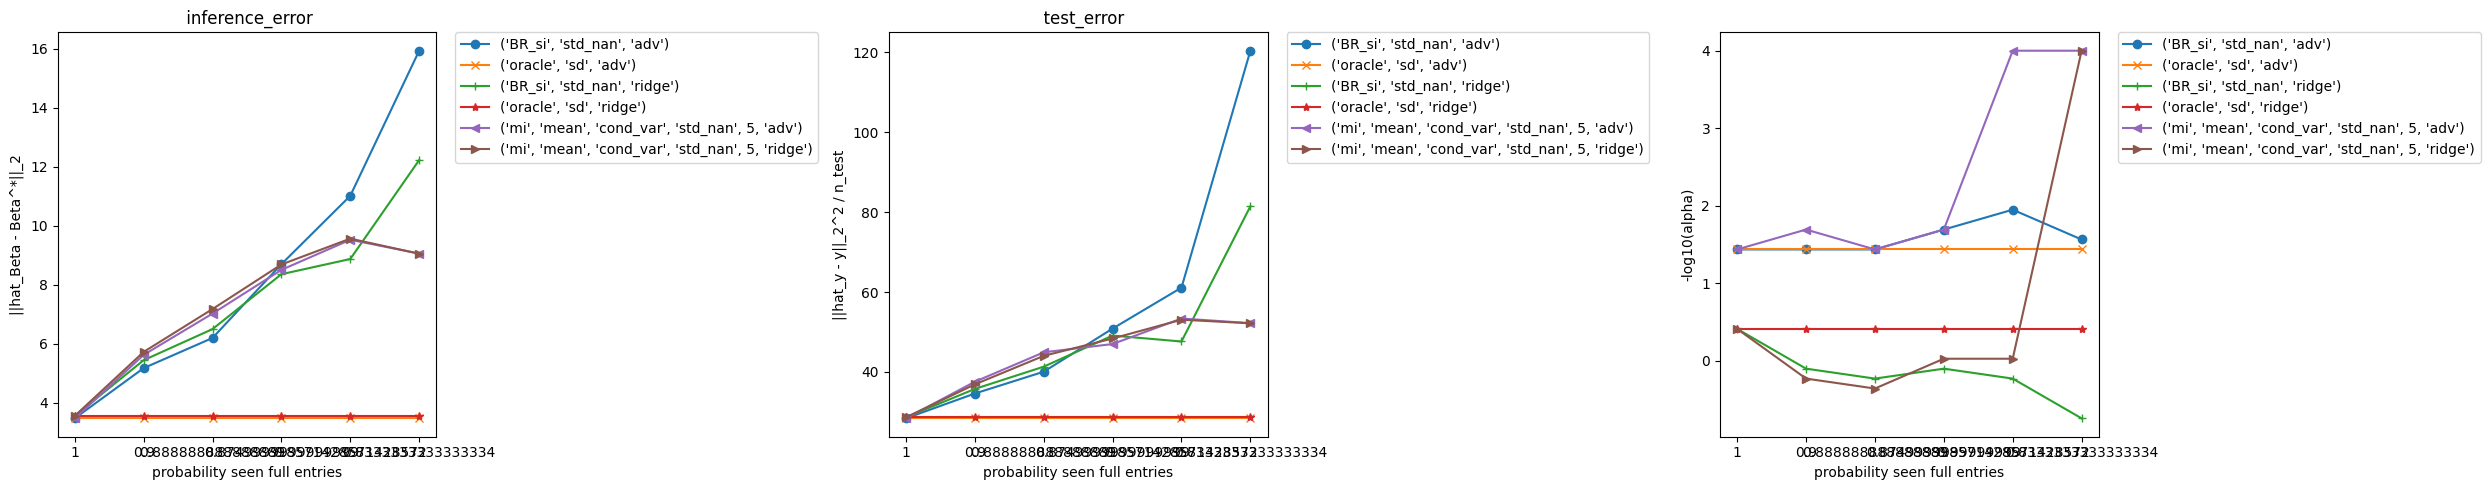

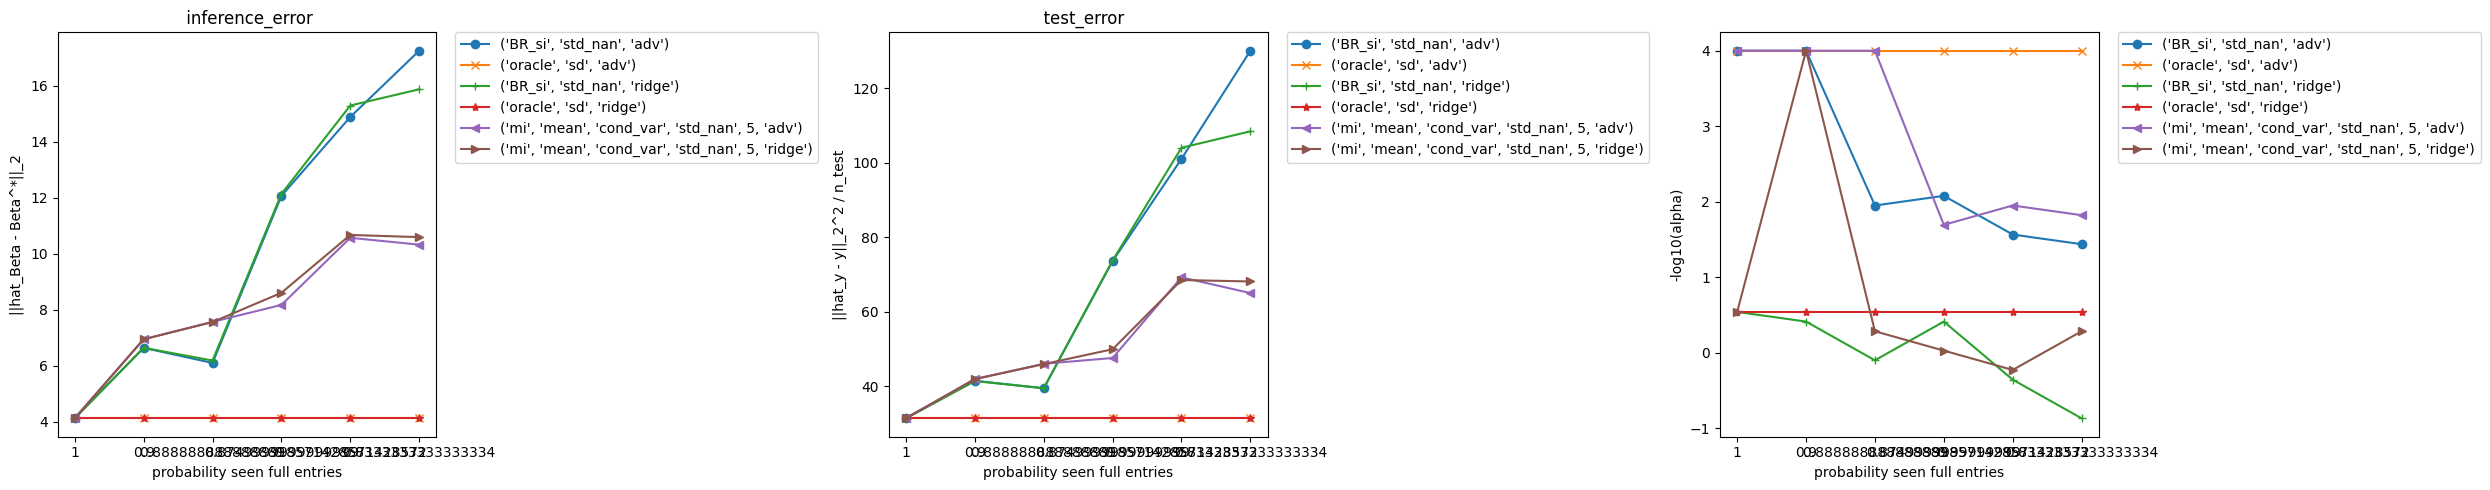

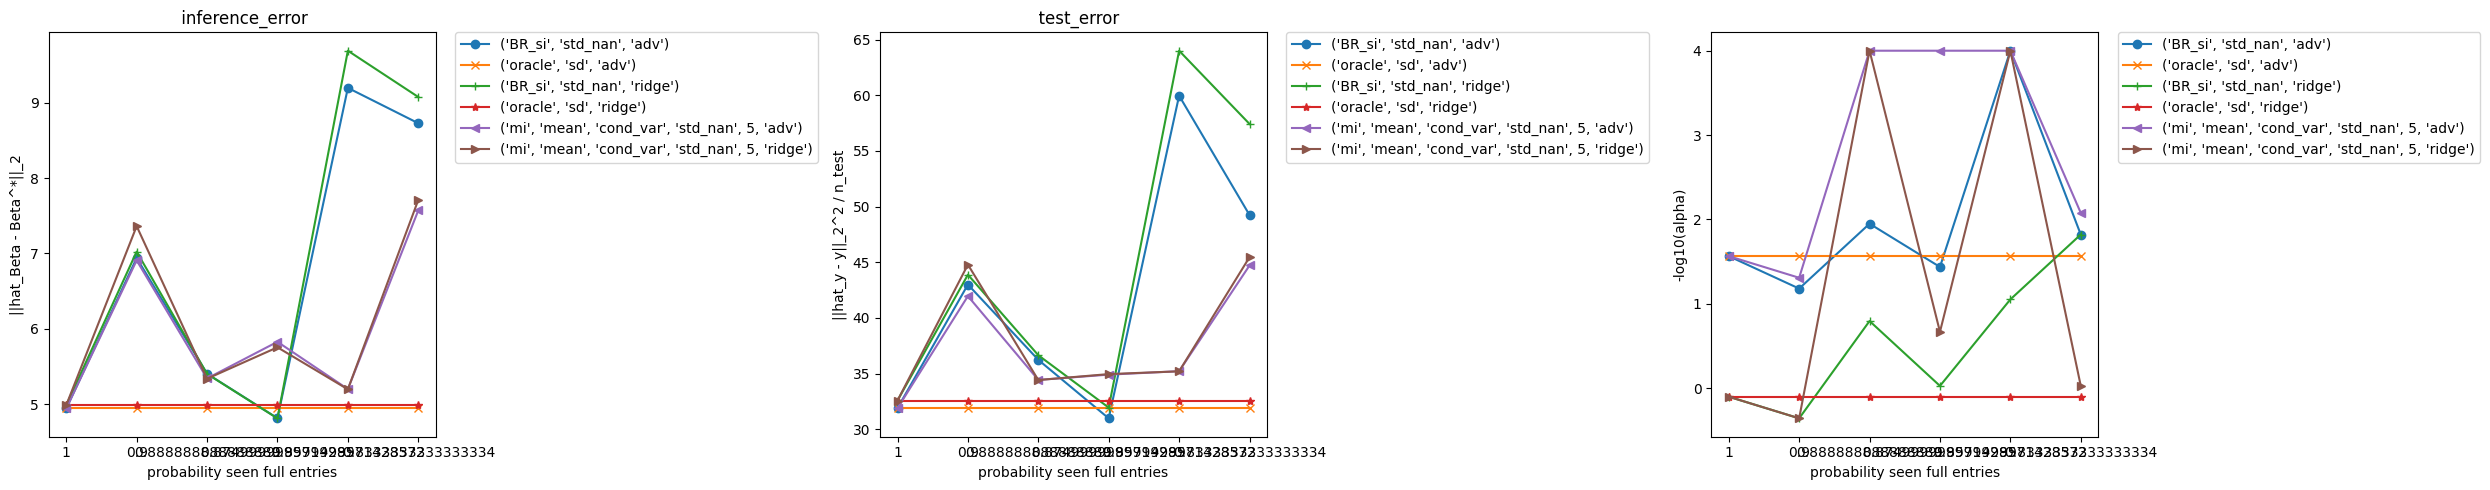

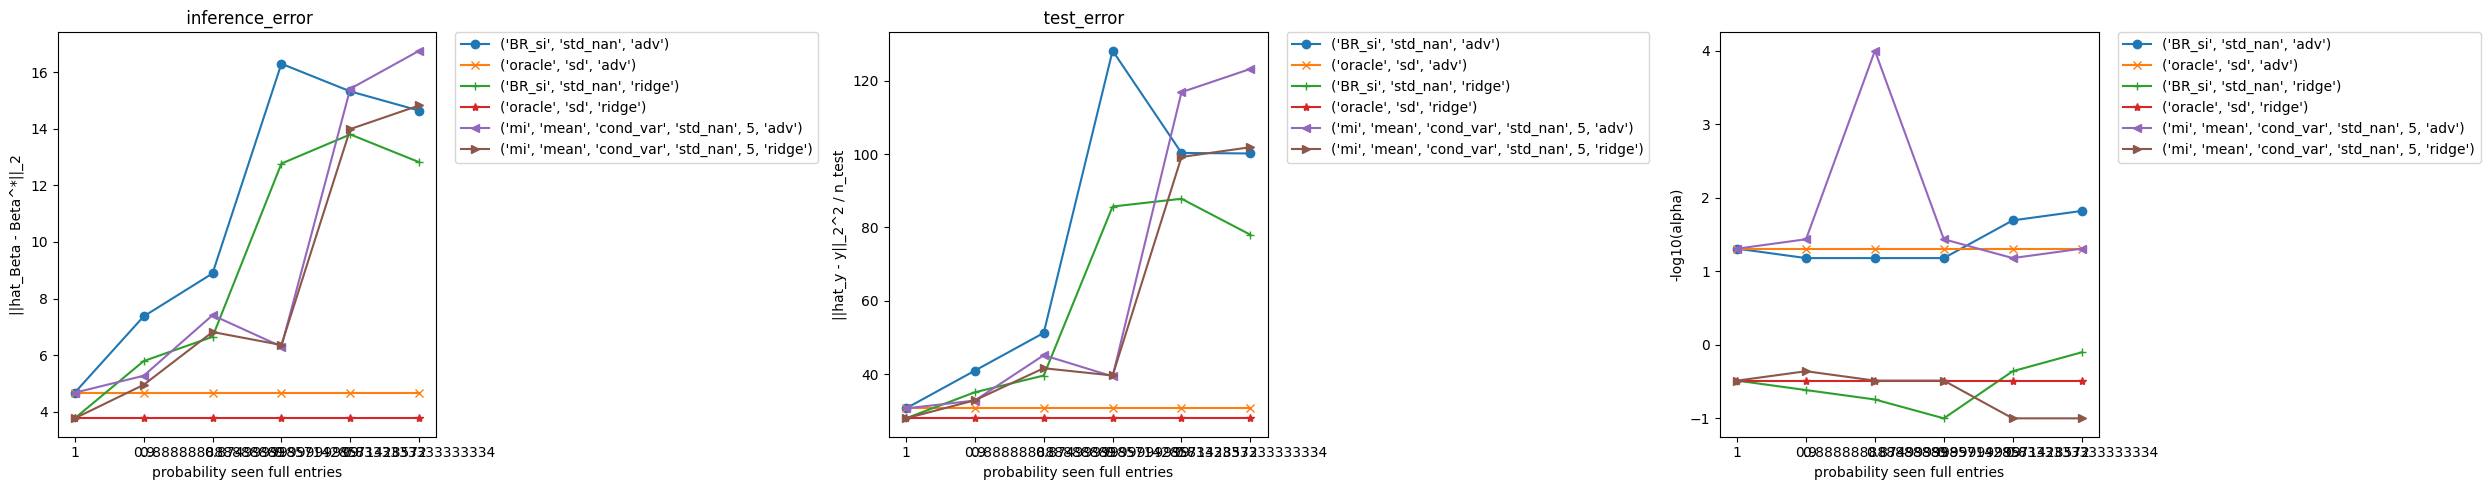

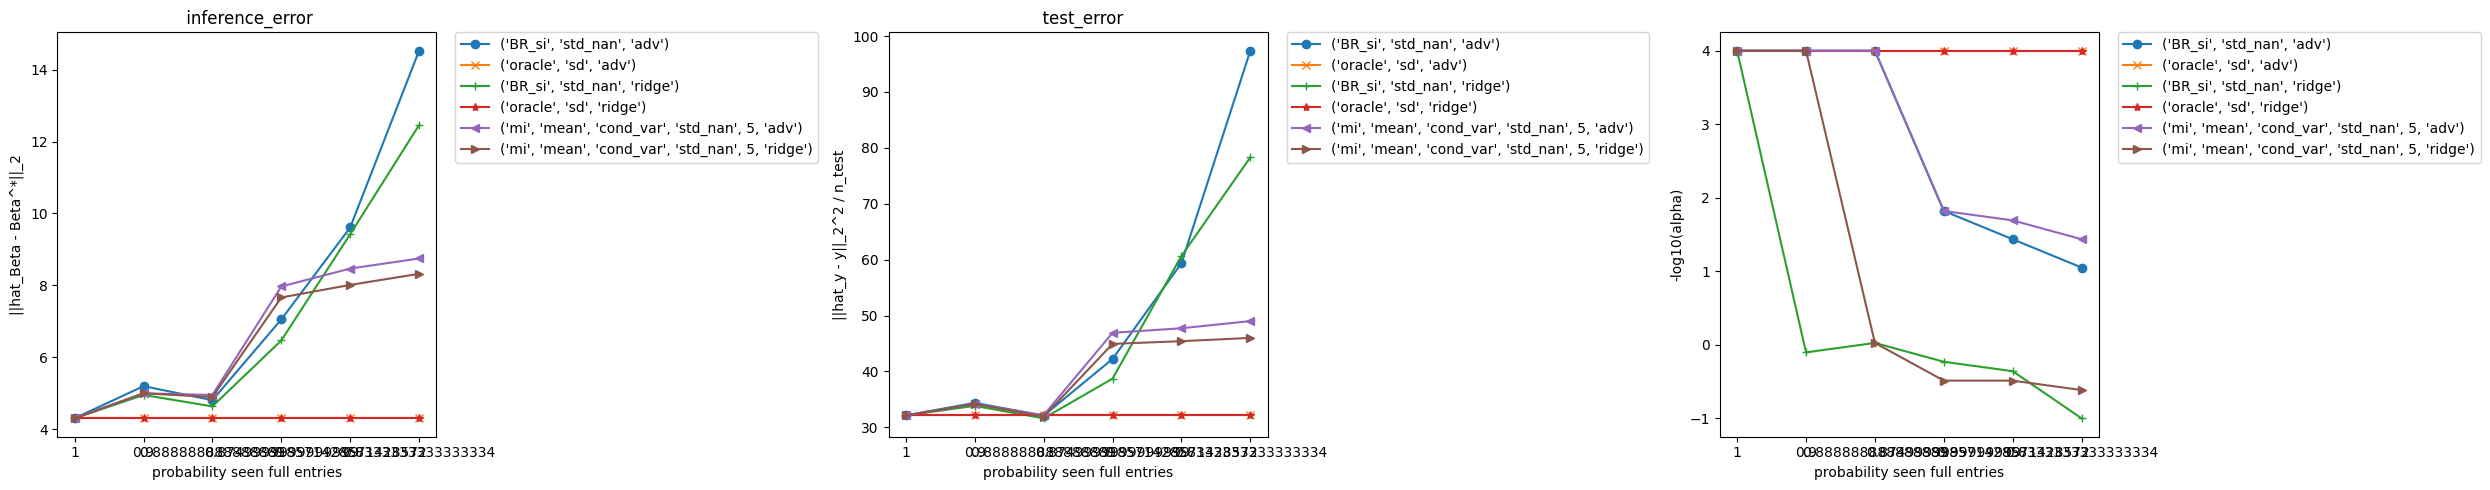

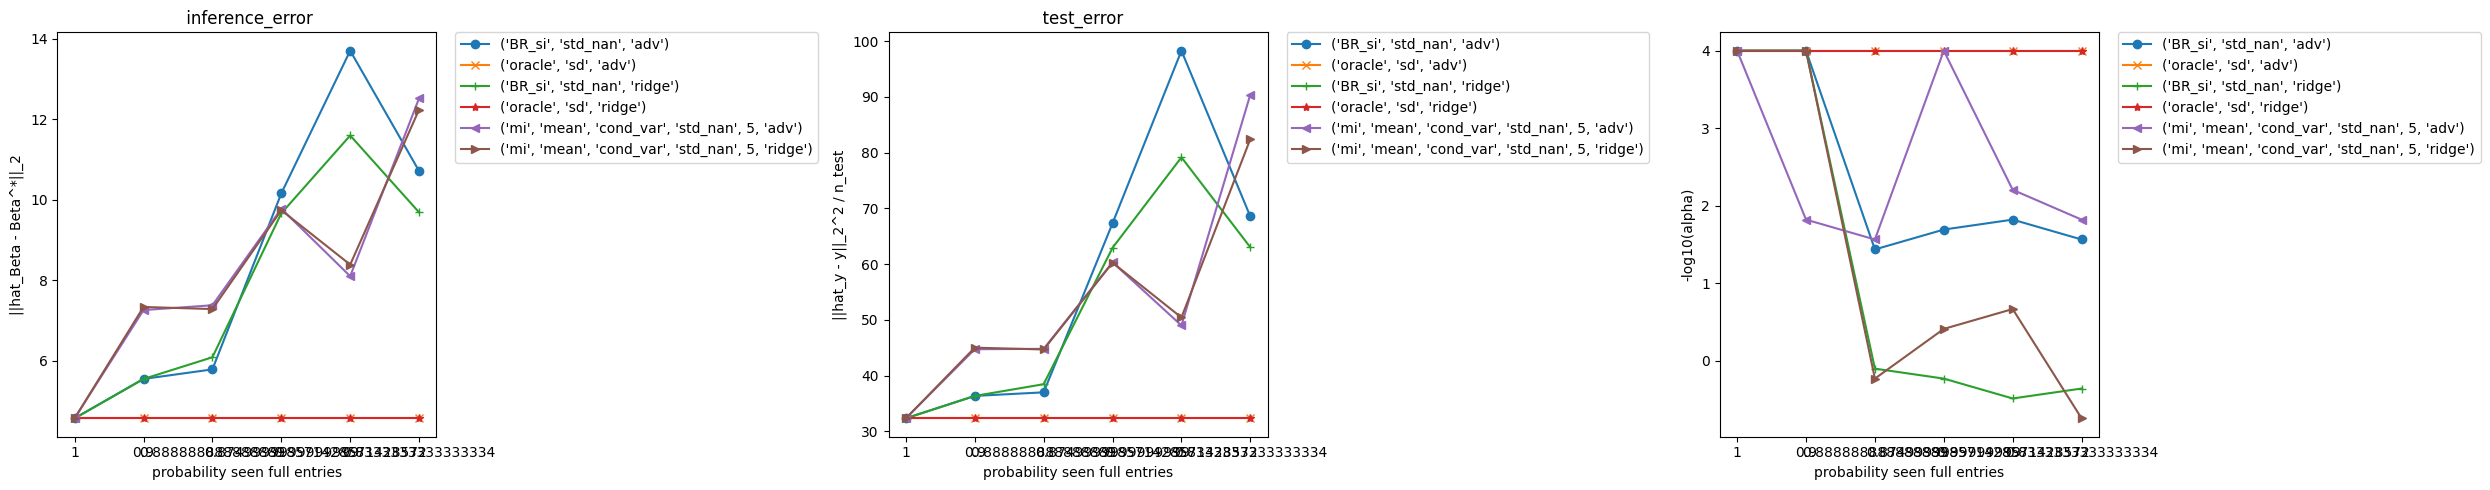

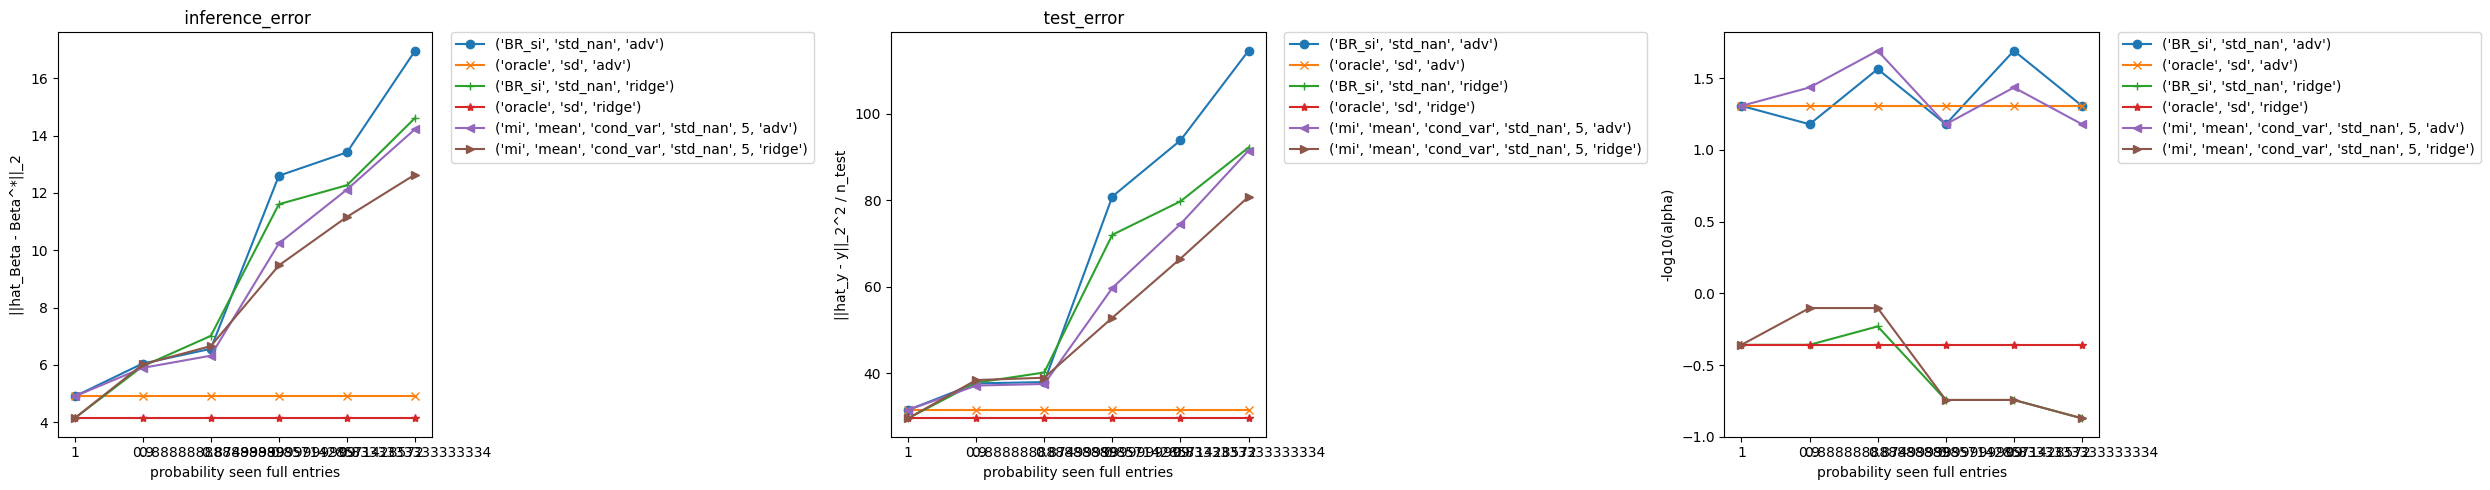

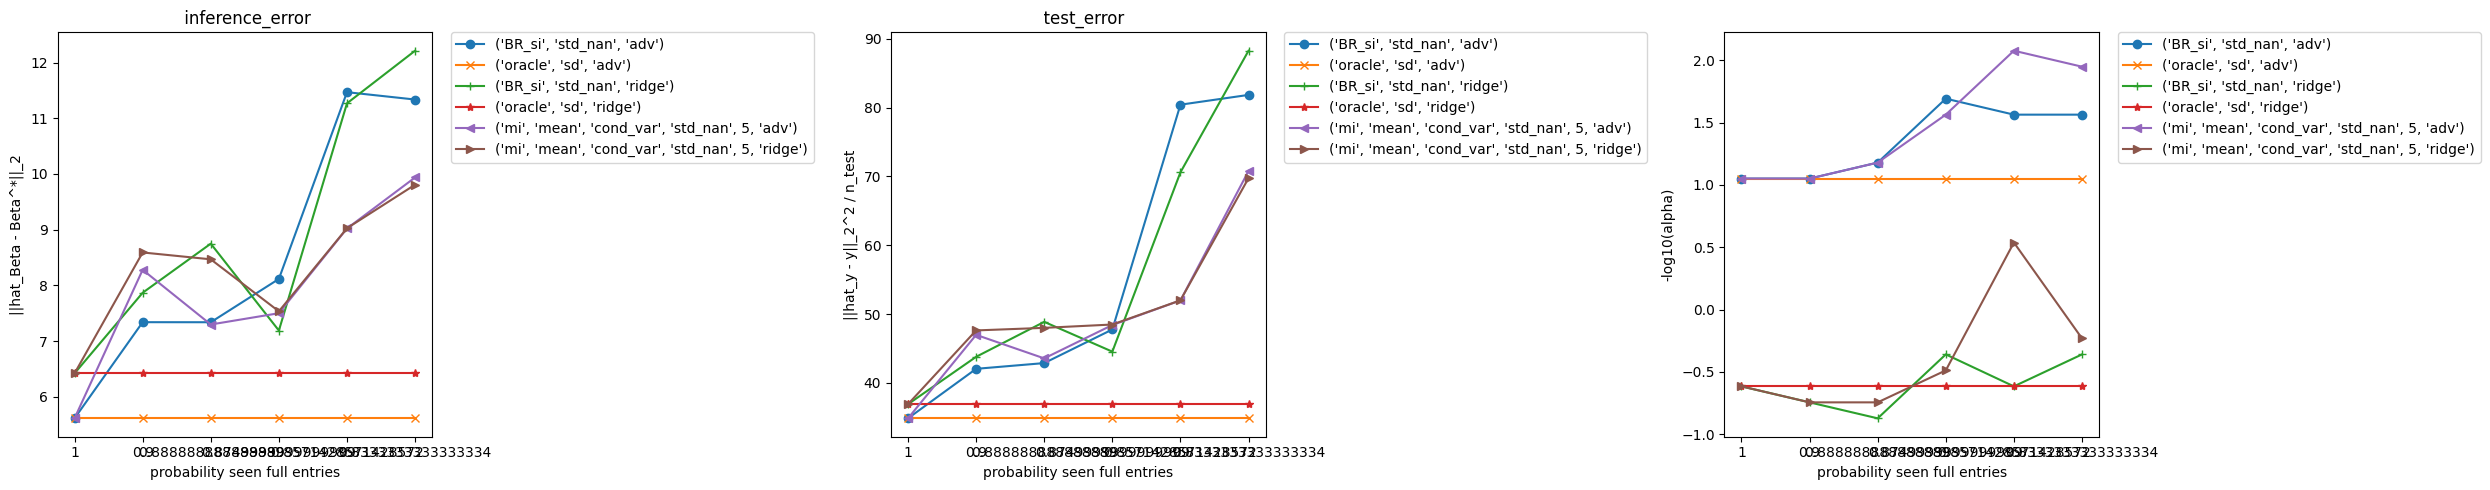

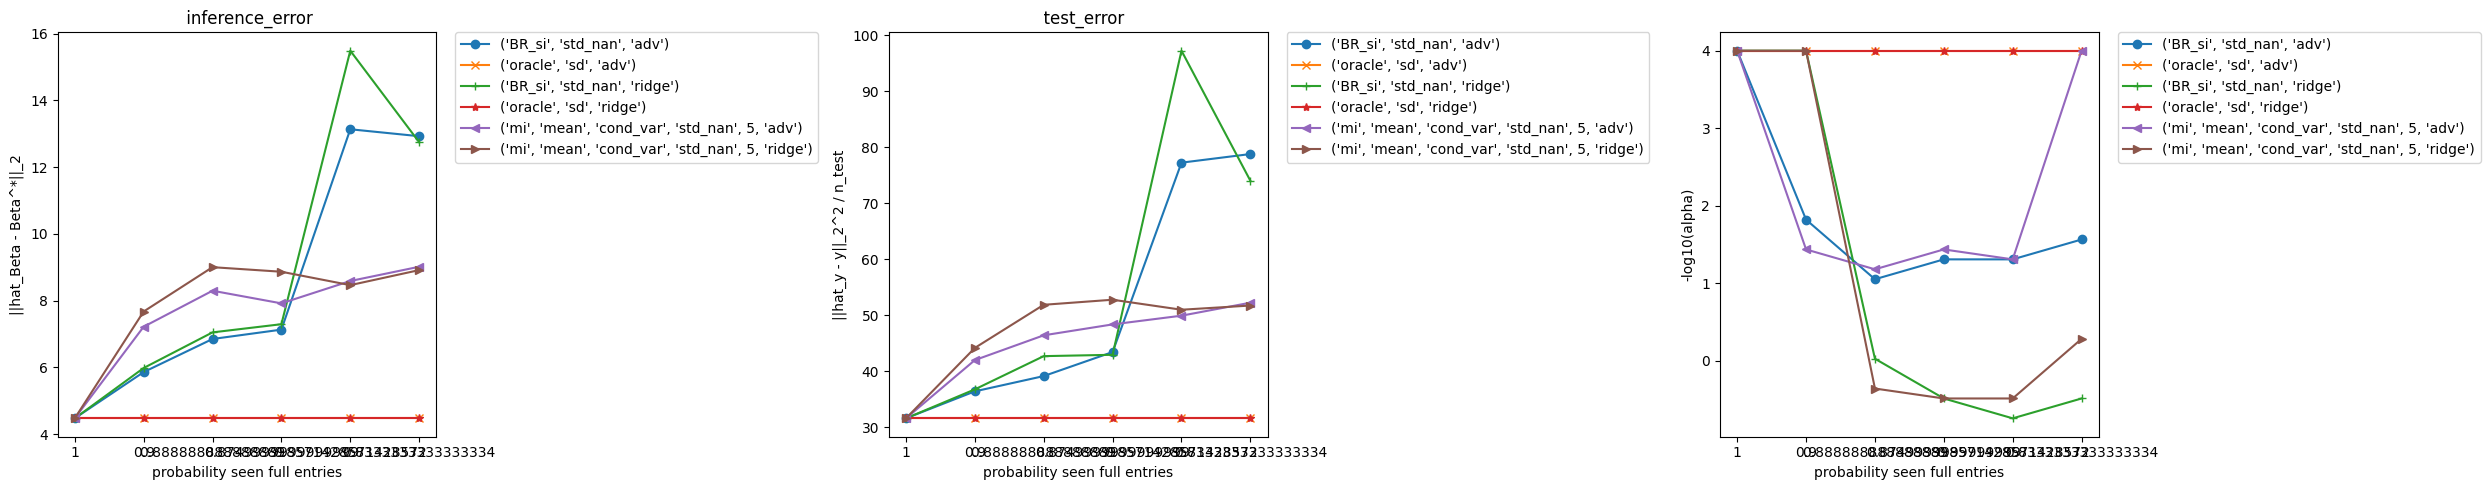

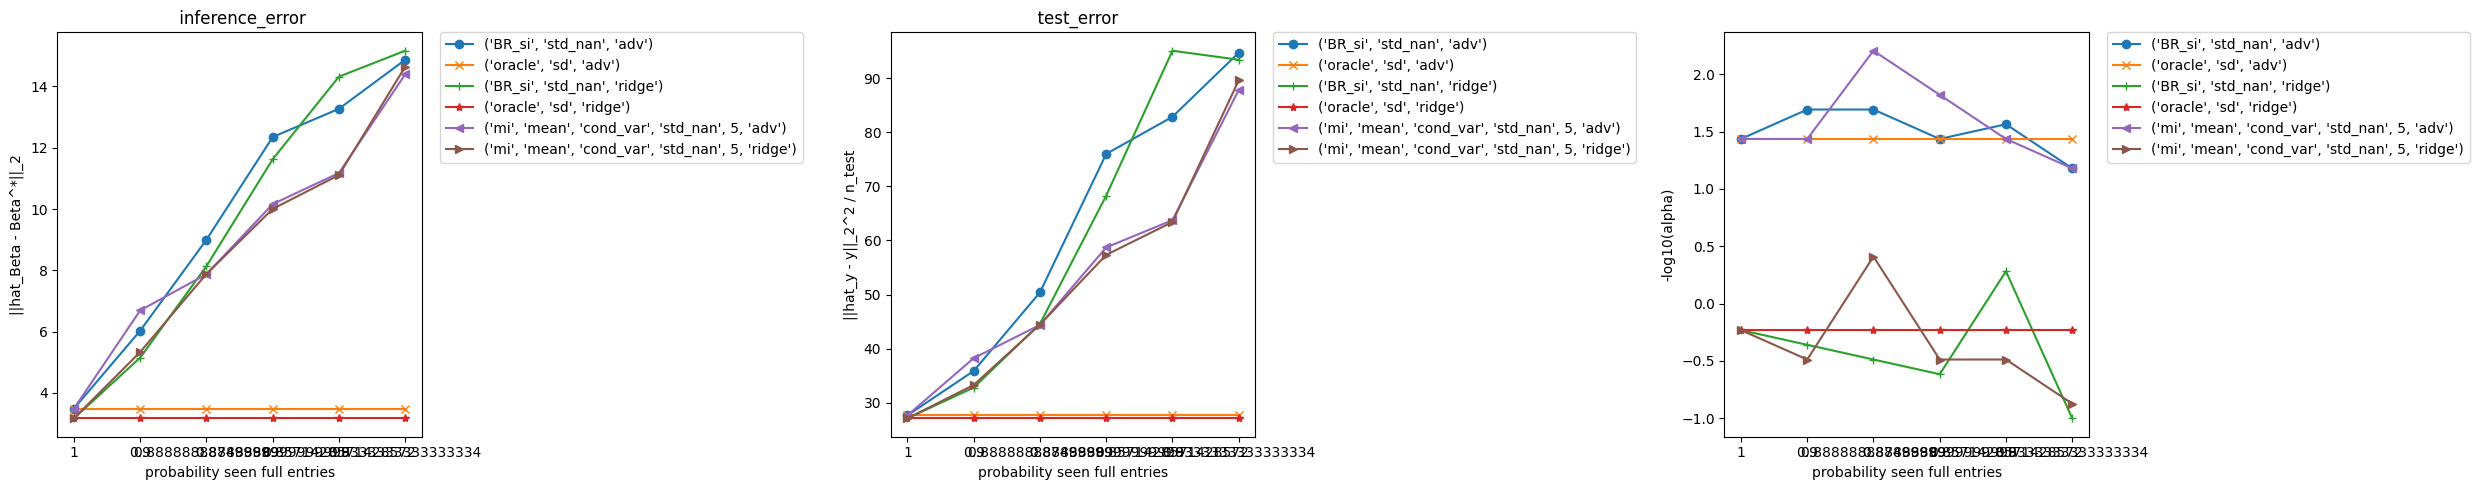

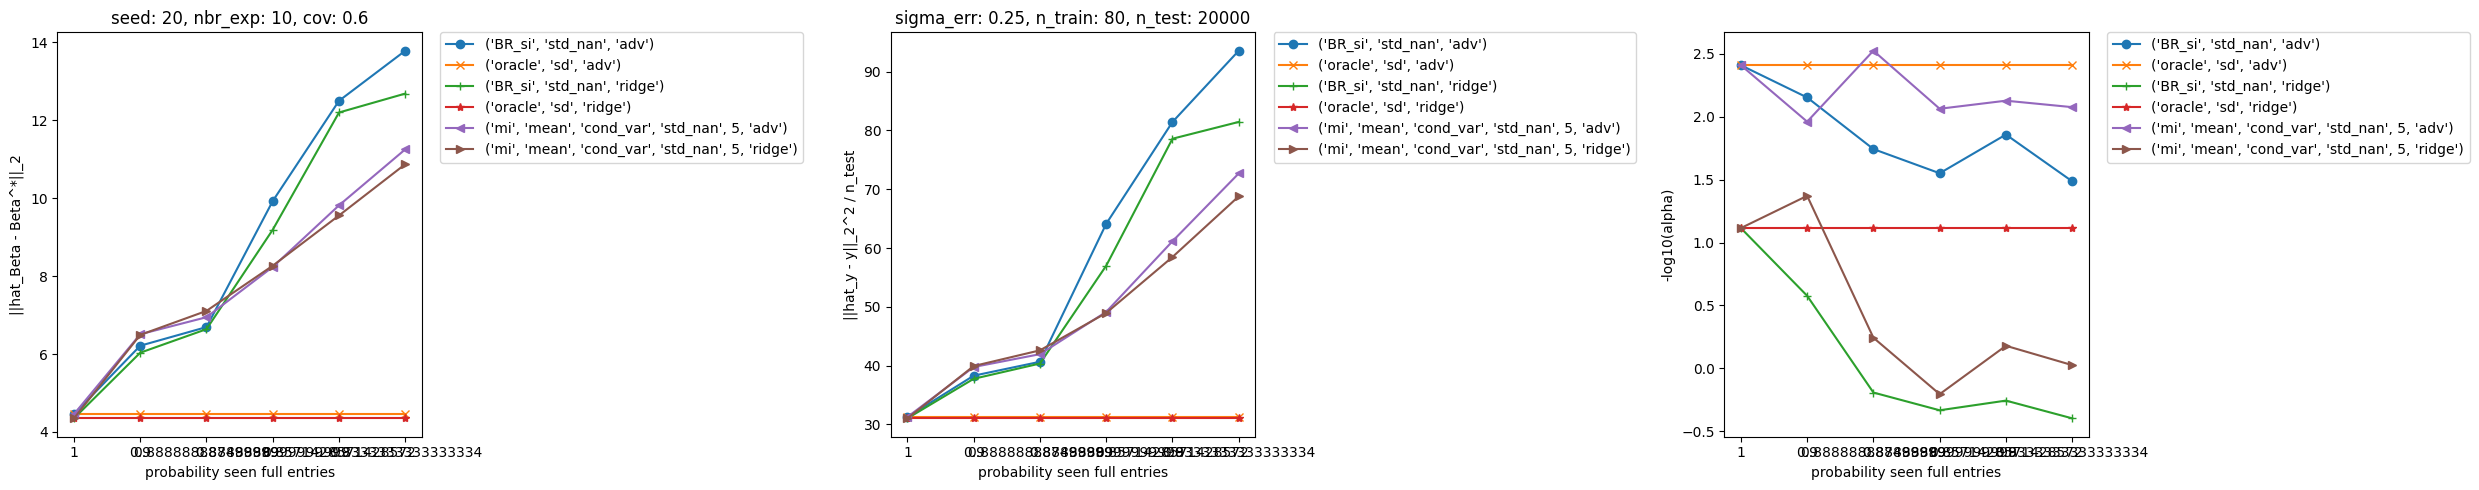

In [26]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6]
p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6]
#p_seen_both = [0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [80] * length_vec
error_vec =  [0.25] * length_vec
#p_seen = make_probabilities(p_seen_both)
p_seen = [p_seen_both] * length_vec
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)
number_test = 20000
cov_var = 0.6
beta_gt = np.array([-0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4, 5, 6, 7, 8])
dim = len(beta_gt)
mean = np.array([0] * dim)
matr = np.random.randn(dim, dim) * 0.1
cov = matr.T @ matr + np.eye(dim) * 0.25
# np.array([[1, cov_var], [cov_var, 1]])

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=number_test,
    data = {'data': 'Normal', 'mean': mean, 'cov': cov},
    beta_gt = beta_gt,
    p_miss = p_seen,
    err_vector = ['Gaussian_on_X', error_vec],
    plots = []#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc = dicc | {'generation': gen, 'title_infer_error':' inference_error', 'title_test_error':'  test_error'}
dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 10, 'adv_rad_times_delta_mis_max': 10, 'alpha_ridge_reg_max': 10,
                             'eps_adv_rad_times_delta_dts': 1e-5, 'eps_adv_rad_times_delta_mis': 1e-5, 'eps_alpha_ridge_reg': 1e-5,
                             'n_a_dts': 40, 'n_a_mis':5, 'n_a_rid': 40}}

for key, value in dicc.items():
  print(key, ": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 5
# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):

list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn':'adv'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn':'adv'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn':'ridge'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn':'ridge'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 1},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv'}, #, 'multip_dataset': 3, 'multip_missing': 3},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'ridge'}
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr}#, 'multip_dataset': 3, 'multip_missing': 3}
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''
nbr_exp = 10
seed = 20
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = 'seed: ' + str(seed) + ', nbr_exp: ' + str(nbr_exp) + ', cov: ' + str(cov_var)
dicc['title_test_error'] = 'sigma_err: ' + str(error_vec[0]) + ', n_train: ' + str(n_train[0]) + ', n_test: ' + str(number_test)
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




In [ ]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


In [ ]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

In [ ]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

In [ ]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

In [ ]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]



In [ ]:
import numpy as np

XX = np.random.randint(1, 7, (2, 3, 3))
print(XX)
XXX = np.tile(XX, (2, 1, 1))
print(XXX)

print(np.zeros(2))

y_o = np.array([1, 2])
y_oo = np.tile(y_o, 3)
print(y_oo)


In [ ]:
import numpy as np
def generate_masks_binomial_general(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks


#mm = np.random.binomial(1, [[0.2, 0.2, 0.2], [0.8, 0.8, 0.8]], (2, 3, 3))
#print(mm)
cc = np.array([np.random.binomial(1, x, (4, 4)) for x in [0.2, 0.2, 0.2]])
print(cc)
s_cc = np.cumsum(cc, axis=0)
print(s_cc)
s_cc[s_cc>1] = 1
print(s_cc)

s_v = np.random.randint(1, 4, (3, 4))
print(s_v)
s_vv = s_v[:, None, :] * np.eye(4)
print(s_vv)









[[[0 0 0 0]
  [0 0 0 0]
  [0 1 1 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 1]
  [0 0 1 0]]

 [[0 0 0 0]
  [0 0 0 1]
  [0 0 0 0]
  [0 0 1 0]]]
[[[0 0 0 0]
  [0 0 0 0]
  [0 1 1 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 1 1 1]
  [0 0 1 0]]

 [[0 0 0 0]
  [0 0 0 1]
  [0 1 1 1]
  [0 0 2 0]]]
[[[0 0 0 0]
  [0 0 0 0]
  [0 1 1 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 1 1 1]
  [0 0 1 0]]

 [[0 0 0 0]
  [0 0 0 1]
  [0 1 1 1]
  [0 0 1 0]]]
[[2 3 1 2]
 [2 1 3 1]
 [1 3 2 1]]
[[[2. 0. 0. 0.]
  [0. 3. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 2.]]

 [[2. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 3. 0.]
  [0. 0. 0. 1.]]

 [[1. 0. 0. 0.]
  [0. 3. 0. 0.]
  [0. 0. 2. 0.]
  [0. 0. 0. 1.]]]


In [30]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import ridge_regression

X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)
np.random.seed(4)
alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False, random_state=0)
for a in alphas:
  #coef, intercept = estim(X, y, a)
  coef = estim(X, y, a)
  print("coef : ", coef)
  #print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  #print("coef : ", coef)
  #print("intercpt ", intercept)






coef :  [ 1.99234884 -0.99981871 -0.01555797 -0.01290579]
coef :  [ 1.99233051 -0.99981168 -0.01555649 -0.01290386]
coef :  [ 1.99049891 -0.99910915 -0.01540842 -0.01271124]
coef :  [ 1.97400571 -0.992763   -0.01409143 -0.01099221]
